In [4]:
!pip install --upgrade dspy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.6/174.6 kB 6.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.5/197.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.5/407.5 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115

In [5]:
!pip install --upgrade openai

In [6]:
import random
import dspy
from dspy.evaluate import Evaluate
import os
import pandas as pd
import openai
from openai import OpenAI
from dspy.evaluate import Evaluate
from dspy.teleprompt import BootstrapFewShot
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
import json
import math
import time
import matplotlib.pyplot as plt
import numpy as np
import re

In [ ]:
gpt4o_mini = dspy.OpenAI(model='gpt-4o-mini', max_tokens=1000)
dspy.configure(lm=gpt4o_mini)

# Data prepocess

In [ ]:
trainset= pd.read_csv('trainset.csv')
testset= pd.read_csv('testset.csv')

In [ ]:
trainset.columns

Index(['Unnamed: 0', 'restaurant_name', 'Name', 'Profile Location', 'Score',
       'Date', 'Elite 24', 'Friends', 'Reviews', 'Photos', 'reserved',
       'pictures', 'checkin', 'Comment', 'Helpful', 'Thanks', 'Love this',
       'Oh no', 'Reply Date', 'Reply Content'],
      dtype='object')

In [ ]:
testset.columns

Index(['Unnamed: 0', 'restaurant_name', 'Name', 'Profile Location', 'Score',
       'Date', 'Elite 24', 'Friends', 'Reviews', 'Photos', 'reserved',
       'pictures', 'checkin', 'Comment', 'Helpful', 'Thanks', 'Love this',
       'Oh no', 'Reply Date', 'Reply Content'],
      dtype='object')

In [ ]:
validation_set = pd.read_csv('correct_labels_cleaned.csv')

In [ ]:
len(trainset),len(testset),len(validation_set)

(100, 50, 50)

In [ ]:
train_set = trainset[['Comment']]
train_set = json.loads(train_set.to_json(orient="records"))
test_set = testset[['Comment']]
test_set = json.loads(test_set.to_json(orient="records"))

In [ ]:
type(train_set)

list

In [ ]:
val_set = validation_set[['Comment','Categories','Descriptions']]
val_set = json.loads(val_set.to_json(orient="records"))

In [ ]:
# Create dataset
training_set = [dspy.Example(x).with_inputs('Comment') for x in train_set]
testing_set = [dspy.Example(x).with_inputs('Comment') for x in test_set]
devset = [dspy.Example(x).with_inputs('Comment') for x in val_set]

In [ ]:
type(devset)

list

In [ ]:
testing_set[0]

Example({'Comment': "If you're a tourist definitely make a resy but if you're coming here to relive your memories don't. Nothing is what it used to be - it's not bad - it can't live up to the memories."}) (input_keys={'Comment'})

In [ ]:
type(training_set)

list

In [ ]:
training_set[0]

Example({'Comment': "The 13 year old girl in me loved this place. The 40 year old woman can see through the gimmicks and could appreciate it for what it is- a pure novelty riding on its history and place as a tourist trap. \nFun atmosphere but really checked out and disinterested wait staff. They try to take photos of you and sell a souvenir photo which is NOT my cup of tea (frozen OR hot). \nThe frozen hot chocolate was great. I wish we would have stopped there but they require a $19 purchase per person. \nWe had the cauliflower appetizer (too small but tasted fine) and the loaded fries (meh). \nDo not. I REPEAT DO NOT get a pina colada. \nSuper pricey and yes, disappointing if you go in with unrealistic expectations. Wouldn't return or recommend but I had to go and I get why you want to too."}) (input_keys={'Comment'})

In [ ]:
devset[0]

Example({'Comment': "I LOVE Red Hook Lobster (RHL). I live in the DC area and first tried it here, but unfortunately the pandemic hit them hard and resulted in a closure. So, imagine my excitement when the hubby and I visited NY and saw RHL on the list for Smorgasburg. \nWe visited RHL's food stall at Smorgasburg on 5/26/2024. I was laser focused on what I wanted upon arrival, yes, I saw there were other restaurants there, but did I care? No. I wanted RHL and basically nothing else!\nI ordered the Connecticut roll - it was warm, buttery, with toasty bread and I almost fell down because my knees were weak. I freaking love this roll. After consuming it, I said, hmm, I want more and went back and got the Maine style lobster roll, which is the cold style. Both of these rolls were perfect, but my preference is certainly the Connecticut roll. \nMy complaints, well the normal ones, I wish the rolls were double the size and half the price, but 2024 has lobster costing a million dollars a pound

#RHL examples

In [ ]:
sample_dev_set = correct_labels.sample(frac=0.4, random_state=42)

In [ ]:
rhl_reviews_valset['Categories'] = rhl_reviews_valset['Categories'].apply(lambda x: ', '.join(x))
rhl_reviews_valset['Descriptions'] = rhl_reviews_valset['Descriptions'].apply(lambda x: ' '.join(x))

In [ ]:
validation_set = json.loads(rhl_reviews_valset.to_json(orient="records"))

In [ ]:
rhl_reviews_trainset = rhl_reviews_trainset[['Comment', 'Categories', 'Descriptions']] #,'Attitudes'
rhl_reviews_testset = rhl_reviews_testset[['Comment', 'Categories', 'Descriptions']]#,'Attitudes'

In [ ]:
rhl_reviews_trainset['Categories'] = rhl_reviews_trainset['Categories'].apply(lambda x: ', '.join(x))
rhl_reviews_trainset['Descriptions'] = rhl_reviews_trainset['Descriptions'].apply(lambda x: ' '.join(x))
rhl_reviews_testset['Categories'] = rhl_reviews_testset['Categories'].apply(lambda x: ', '.join(x))
rhl_reviews_testset['Descriptions'] = rhl_reviews_testset['Descriptions'].apply(lambda x: ' '.join(x))

In [ ]:
training_set = json.loads(rhl_reviews_trainset.to_json(orient="records"))

In [ ]:
testing_set = json.loads(rhl_reviews_testset.to_json(orient="records"))

In [ ]:
training_set[0]

{'Comment': "I LOVE Red Hook Lobster (RHL). I live in the DC area and first tried it here, but unfortunately the pandemic hit them hard and resulted in a closure. So, imagine my excitement when the hubby and I visited NY and saw RHL on the list for Smorgasburg. \nWe visited RHL's food stall at Smorgasburg on 5/26/2024. I was laser focused on what I wanted upon arrival, yes, I saw there were other restaurants there, but did I care? No. I wanted RHL and basically nothing else!\nI ordered the Connecticut roll - it was warm, buttery, with toasty bread and I almost fell down because my knees were weak. I freaking love this roll. After consuming it, I said, hmm, I want more and went back and got the Maine style lobster roll, which is the cold style. Both of these rolls were perfect, but my preference is certainly the Connecticut roll. \nMy complaints, well the normal ones, I wish the rolls were double the size and half the price, but 2024 has lobster costing a million dollars a pound, so I g

In [ ]:
# Create dataset
val_set = [dspy.Example(x).with_inputs('Comment') for x in validation_set]
train_set = [dspy.Example(x).with_inputs('Comment') for x in training_set]
test_set = [dspy.Example(x).with_inputs('Comment') for x in testing_set]

In [ ]:
val_example = val_set[0]
print(f"Comment: {val_example.Comment}")
print(f"Categories: {val_example.Categories}\n")
print(f"Descriptions: {val_example.Descriptions}")

Comment: I have been to this restaurant during the summer for their lobster specials that were lovely. We went today and all I can say is Meh. The calamari was delicious but really salty. The New England clam chowder was pretty good. The pretzels were horrible - don't bother - they were super stale and dry and just warmed up. I had the 1.5 pound lobster for $42 which was a really high price for that size lobster but it was cooked perfectly. Instead of the boiled potato and corn (which I tasted from my nieces plate - the corn pretty tasteless. I stream of corn and boiled potato I we t for the potato salad that was absolutely awful. It tried but did not succeed. The banana cream pudding and the churros for desert were great as was the service. Which is why I gave it 3 stars, I don't think k I'll be going back there
Categories: Food Quality, Value for Money, Customer Service

Descriptions: Mixed reviews on food quality; calamari delicious but salty, New England clam chowder was good, pret

In [ ]:
train_example = train_set[0]
print(f"Comment: {train_example.Comment}\n")
print(f"Categories: {train_example.Categories}\n")
print(f"Descriptions: {train_example.Descriptions}")

Comment: I LOVE Red Hook Lobster (RHL). I live in the DC area and first tried it here, but unfortunately the pandemic hit them hard and resulted in a closure. So, imagine my excitement when the hubby and I visited NY and saw RHL on the list for Smorgasburg. 
We visited RHL's food stall at Smorgasburg on 5/26/2024. I was laser focused on what I wanted upon arrival, yes, I saw there were other restaurants there, but did I care? No. I wanted RHL and basically nothing else!
I ordered the Connecticut roll - it was warm, buttery, with toasty bread and I almost fell down because my knees were weak. I freaking love this roll. After consuming it, I said, hmm, I want more and went back and got the Maine style lobster roll, which is the cold style. Both of these rolls were perfect, but my preference is certainly the Connecticut roll. 
My complaints, well the normal ones, I wish the rolls were double the size and half the price, but 2024 has lobster costing a million dollars a pound, so I get it.


In [ ]:
print(f"For this dataset, training examples have input keys {train_example.inputs().keys()} and label keys {train_example.labels().keys()}")
print(f"For this dataset, dev examples have input keys {val_example.inputs().keys()} and label keys {val_example.labels().keys()}")

For this dataset, training examples have input keys ['Comment'] and label keys ['Categories', 'Descriptions']
For this dataset, dev examples have input keys ['Comment'] and label keys ['Categories', 'Descriptions']


In [ ]:
# Define the predictor.
extracted_topics = dspy.ChainOfThought(extract_topics)

# Call the predictor on a particular input.
pred_category = extracted_topics(Comment=train_example.Comment)

# Print the input and the prediction.
print(f"Comment of reviews: {train_example.Comment}\n")
print(f"Categories extracted: {pred_category.Categories}")

Comment of reviews: I LOVE Red Hook Lobster (RHL). I live in the DC area and first tried it here, but unfortunately the pandemic hit them hard and resulted in a closure. So, imagine my excitement when the hubby and I visited NY and saw RHL on the list for Smorgasburg. 
We visited RHL's food stall at Smorgasburg on 5/26/2024. I was laser focused on what I wanted upon arrival, yes, I saw there were other restaurants there, but did I care? No. I wanted RHL and basically nothing else!
I ordered the Connecticut roll - it was warm, buttery, with toasty bread and I almost fell down because my knees were weak. I freaking love this roll. After consuming it, I said, hmm, I want more and went back and got the Maine style lobster roll, which is the cold style. Both of these rolls were perfect, but my preference is certainly the Connecticut roll. 
My complaints, well the normal ones, I wish the rolls were double the size and half the price, but 2024 has lobster costing a million dollars a pound, so

In [ ]:
# Define the predictor.
reformatted_review = dspy.ChainOfThought(reformat)

# Call the predictor on a particular input.
pred_description = reformatted_review(Comment=train_example.Comment,Categories=train_example.Categories)

# Print the input and the prediction.
print(f"Comment of reviews: {train_example.Comment}\n")
print(f"Description reformatted: {pred_description.Descriptions}")

Comment of reviews: I LOVE Red Hook Lobster (RHL). I live in the DC area and first tried it here, but unfortunately the pandemic hit them hard and resulted in a closure. So, imagine my excitement when the hubby and I visited NY and saw RHL on the list for Smorgasburg. 
We visited RHL's food stall at Smorgasburg on 5/26/2024. I was laser focused on what I wanted upon arrival, yes, I saw there were other restaurants there, but did I care? No. I wanted RHL and basically nothing else!
I ordered the Connecticut roll - it was warm, buttery, with toasty bread and I almost fell down because my knees were weak. I freaking love this roll. After consuming it, I said, hmm, I want more and went back and got the Maine style lobster roll, which is the cold style. Both of these rolls were perfect, but my preference is certainly the Connecticut roll. 
My complaints, well the normal ones, I wish the rolls were double the size and half the price, but 2024 has lobster costing a million dollars a pound, so

In [ ]:
pred_description.Descriptions

"The reviewer highly praises the food quality of Red Hook Lobster's rolls, especially the Connecticut roll, while expressing a desire for better value for money due to the high prices."

In [ ]:
gpt4o_mini.inspect_history(n=1)

In [ ]:
sentiment = dspy.Predict("document -> sentiment")
result = sentiment(document="I love minions! They are soooo cure!!")
print(result.sentiment)

Positive


#The core definition of the Signature & Model

In [ ]:
class ChainOfThought(dspy.Module):
  def __init__(self, signature):
    # Modify signature from ‘*inputs -> *outputs ‘ to ‘*inputs -> rationale , *outputs ‘.
    rationale_field = dspy.OutputField(prefix="Reasoning: Let’s think step by step.")
    signature = dspy.Signature(signature).prepend_output_field(rationale_field)
    # Declare a sub-module with the modified signature.
    self.predict = dspy.Predict(signature)

  def forward(self, **kwargs):
    # Just forward the inputs to the sub-module.
    return self.predict(**kwargs)

In [ ]:
class extract_topics(dspy.Signature):
    """Classify review content into categories"""
    Comment = dspy.InputField(desc="a restaurant review")
    Categories = dspy.OutputField(desc="""Extract mentioned topics from following review.
                              Categories include Food/Drink/Dessert Quality, Portion Size, Customer Service,
                              Cleanliness, Ambiance, Value for Money, Order Accuracy, Waiting time""")

class reformat(dspy.Signature):
    """Summarize descriptions based on the review and categories"""
    Comment = dspy.InputField(desc="a restaurant review")
    Categories = dspy.InputField(desc=f"review topic categories")
    Descriptions = dspy.OutputField(desc="A summary of the review in one sentence, based on the review and category supplied")

In [ ]:
class Topics_in_reviews(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog1 = dspy.ChainOfThought(extract_topics)
        self.prog2 = dspy.ChainOfThought(reformat)

    def forward(self,Comment):
        Categories = self.prog1(Comment=Comment)
        Descriptions = self.prog2(Comment=Comment, Categories=Categories.Categories)
        return dspy.Prediction(Descriptions = Descriptions.Descriptions)

#Metric for optimization

In [ ]:
# Define the signature for automatic assessments.
class Assess(dspy.Signature):
    """Assess the quality of a description along the specified dimension."""
    assessed_text = dspy.InputField()
    assessed_field = dspy.InputField()
    assessment_question = dspy.InputField()
    assessment_answer = dspy.OutputField(desc="score it from 0 to 100:")

In [ ]:
def metric(example, pred, trace: object = None):
    Comment = example.Comment
    summary = pred.Descriptions
    question = "Is the assessed text a good summary of this review, capturing all the important details??"
    with dspy.context(lm=gpt4o_mini):
        score = dspy.ChainOfThought(Assess)(assessed_text=Comment,
                                            assessment_question=question,
                                            assessed_field=summary)
    return float(score.assessment_answer.split(": ")[-1])/100

## samples

In [ ]:
# Define the predictor.
extracted_topics = dspy.ChainOfThought(extract_topics)

# Call the predictor on a particular input.
pred_category = extracted_topics(Comment=training_set[0].Comment)

# Print the input and the prediction.
print(f"Comment of reviews: {training_set[0].Comment}\n")
print(f"Categories extracted: {pred_category.Categories}")

Comment of reviews: The 13 year old girl in me loved this place. The 40 year old woman can see through the gimmicks and could appreciate it for what it is- a pure novelty riding on its history and place as a tourist trap. 
Fun atmosphere but really checked out and disinterested wait staff. They try to take photos of you and sell a souvenir photo which is NOT my cup of tea (frozen OR hot). 
The frozen hot chocolate was great. I wish we would have stopped there but they require a $19 purchase per person. 
We had the cauliflower appetizer (too small but tasted fine) and the loaded fries (meh). 
Do not. I REPEAT DO NOT get a pina colada. 
Super pricey and yes, disappointing if you go in with unrealistic expectations. Wouldn't return or recommend but I had to go and I get why you want to too.

Categories extracted: Food/Drink/Dessert Quality, Portion Size, Customer Service, Ambiance, Value for Money


In [ ]:
# Define the predictor.
reformatted_review = dspy.ChainOfThought(reformat)

# Call the predictor on a particular input.
pred_description = reformatted_review(Comment=training_set[0].Comment,Categories=pred_category.Categories)

# Print the input and the prediction.
print(f"Description reformatted: {pred_description.Descriptions}")

Description reformatted: The restaurant offers a fun atmosphere and great frozen hot chocolate, but suffers from disinterested service, small portion sizes, and poor value for money, leading the reviewer to not recommend it.


In [ ]:
sentiment = dspy.Predict("document -> sentiment")
result = sentiment(document=pred_description.Descriptions)
print(result.sentiment)

Document: The restaurant offers a fun atmosphere and great frozen hot chocolate, but suffers from disinterested service, small portion sizes, and poor value for money, leading the reviewer to not recommend it.
Sentiment: Negative


In [ ]:
Assessment = dspy.ChainOfThought(Assess)
test_result = Assessment(assessed_text=training_set[0].Comment,
                         assessed_field=pred_description.Descriptions,  # Assuming you want to assess the 'Descriptions' field
                         assessment_question="Is the assessed text a good summary of this review, capturing all the important details??")  # Provide a specific question

In [ ]:
training_set[0].Comment

"The 13 year old girl in me loved this place. The 40 year old woman can see through the gimmicks and could appreciate it for what it is- a pure novelty riding on its history and place as a tourist trap. \nFun atmosphere but really checked out and disinterested wait staff. They try to take photos of you and sell a souvenir photo which is NOT my cup of tea (frozen OR hot). \nThe frozen hot chocolate was great. I wish we would have stopped there but they require a $19 purchase per person. \nWe had the cauliflower appetizer (too small but tasted fine) and the loaded fries (meh). \nDo not. I REPEAT DO NOT get a pina colada. \nSuper pricey and yes, disappointing if you go in with unrealistic expectations. Wouldn't return or recommend but I had to go and I get why you want to too."

In [ ]:
pred_description.Descriptions

'The restaurant offers a fun atmosphere and great frozen hot chocolate, but suffers from disinterested service, small portion sizes, and poor value for money, leading the reviewer to not recommend it.'

In [ ]:
metric(training_set[0],pred_description)

0.7

In [ ]:
Topics_in_reviews()

prog1 = ChainOfThought(extract_topics(Comment -> Categories
    instructions='Classify review content into categories'
    Comment = Field(annotation=str required=True json_schema_extra={'desc': 'a restaurant review', '__dspy_field_type': 'input', 'prefix': 'Comment:'})
    Categories = Field(annotation=str required=True json_schema_extra={'desc': 'Extract mentioned topics from following review.\n                              Categories include Food/Drink/Dessert Quality, Portion Size, Customer Service,\n                              Cleanliness, Ambiance, Value for Money, Order Accuracy, Waiting time', '__dspy_field_type': 'output', 'prefix': 'Categories:'})
))
prog2 = ChainOfThought(reformat(Comment, Categories -> Descriptions
    instructions='Summarize descriptions based on the review and categories'
    Comment = Field(annotation=str required=True json_schema_extra={'desc': 'a restaurant review', '__dspy_field_type': 'input', 'prefix': 'Comment:'})
    Categories = Field(annotatio

## seperate metric for category and description

In [ ]:
def metric_category(example, pred, trace=None):
    Comment = example.Comment
    Categories = example.Categories
    correct = f"Are the categories correct and fully summarizing assessed text? "
    with dspy.context(lm=gpt4o_mini):
        # Pass the topics string to assessed_category
        assessment_result =  dspy.ChainOfThought(Assess)(assessed_text=Comment,assessment_question=correct, assessed_field=Categories)
    correct_answers = [m.assessment_answer.lower() == 'yes' for m in [assessment_result]]
    score = 1 if correct_answers else 0
    return score

In [ ]:
def metric_description(example, pred, trace=None):
    # Descriptions = ", ".join(Descriptions)
    Comment = example.Comment
    Descriptions = pred.Descriptions
    correct = f"Are the description correct summarized from assessed text?"
    with dspy.context(lm=gpt4o_mini):
        # Pass the topics string to assessed_category
        assessment_result =  dspy.ChainOfThought(Assess)(assessed_text=Comment,assessment_question=correct, assessed_field=Descriptions)
    correct_answers = [m.assessment_answer.lower() == 'yes' for m in [assessment_result]]
    score = 1 if correct_answers else 0
    return score

In [ ]:
def create_example(row: pd.Series) -> dspy.Example:
    return dspy.Example(
        Comment = row['Comment'],
        # category = ", ".join(row['Categories']),
        # description = " ".join(row['Descriptions']),
        category = row['Categories'],
        description = row['Descriptions'],
        # attitude = row['Attitudes'],
    ).with_inputs("Comment")

examples_validation = []
for index, dev in val_set.iterrows():
    example = create_example(dev)
    examples_validation.append(example)

#Evaluation of Metrics

In [ ]:
gpt4o_mini.inspect_history(n=1)

In [ ]:
evaluate = dspy.evaluate.Evaluate(devset=devset, metric=metric, display_progress=True)
topics_instance = Topics_in_reviews()
evaluate(topics_instance)

Average Metric: 41.95000000000001 / 50  (83.9): 100%|██████████| 50/50 [04:44<00:00,  5.69s/it]

Average Metric: 41.95000000000001 / 50  (83.9%)


83.9

In [ ]:
evaluate = dspy.evaluate.Evaluate(devset=testing_set, metric=metric, display_progress=True)
topics_instance = Topics_in_reviews()
evaluate(topics_instance)


Average Metric: 41.10000000000001 / 50  (82.2): 100%|██████████| 50/50 [04:26<00:00,  5.34s/it]

Average Metric: 41.10000000000001 / 50  (82.2%)


82.2

#Optimization

## default

In [ ]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch

teleprompter = BootstrapFewShotWithRandomSearch(metric=metric)#, **config
optimized_program = teleprompter.compile(Topics_in_reviews(), trainset=training_set,valset=devset)
#all default setting

Going to sample between 1 and 4 traces per predictor.
Will attempt to train 16 candidate sets.


Average Metric: 42.00000000000002 / 50  (84.0): 100%|██████████| 50/50 [00:00<00:00, 654.00it/s]

Average Metric: 42.00000000000002 / 50  (84.0%)
Score: 84.0 for set: [0, 0]
New best score: 84.0 for seed -3
Scores so far: [84.0]
Best score: 84.0



Average Metric: 42.00000000000002 / 50  (84.0): 100%|██████████| 50/50 [00:00<00:00, 537.10it/s]


Average Metric: 42.00000000000002 / 50  (84.0%)
Score: 84.0 for set: [16, 16]
Scores so far: [84.0, 84.0]
Best score: 84.0


  4%|▍         | 4/100 [00:00<00:00, 113.89it/s]


Bootstrapped 4 full traces after 5 examples in round 0.


Average Metric: 42.20000000000002 / 50  (84.4): 100%|██████████| 50/50 [00:00<00:00, 111.69it/s]


Average Metric: 42.20000000000002 / 50  (84.4%)
Score: 84.4 for set: [16, 16]
New best score: 84.4 for seed -1
Scores so far: [84.0, 84.0, 84.4]
Best score: 84.4
Average of max per entry across top 1 scores: 0.8440000000000003
Average of max per entry across top 2 scores: 0.8850000000000006
Average of max per entry across top 3 scores: 0.9010000000000005
Average of max per entry across top 5 scores: 0.9010000000000005
Average of max per entry across top 8 scores: 0.9010000000000005
Average of max per entry across top 9999 scores: 0.9010000000000005


  4%|▍         | 4/100 [00:00<00:01, 89.14it/s]


Bootstrapped 4 full traces after 5 examples in round 0.


Average Metric: 42.000000000000014 / 50  (84.0): 100%|██████████| 50/50 [00:00<00:00, 118.53it/s]


Average Metric: 42.000000000000014 / 50  (84.0%)
Score: 84.0 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0]
Best score: 84.4
Average of max per entry across top 1 scores: 0.8440000000000003
Average of max per entry across top 2 scores: 0.8850000000000006
Average of max per entry across top 3 scores: 0.9010000000000005
Average of max per entry across top 5 scores: 0.9080000000000006
Average of max per entry across top 8 scores: 0.9080000000000006
Average of max per entry across top 9999 scores: 0.9080000000000006


  2%|▏         | 2/100 [00:00<00:01, 94.26it/s]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 42.350000000000016 / 50  (84.7): 100%|██████████| 50/50 [00:00<00:00, 128.44it/s]


Average Metric: 42.350000000000016 / 50  (84.7%)
Score: 84.7 for set: [16, 16]
New best score: 84.7 for seed 1
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7]
Best score: 84.7
Average of max per entry across top 1 scores: 0.8470000000000003
Average of max per entry across top 2 scores: 0.8790000000000004
Average of max per entry across top 3 scores: 0.9010000000000005
Average of max per entry across top 5 scores: 0.9140000000000004
Average of max per entry across top 8 scores: 0.9140000000000004
Average of max per entry across top 9999 scores: 0.9140000000000004


  1%|          | 1/100 [00:00<00:00, 249.45it/s]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 42.100000000000016 / 50  (84.2): 100%|██████████| 50/50 [00:00<00:00, 113.89it/s]


Average Metric: 42.100000000000016 / 50  (84.2%)
Score: 84.2 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2]
Best score: 84.7
Average of max per entry across top 1 scores: 0.8470000000000003
Average of max per entry across top 2 scores: 0.8790000000000004
Average of max per entry across top 3 scores: 0.8910000000000005
Average of max per entry across top 5 scores: 0.9170000000000005
Average of max per entry across top 8 scores: 0.9200000000000004
Average of max per entry across top 9999 scores: 0.9200000000000004


  2%|▏         | 2/100 [00:00<00:01, 77.86it/s]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 42.30000000000001 / 50  (84.6): 100%|██████████| 50/50 [00:00<00:00, 114.13it/s]


Average Metric: 42.30000000000001 / 50  (84.6%)
Score: 84.6 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6]
Best score: 84.7
Average of max per entry across top 1 scores: 0.8470000000000003
Average of max per entry across top 2 scores: 0.8800000000000004
Average of max per entry across top 3 scores: 0.8950000000000006
Average of max per entry across top 5 scores: 0.9120000000000005
Average of max per entry across top 8 scores: 0.9240000000000004
Average of max per entry across top 9999 scores: 0.9240000000000004


  2%|▏         | 2/100 [00:00<00:00, 154.47it/s]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 42.65000000000002 / 50  (85.3): 100%|██████████| 50/50 [00:00<00:00, 119.73it/s]


Average Metric: 42.65000000000002 / 50  (85.3%)
Score: 85.3 for set: [16, 16]
New best score: 85.3 for seed 4
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3]
Best score: 85.3
Average of max per entry across top 1 scores: 0.8530000000000004
Average of max per entry across top 2 scores: 0.8780000000000004
Average of max per entry across top 3 scores: 0.8920000000000003
Average of max per entry across top 5 scores: 0.9100000000000005
Average of max per entry across top 8 scores: 0.9300000000000004
Average of max per entry across top 9999 scores: 0.9300000000000004


  3%|▎         | 3/100 [00:00<00:00, 262.93it/s]


Bootstrapped 3 full traces after 4 examples in round 0.


Average Metric: 42.40000000000003 / 50  (84.8): 100%|██████████| 50/50 [00:00<00:00, 130.64it/s]


Average Metric: 42.40000000000003 / 50  (84.8%)
Score: 84.8 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8]
Best score: 85.3
Average of max per entry across top 1 scores: 0.8530000000000004
Average of max per entry across top 2 scores: 0.8800000000000006
Average of max per entry across top 3 scores: 0.8910000000000003
Average of max per entry across top 5 scores: 0.9090000000000004
Average of max per entry across top 8 scores: 0.9310000000000004
Average of max per entry across top 9999 scores: 0.9320000000000003


  1%|          | 1/100 [00:00<00:00, 182.65it/s]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 42.30000000000002 / 50  (84.6): 100%|██████████| 50/50 [00:00<00:00, 123.07it/s]


Average Metric: 42.30000000000002 / 50  (84.6%)
Score: 84.6 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6]
Best score: 85.3
Average of max per entry across top 1 scores: 0.8530000000000004
Average of max per entry across top 2 scores: 0.8800000000000006
Average of max per entry across top 3 scores: 0.8910000000000003
Average of max per entry across top 5 scores: 0.9050000000000002
Average of max per entry across top 8 scores: 0.9270000000000003
Average of max per entry across top 9999 scores: 0.9350000000000003


  3%|▎         | 3/100 [00:00<00:01, 59.98it/s]


Bootstrapped 3 full traces after 4 examples in round 0.


Average Metric: 41.90000000000001 / 50  (83.8): 100%|██████████| 50/50 [00:00<00:00, 115.93it/s]


Average Metric: 41.90000000000001 / 50  (83.8%)
Score: 83.8 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8]
Best score: 85.3
Average of max per entry across top 1 scores: 0.8530000000000004
Average of max per entry across top 2 scores: 0.8800000000000006
Average of max per entry across top 3 scores: 0.8910000000000003
Average of max per entry across top 5 scores: 0.9050000000000002
Average of max per entry across top 8 scores: 0.9270000000000003
Average of max per entry across top 9999 scores: 0.9350000000000003


  2%|▏         | 2/100 [00:00<00:02, 34.30it/s]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 40.100000000000016 / 50  (80.2): 100%|██████████| 50/50 [00:00<00:00, 120.33it/s]


Average Metric: 40.100000000000016 / 50  (80.2%)
Score: 80.2 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2]
Best score: 85.3
Average of max per entry across top 1 scores: 0.8530000000000004
Average of max per entry across top 2 scores: 0.8800000000000006
Average of max per entry across top 3 scores: 0.8910000000000003
Average of max per entry across top 5 scores: 0.9050000000000002
Average of max per entry across top 8 scores: 0.9270000000000003
Average of max per entry across top 9999 scores: 0.9370000000000003


  4%|▍         | 4/100 [00:00<00:01, 61.77it/s]


Bootstrapped 4 full traces after 5 examples in round 0.


Average Metric: 42.90000000000002 / 50  (85.8): 100%|██████████| 50/50 [00:00<00:00, 122.51it/s]


Average Metric: 42.90000000000002 / 50  (85.8%)
Score: 85.8 for set: [16, 16]
New best score: 85.8 for seed 9
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2, 85.8]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000004
Average of max per entry across top 2 scores: 0.8870000000000005
Average of max per entry across top 3 scores: 0.8980000000000004
Average of max per entry across top 5 scores: 0.9130000000000003
Average of max per entry across top 8 scores: 0.9280000000000004
Average of max per entry across top 9999 scores: 0.9430000000000004


  1%|          | 1/100 [00:00<00:01, 59.40it/s]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 42.15000000000001 / 50  (84.3): 100%|██████████| 50/50 [00:00<00:00, 106.69it/s]


Average Metric: 42.15000000000001 / 50  (84.3%)
Score: 84.3 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2, 85.8, 84.3]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000004
Average of max per entry across top 2 scores: 0.8870000000000005
Average of max per entry across top 3 scores: 0.8980000000000004
Average of max per entry across top 5 scores: 0.9130000000000003
Average of max per entry across top 8 scores: 0.9300000000000004
Average of max per entry across top 9999 scores: 0.9430000000000004


  4%|▍         | 4/100 [00:00<00:00, 102.01it/s]


Bootstrapped 4 full traces after 5 examples in round 0.


Average Metric: 42.50000000000001 / 50  (85.0): 100%|██████████| 50/50 [00:00<00:00, 101.11it/s]


Average Metric: 42.50000000000001 / 50  (85.0%)
Score: 85.0 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2, 85.8, 84.3, 85.0]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000004
Average of max per entry across top 2 scores: 0.8870000000000005
Average of max per entry across top 3 scores: 0.8980000000000001
Average of max per entry across top 5 scores: 0.9120000000000001
Average of max per entry across top 8 scores: 0.9290000000000004
Average of max per entry across top 9999 scores: 0.9440000000000004


  4%|▍         | 4/100 [00:24<09:40,  6.04s/it]


Bootstrapped 4 full traces after 5 examples in round 0.


Average Metric: 41.65000000000001 / 50  (83.3): 100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


Average Metric: 41.65000000000001 / 50  (83.3%)
Score: 83.3 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2, 85.8, 84.3, 85.0, 83.3]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000004
Average of max per entry across top 2 scores: 0.8870000000000005
Average of max per entry across top 3 scores: 0.8980000000000001
Average of max per entry across top 5 scores: 0.9120000000000001
Average of max per entry across top 8 scores: 0.9290000000000004
Average of max per entry across top 9999 scores: 0.9440000000000004


  3%|▎         | 3/100 [00:21<11:31,  7.13s/it]


Bootstrapped 3 full traces after 4 examples in round 0.


Average Metric: 42.40000000000002 / 50  (84.8): 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]


Average Metric: 42.40000000000002 / 50  (84.8%)
Score: 84.8 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2, 85.8, 84.3, 85.0, 83.3, 84.8]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000004
Average of max per entry across top 2 scores: 0.8870000000000005
Average of max per entry across top 3 scores: 0.8980000000000001
Average of max per entry across top 5 scores: 0.9100000000000003
Average of max per entry across top 8 scores: 0.9280000000000003
Average of max per entry across top 9999 scores: 0.9450000000000004


  1%|          | 1/100 [00:09<15:09,  9.19s/it]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 42.550000000000004 / 50  (85.1): 100%|██████████| 50/50 [01:08<00:00,  1.38s/it]


Average Metric: 42.550000000000004 / 50  (85.1%)
Score: 85.1 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2, 85.8, 84.3, 85.0, 83.3, 84.8, 85.1]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000004
Average of max per entry across top 2 scores: 0.8870000000000005
Average of max per entry across top 3 scores: 0.9010000000000001
Average of max per entry across top 5 scores: 0.912
Average of max per entry across top 8 scores: 0.9270000000000002
Average of max per entry across top 9999 scores: 0.9450000000000004


  2%|▏         | 2/100 [00:14<11:48,  7.23s/it]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 42.20000000000001 / 50  (84.4): 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]

Average Metric: 42.20000000000001 / 50  (84.4%)
Score: 84.4 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2, 85.8, 84.3, 85.0, 83.3, 84.8, 85.1, 84.4]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000004
Average of max per entry across top 2 scores: 0.8870000000000005
Average of max per entry across top 3 scores: 0.9010000000000001
Average of max per entry across top 5 scores: 0.912
Average of max per entry across top 8 scores: 0.9270000000000002
Average of max per entry across top 9999 scores: 0.9460000000000004
19 candidate programs found.


### default output

In [ ]:
output_default = """
Going to sample between 1 and 4 traces per predictor.
Will attempt to train 16 candidate sets.
Average Metric: 42.00000000000002 / 50  (84.0): 100%|██████████| 50/50 [00:00<00:00, 654.00it/s]Average Metric: 42.00000000000002 / 50  (84.0%)
Score: 84.0 for set: [0, 0]
New best score: 84.0 for seed -3
Scores so far: [84.0]
Best score: 84.0

Average Metric: 42.00000000000002 / 50  (84.0): 100%|██████████| 50/50 [00:00<00:00, 537.10it/s]
Average Metric: 42.00000000000002 / 50  (84.0%)
Score: 84.0 for set: [16, 16]
Scores so far: [84.0, 84.0]
Best score: 84.0
  4%|▍         | 4/100 [00:00<00:00, 113.89it/s]
Bootstrapped 4 full traces after 5 examples in round 0.
Average Metric: 42.20000000000002 / 50  (84.4): 100%|██████████| 50/50 [00:00<00:00, 111.69it/s]
Average Metric: 42.20000000000002 / 50  (84.4%)
Score: 84.4 for set: [16, 16]
New best score: 84.4 for seed -1
Scores so far: [84.0, 84.0, 84.4]
Best score: 84.4
Average of max per entry across top 1 scores: 0.8440000000000003
Average of max per entry across top 2 scores: 0.8850000000000006
Average of max per entry across top 3 scores: 0.9010000000000005
Average of max per entry across top 5 scores: 0.9010000000000005
Average of max per entry across top 8 scores: 0.9010000000000005
Average of max per entry across top 9999 scores: 0.9010000000000005
  4%|▍         | 4/100 [00:00<00:01, 89.14it/s]
Bootstrapped 4 full traces after 5 examples in round 0.
Average Metric: 42.000000000000014 / 50  (84.0): 100%|██████████| 50/50 [00:00<00:00, 118.53it/s]
Average Metric: 42.000000000000014 / 50  (84.0%)
Score: 84.0 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0]
Best score: 84.4
Average of max per entry across top 1 scores: 0.8440000000000003
Average of max per entry across top 2 scores: 0.8850000000000006
Average of max per entry across top 3 scores: 0.9010000000000005
Average of max per entry across top 5 scores: 0.9080000000000006
Average of max per entry across top 8 scores: 0.9080000000000006
Average of max per entry across top 9999 scores: 0.9080000000000006
  2%|▏         | 2/100 [00:00<00:01, 94.26it/s]
Bootstrapped 2 full traces after 3 examples in round 0.
Average Metric: 42.350000000000016 / 50  (84.7): 100%|██████████| 50/50 [00:00<00:00, 128.44it/s]
Average Metric: 42.350000000000016 / 50  (84.7%)
Score: 84.7 for set: [16, 16]
New best score: 84.7 for seed 1
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7]
Best score: 84.7
Average of max per entry across top 1 scores: 0.8470000000000003
Average of max per entry across top 2 scores: 0.8790000000000004
Average of max per entry across top 3 scores: 0.9010000000000005
Average of max per entry across top 5 scores: 0.9140000000000004
Average of max per entry across top 8 scores: 0.9140000000000004
Average of max per entry across top 9999 scores: 0.9140000000000004
  1%|          | 1/100 [00:00<00:00, 249.45it/s]
Bootstrapped 1 full traces after 2 examples in round 0.
Average Metric: 42.100000000000016 / 50  (84.2): 100%|██████████| 50/50 [00:00<00:00, 113.89it/s]
Average Metric: 42.100000000000016 / 50  (84.2%)
Score: 84.2 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2]
Best score: 84.7
Average of max per entry across top 1 scores: 0.8470000000000003
Average of max per entry across top 2 scores: 0.8790000000000004
Average of max per entry across top 3 scores: 0.8910000000000005
Average of max per entry across top 5 scores: 0.9170000000000005
Average of max per entry across top 8 scores: 0.9200000000000004
Average of max per entry across top 9999 scores: 0.9200000000000004
  2%|▏         | 2/100 [00:00<00:01, 77.86it/s]
Bootstrapped 2 full traces after 3 examples in round 0.
Average Metric: 42.30000000000001 / 50  (84.6): 100%|██████████| 50/50 [00:00<00:00, 114.13it/s]
Average Metric: 42.30000000000001 / 50  (84.6%)
Score: 84.6 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6]
Best score: 84.7
Average of max per entry across top 1 scores: 0.8470000000000003
Average of max per entry across top 2 scores: 0.8800000000000004
Average of max per entry across top 3 scores: 0.8950000000000006
Average of max per entry across top 5 scores: 0.9120000000000005
Average of max per entry across top 8 scores: 0.9240000000000004
Average of max per entry across top 9999 scores: 0.9240000000000004
  2%|▏         | 2/100 [00:00<00:00, 154.47it/s]
Bootstrapped 2 full traces after 3 examples in round 0.
Average Metric: 42.65000000000002 / 50  (85.3): 100%|██████████| 50/50 [00:00<00:00, 119.73it/s]
Average Metric: 42.65000000000002 / 50  (85.3%)
Score: 85.3 for set: [16, 16]
New best score: 85.3 for seed 4
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3]
Best score: 85.3
Average of max per entry across top 1 scores: 0.8530000000000004
Average of max per entry across top 2 scores: 0.8780000000000004
Average of max per entry across top 3 scores: 0.8920000000000003
Average of max per entry across top 5 scores: 0.9100000000000005
Average of max per entry across top 8 scores: 0.9300000000000004
Average of max per entry across top 9999 scores: 0.9300000000000004
  3%|▎         | 3/100 [00:00<00:00, 262.93it/s]
Bootstrapped 3 full traces after 4 examples in round 0.
Average Metric: 42.40000000000003 / 50  (84.8): 100%|██████████| 50/50 [00:00<00:00, 130.64it/s]
Average Metric: 42.40000000000003 / 50  (84.8%)
Score: 84.8 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8]
Best score: 85.3
Average of max per entry across top 1 scores: 0.8530000000000004
Average of max per entry across top 2 scores: 0.8800000000000006
Average of max per entry across top 3 scores: 0.8910000000000003
Average of max per entry across top 5 scores: 0.9090000000000004
Average of max per entry across top 8 scores: 0.9310000000000004
Average of max per entry across top 9999 scores: 0.9320000000000003
  1%|          | 1/100 [00:00<00:00, 182.65it/s]
Bootstrapped 1 full traces after 2 examples in round 0.
Average Metric: 42.30000000000002 / 50  (84.6): 100%|██████████| 50/50 [00:00<00:00, 123.07it/s]
Average Metric: 42.30000000000002 / 50  (84.6%)
Score: 84.6 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6]
Best score: 85.3
Average of max per entry across top 1 scores: 0.8530000000000004
Average of max per entry across top 2 scores: 0.8800000000000006
Average of max per entry across top 3 scores: 0.8910000000000003
Average of max per entry across top 5 scores: 0.9050000000000002
Average of max per entry across top 8 scores: 0.9270000000000003
Average of max per entry across top 9999 scores: 0.9350000000000003
  3%|▎         | 3/100 [00:00<00:01, 59.98it/s]
Bootstrapped 3 full traces after 4 examples in round 0.
Average Metric: 41.90000000000001 / 50  (83.8): 100%|██████████| 50/50 [00:00<00:00, 115.93it/s]
Average Metric: 41.90000000000001 / 50  (83.8%)
Score: 83.8 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8]
Best score: 85.3
Average of max per entry across top 1 scores: 0.8530000000000004
Average of max per entry across top 2 scores: 0.8800000000000006
Average of max per entry across top 3 scores: 0.8910000000000003
Average of max per entry across top 5 scores: 0.9050000000000002
Average of max per entry across top 8 scores: 0.9270000000000003
Average of max per entry across top 9999 scores: 0.9350000000000003
  2%|▏         | 2/100 [00:00<00:02, 34.30it/s]
Bootstrapped 2 full traces after 3 examples in round 0.
Average Metric: 40.100000000000016 / 50  (80.2): 100%|██████████| 50/50 [00:00<00:00, 120.33it/s]
Average Metric: 40.100000000000016 / 50  (80.2%)
Score: 80.2 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2]
Best score: 85.3
Average of max per entry across top 1 scores: 0.8530000000000004
Average of max per entry across top 2 scores: 0.8800000000000006
Average of max per entry across top 3 scores: 0.8910000000000003
Average of max per entry across top 5 scores: 0.9050000000000002
Average of max per entry across top 8 scores: 0.9270000000000003
Average of max per entry across top 9999 scores: 0.9370000000000003
  4%|▍         | 4/100 [00:00<00:01, 61.77it/s]
Bootstrapped 4 full traces after 5 examples in round 0.
Average Metric: 42.90000000000002 / 50  (85.8): 100%|██████████| 50/50 [00:00<00:00, 122.51it/s]
Average Metric: 42.90000000000002 / 50  (85.8%)
Score: 85.8 for set: [16, 16]
New best score: 85.8 for seed 9
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2, 85.8]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000004
Average of max per entry across top 2 scores: 0.8870000000000005
Average of max per entry across top 3 scores: 0.8980000000000004
Average of max per entry across top 5 scores: 0.9130000000000003
Average of max per entry across top 8 scores: 0.9280000000000004
Average of max per entry across top 9999 scores: 0.9430000000000004
  1%|          | 1/100 [00:00<00:01, 59.40it/s]
Bootstrapped 1 full traces after 2 examples in round 0.
Average Metric: 42.15000000000001 / 50  (84.3): 100%|██████████| 50/50 [00:00<00:00, 106.69it/s]
Average Metric: 42.15000000000001 / 50  (84.3%)
Score: 84.3 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2, 85.8, 84.3]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000004
Average of max per entry across top 2 scores: 0.8870000000000005
Average of max per entry across top 3 scores: 0.8980000000000004
Average of max per entry across top 5 scores: 0.9130000000000003
Average of max per entry across top 8 scores: 0.9300000000000004
Average of max per entry across top 9999 scores: 0.9430000000000004
  4%|▍         | 4/100 [00:00<00:00, 102.01it/s]
Bootstrapped 4 full traces after 5 examples in round 0.
Average Metric: 42.50000000000001 / 50  (85.0): 100%|██████████| 50/50 [00:00<00:00, 101.11it/s]
Average Metric: 42.50000000000001 / 50  (85.0%)
Score: 85.0 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2, 85.8, 84.3, 85.0]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000004
Average of max per entry across top 2 scores: 0.8870000000000005
Average of max per entry across top 3 scores: 0.8980000000000001
Average of max per entry across top 5 scores: 0.9120000000000001
Average of max per entry across top 8 scores: 0.9290000000000004
Average of max per entry across top 9999 scores: 0.9440000000000004
  4%|▍         | 4/100 [00:24<09:40,  6.04s/it]
Bootstrapped 4 full traces after 5 examples in round 0.
Average Metric: 41.65000000000001 / 50  (83.3): 100%|██████████| 50/50 [00:57<00:00,  1.16s/it]
Average Metric: 41.65000000000001 / 50  (83.3%)
Score: 83.3 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2, 85.8, 84.3, 85.0, 83.3]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000004
Average of max per entry across top 2 scores: 0.8870000000000005
Average of max per entry across top 3 scores: 0.8980000000000001
Average of max per entry across top 5 scores: 0.9120000000000001
Average of max per entry across top 8 scores: 0.9290000000000004
Average of max per entry across top 9999 scores: 0.9440000000000004
  3%|▎         | 3/100 [00:21<11:31,  7.13s/it]
Bootstrapped 3 full traces after 4 examples in round 0.
Average Metric: 42.40000000000002 / 50  (84.8): 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]
Average Metric: 42.40000000000002 / 50  (84.8%)
Score: 84.8 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2, 85.8, 84.3, 85.0, 83.3, 84.8]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000004
Average of max per entry across top 2 scores: 0.8870000000000005
Average of max per entry across top 3 scores: 0.8980000000000001
Average of max per entry across top 5 scores: 0.9100000000000003
Average of max per entry across top 8 scores: 0.9280000000000003
Average of max per entry across top 9999 scores: 0.9450000000000004
  1%|          | 1/100 [00:09<15:09,  9.19s/it]
Bootstrapped 1 full traces after 2 examples in round 0.
Average Metric: 42.550000000000004 / 50  (85.1): 100%|██████████| 50/50 [01:08<00:00,  1.38s/it]
Average Metric: 42.550000000000004 / 50  (85.1%)
Score: 85.1 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2, 85.8, 84.3, 85.0, 83.3, 84.8, 85.1]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000004
Average of max per entry across top 2 scores: 0.8870000000000005
Average of max per entry across top 3 scores: 0.9010000000000001
Average of max per entry across top 5 scores: 0.912
Average of max per entry across top 8 scores: 0.9270000000000002
Average of max per entry across top 9999 scores: 0.9450000000000004
  2%|▏         | 2/100 [00:14<11:48,  7.23s/it]
Bootstrapped 2 full traces after 3 examples in round 0.
Average Metric: 42.20000000000001 / 50  (84.4): 100%|██████████| 50/50 [01:02<00:00,  1.26s/it]Average Metric: 42.20000000000001 / 50  (84.4%)
Score: 84.4 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2, 85.8, 84.3, 85.0, 83.3, 84.8, 85.1, 84.4]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000004
Average of max per entry across top 2 scores: 0.8870000000000005
Average of max per entry across top 3 scores: 0.9010000000000001
Average of max per entry across top 5 scores: 0.912
Average of max per entry across top 8 scores: 0.9270000000000002
Average of max per entry across top 9999 scores: 0.9460000000000004
19 candidate programs found.
"""

### default process plot

In [ ]:
# Find all numbers inside parentheses
numbers_in_parentheses = re.findall(r'\((\d+(\.\d+)?)\)(?!%)', output_default)

# Convert the extracted strings to floats
float_numbers_default = [float(num[0]) for num in numbers_in_parentheses]

print(float_numbers_default)

[84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2, 85.8, 84.3, 85.0, 83.3, 84.8, 85.1, 84.4]


In [ ]:
len(numbers_in_parentheses)

19

### Visualization

In [1]:
best_score_v1 = [84.0, 84.0, 84.4, 84.0, 84.7, 84.2, 84.6, 85.3, 84.8, 84.6, 83.8, 80.2, 85.8, 84.3, 85.0, 83.3, 84.8, 85.1, 84.4]

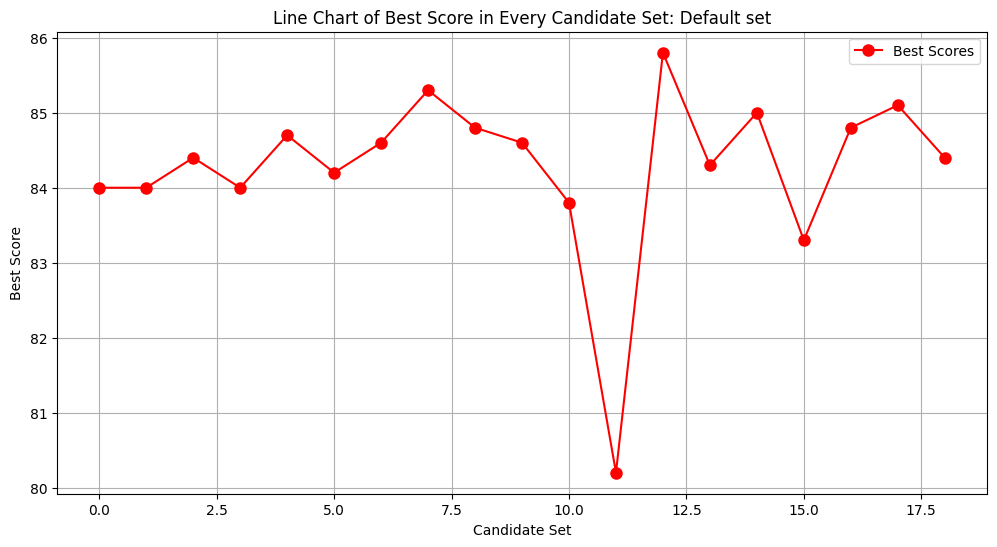

In [8]:
# Iterate over every 50 items
n = 50
iterations = len(best_score_v1) // n

# Plot only the max values
plt.figure(figsize=(12, 6))
plt.plot(best_score_v1, color='red', marker='o', linestyle='-', markersize=8, label='Best Scores')


# Adding final touches to the plot
plt.title('Line Chart of Best Score in Every Candidate Set: Default set')
plt.xlabel('Candidate Set')
plt.ylabel('Best Score')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
optimized_program_metrics = evaluate(optimized_program)

Average Metric: 42.90000000000002 / 50  (85.8): 100%|██████████| 50/50 [00:00<00:00, 200.62it/s]


Average Metric: 42.90000000000002 / 50  (85.8%)


In [ ]:
results = pd.DataFrame()
for example in training_set:
    result = optimized_program(Comment=example['Comment'])
    # Convert result.Descriptions to a Series for concatenation
    optimized_result = pd.concat([pd.Series(example['Comment']), pd.Series(result.Descriptions)], axis=1)
    results = pd.concat([results, optimized_result], ignore_index=True)
results = results.rename(columns={0: 'Comment', 1: 'Descriptions'}) #Rename columns to avoid duplicates

In [ ]:
results

,Comment,Descriptions
0,The 13 year old girl in me loved this place. T...,The reviewer finds the restaurant fun and appe...
1,As long as you know what you're getting yourse...,"The reviewer finds the food lacking, with only..."
2,Went today for my fiancé birthday and I must s...,The reviewer had a wonderful birthday experien...
3,"Love this place, best street food in NY. If yo...","The reviewer loves the restaurant, declaring i..."
4,Since you're wondering...\nEvery single time I...,"The reviewer consistently enjoys the large, we..."
...,...,...
95,So bot what it is cracked up to be\nWaste of t...,The reviewer finds the pizza disappointing and...
96,I tried the artichoke pizza and it was a cream...,The reviewer finds the artichoke pizza to be a...
97,"Incredible food, and the staff was amazing. Lo...",The reviewer praises the incredible food and a...
98,The best pad thai I've ever had!! A true mom a...,The reviewer declares the pad thai as the best...


In [ ]:
import pickle

with open('optimized_v1_default.pkl', 'wb') as f:
    pickle.dump(results, f)

- **metric** (callable, optional): Metric function to evaluate examples during bootstrapping. Defaults to None.
- **teacher_settings** (dict, optional): Settings for teacher predictor. Defaults to an empty dictionary.
- **max_bootstrapped_demos** (int, optional): Maximum number of bootstrapped demonstrations per predictor. Defaults to 4.
- **max_labeled_demos** (int, optional): Maximum number of labeled demonstrations per predictor. Defaults to 16.
- **max_rounds** (int, optional): Maximum number of bootstrapping rounds. Defaults to 1.
- **num_candidate_programs** (int): Number of candidate programs to generate during random search. Defaults to 16.
- **num_threads** (int): Number of threads used for evaluation during random search. Defaults to 6.
- **max_errors** (int): Maximum errors permitted during evaluation. Halts run with the latest error message. Defaults to 10. Configure to 1 if no evaluation run error is desired.
- **stop_at_score** (float, optional): Score threshold for random search to stop early. Defaults to None.
- **metric_threshold** (float, optional): Score threshold for metric to determine successful example. Defaults to None.

## V2

In [ ]:
# Set up the optimizer: we want to "bootstrap" (i.e., self-generate) 8-shot examples of your program's steps.
# The optimizer will repeat this 10 times (plus some initial attempts) before selecting its best attempt on the devset.
config = dict(max_bootstrapped_demos=8)

teleprompter = BootstrapFewShotWithRandomSearch(metric=metric, **config)
optimized_program_v2 = teleprompter.compile(Topics_in_reviews(), trainset=training_set,valset=devset)

Going to sample between 1 and 8 traces per predictor.
Will attempt to train 16 candidate sets.


Average Metric: 42.00000000000002 / 50  (84.0): 100%|██████████| 50/50 [00:00<00:00, 694.00it/s]


Average Metric: 42.00000000000002 / 50  (84.0%)
Score: 84.0 for set: [0, 0]
New best score: 84.0 for seed -3
Scores so far: [84.0]
Best score: 84.0


Average Metric: 42.00000000000003 / 50  (84.0): 100%|██████████| 50/50 [00:00<00:00, 773.29it/s]


Average Metric: 42.00000000000003 / 50  (84.0%)
Score: 84.0 for set: [16, 16]
Scores so far: [84.0, 84.0]
Best score: 84.0


  8%|▊         | 8/100 [00:01<00:15,  5.96it/s]


Bootstrapped 8 full traces after 9 examples in round 0.


Average Metric: 42.20000000000002 / 50  (84.4): 100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


Average Metric: 42.20000000000002 / 50  (84.4%)
Score: 84.4 for set: [16, 16]
New best score: 84.4 for seed -1
Scores so far: [84.0, 84.0, 84.4]
Best score: 84.4
Average of max per entry across top 1 scores: 0.8440000000000003
Average of max per entry across top 2 scores: 0.8790000000000003
Average of max per entry across top 3 scores: 0.8920000000000003
Average of max per entry across top 5 scores: 0.8920000000000003
Average of max per entry across top 8 scores: 0.8920000000000003
Average of max per entry across top 9999 scores: 0.8920000000000003


  7%|▋         | 7/100 [00:07<01:40,  1.08s/it]


Bootstrapped 7 full traces after 8 examples in round 0.


Average Metric: 42.15000000000001 / 50  (84.3): 100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Average Metric: 42.15000000000001 / 50  (84.3%)
Score: 84.3 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.3]
Best score: 84.4
Average of max per entry across top 1 scores: 0.8440000000000003
Average of max per entry across top 2 scores: 0.8730000000000004
Average of max per entry across top 3 scores: 0.8960000000000002
Average of max per entry across top 5 scores: 0.9030000000000002
Average of max per entry across top 8 scores: 0.9030000000000002
Average of max per entry across top 9999 scores: 0.9030000000000002


  3%|▎         | 3/100 [00:09<05:01,  3.11s/it]


Bootstrapped 3 full traces after 4 examples in round 0.


Average Metric: 42.35000000000002 / 50  (84.7): 100%|██████████| 50/50 [00:51<00:00,  1.04s/it]


Average Metric: 42.35000000000002 / 50  (84.7%)
Score: 84.7 for set: [16, 16]
New best score: 84.7 for seed 1
Scores so far: [84.0, 84.0, 84.4, 84.3, 84.7]
Best score: 84.7
Average of max per entry across top 1 scores: 0.8470000000000004
Average of max per entry across top 2 scores: 0.8770000000000004
Average of max per entry across top 3 scores: 0.8900000000000002
Average of max per entry across top 5 scores: 0.9130000000000003
Average of max per entry across top 8 scores: 0.9130000000000003
Average of max per entry across top 9999 scores: 0.9130000000000003


  1%|          | 1/100 [00:00<00:00, 225.33it/s]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 42.10000000000002 / 50  (84.2): 100%|██████████| 50/50 [00:00<00:00, 756.00it/s]


Average Metric: 42.10000000000002 / 50  (84.2%)
Score: 84.2 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.3, 84.7, 84.2]
Best score: 84.7
Average of max per entry across top 1 scores: 0.8470000000000004
Average of max per entry across top 2 scores: 0.8770000000000004
Average of max per entry across top 3 scores: 0.8900000000000002
Average of max per entry across top 5 scores: 0.9130000000000003
Average of max per entry across top 8 scores: 0.9170000000000001
Average of max per entry across top 9999 scores: 0.9170000000000001


  4%|▍         | 4/100 [00:07<02:53,  1.81s/it]


Bootstrapped 4 full traces after 5 examples in round 0.


Average Metric: 42.60000000000001 / 50  (85.2): 100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


Average Metric: 42.60000000000001 / 50  (85.2%)
Score: 85.2 for set: [16, 16]
New best score: 85.2 for seed 3
Scores so far: [84.0, 84.0, 84.4, 84.3, 84.7, 84.2, 85.2]
Best score: 85.2
Average of max per entry across top 1 scores: 0.8520000000000002
Average of max per entry across top 2 scores: 0.8810000000000003
Average of max per entry across top 3 scores: 0.8930000000000002
Average of max per entry across top 5 scores: 0.912
Average of max per entry across top 8 scores: 0.9250000000000003
Average of max per entry across top 9999 scores: 0.9250000000000003


  4%|▍         | 4/100 [00:00<00:00, 242.45it/s]


Bootstrapped 4 full traces after 5 examples in round 0.


Average Metric: 42.25000000000002 / 50  (84.5): 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


Average Metric: 42.25000000000002 / 50  (84.5%)
Score: 84.5 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.3, 84.7, 84.2, 85.2, 84.5]
Best score: 85.2
Average of max per entry across top 1 scores: 0.8520000000000002
Average of max per entry across top 2 scores: 0.8810000000000003
Average of max per entry across top 3 scores: 0.8940000000000003
Average of max per entry across top 5 scores: 0.9080000000000001
Average of max per entry across top 8 scores: 0.9270000000000003
Average of max per entry across top 9999 scores: 0.9270000000000003


  5%|▌         | 5/100 [00:00<00:00, 346.14it/s]


Bootstrapped 5 full traces after 6 examples in round 0.


Average Metric: 43.050000000000026 / 50  (86.1): 100%|██████████| 50/50 [00:53<00:00,  1.06s/it]


Average Metric: 43.050000000000026 / 50  (86.1%)
Score: 86.1 for set: [16, 16]
New best score: 86.1 for seed 5
Scores so far: [84.0, 84.0, 84.4, 84.3, 84.7, 84.2, 85.2, 84.5, 86.1]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000005
Average of max per entry across top 2 scores: 0.8820000000000003
Average of max per entry across top 3 scores: 0.8950000000000002
Average of max per entry across top 5 scores: 0.9110000000000003
Average of max per entry across top 8 scores: 0.9280000000000004
Average of max per entry across top 9999 scores: 0.9300000000000003


  2%|▏         | 2/100 [00:07<05:44,  3.52s/it]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 42.450000000000024 / 50  (84.9): 100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


Average Metric: 42.450000000000024 / 50  (84.9%)
Score: 84.9 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.3, 84.7, 84.2, 85.2, 84.5, 86.1, 84.9]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000005
Average of max per entry across top 2 scores: 0.8820000000000003
Average of max per entry across top 3 scores: 0.8970000000000004
Average of max per entry across top 5 scores: 0.9070000000000005
Average of max per entry across top 8 scores: 0.9240000000000004
Average of max per entry across top 9999 scores: 0.9320000000000003


  6%|▌         | 6/100 [00:15<04:06,  2.62s/it]


Bootstrapped 6 full traces after 7 examples in round 0.


Average Metric: 41.90000000000001 / 50  (83.8): 100%|██████████| 50/50 [00:56<00:00,  1.14s/it]


Average Metric: 41.90000000000001 / 50  (83.8%)
Score: 83.8 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.3, 84.7, 84.2, 85.2, 84.5, 86.1, 84.9, 83.8]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000005
Average of max per entry across top 2 scores: 0.8820000000000003
Average of max per entry across top 3 scores: 0.8970000000000004
Average of max per entry across top 5 scores: 0.9070000000000005
Average of max per entry across top 8 scores: 0.9240000000000004
Average of max per entry across top 9999 scores: 0.9350000000000003


  4%|▍         | 4/100 [00:07<03:04,  1.92s/it]


Bootstrapped 4 full traces after 5 examples in round 0.


Average Metric: 42.50000000000002 / 50  (85.0): 100%|██████████| 50/50 [00:59<00:00,  1.20s/it]


Average Metric: 42.50000000000002 / 50  (85.0%)
Score: 85.0 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.3, 84.7, 84.2, 85.2, 84.5, 86.1, 84.9, 83.8, 85.0]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000005
Average of max per entry across top 2 scores: 0.8820000000000003
Average of max per entry across top 3 scores: 0.8960000000000002
Average of max per entry across top 5 scores: 0.9100000000000001
Average of max per entry across top 8 scores: 0.924
Average of max per entry across top 9999 scores: 0.9380000000000003


  8%|▊         | 8/100 [00:11<02:12,  1.44s/it]


Bootstrapped 8 full traces after 9 examples in round 0.


Average Metric: 42.40000000000001 / 50  (84.8): 100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


Average Metric: 42.40000000000001 / 50  (84.8%)
Score: 84.8 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.3, 84.7, 84.2, 85.2, 84.5, 86.1, 84.9, 83.8, 85.0, 84.8]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000005
Average of max per entry across top 2 scores: 0.8820000000000003
Average of max per entry across top 3 scores: 0.8960000000000002
Average of max per entry across top 5 scores: 0.9100000000000001
Average of max per entry across top 8 scores: 0.9240000000000002
Average of max per entry across top 9999 scores: 0.9400000000000003


  1%|          | 1/100 [00:00<00:00, 270.48it/s]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 42.15000000000001 / 50  (84.3): 100%|██████████| 50/50 [00:00<00:00, 411.14it/s]


Average Metric: 42.15000000000001 / 50  (84.3%)
Score: 84.3 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.3, 84.7, 84.2, 85.2, 84.5, 86.1, 84.9, 83.8, 85.0, 84.8, 84.3]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000005
Average of max per entry across top 2 scores: 0.8820000000000003
Average of max per entry across top 3 scores: 0.8960000000000002
Average of max per entry across top 5 scores: 0.9100000000000001
Average of max per entry across top 8 scores: 0.9240000000000002
Average of max per entry across top 9999 scores: 0.9400000000000003


  8%|▊         | 8/100 [00:20<04:00,  2.61s/it]


Bootstrapped 8 full traces after 9 examples in round 0.


Average Metric: 42.35000000000002 / 50  (84.7): 100%|██████████| 50/50 [00:55<00:00,  1.12s/it]


Average Metric: 42.35000000000002 / 50  (84.7%)
Score: 84.7 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.3, 84.7, 84.2, 85.2, 84.5, 86.1, 84.9, 83.8, 85.0, 84.8, 84.3, 84.7]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000005
Average of max per entry across top 2 scores: 0.8820000000000003
Average of max per entry across top 3 scores: 0.8960000000000002
Average of max per entry across top 5 scores: 0.9100000000000001
Average of max per entry across top 8 scores: 0.9190000000000004
Average of max per entry across top 9999 scores: 0.9400000000000003


  8%|▊         | 8/100 [00:04<00:52,  1.77it/s]


Bootstrapped 8 full traces after 9 examples in round 0.


Average Metric: 42.10000000000001 / 50  (84.2): 100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


Average Metric: 42.10000000000001 / 50  (84.2%)
Score: 84.2 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.3, 84.7, 84.2, 85.2, 84.5, 86.1, 84.9, 83.8, 85.0, 84.8, 84.3, 84.7, 84.2]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000005
Average of max per entry across top 2 scores: 0.8820000000000003
Average of max per entry across top 3 scores: 0.8960000000000002
Average of max per entry across top 5 scores: 0.9100000000000001
Average of max per entry across top 8 scores: 0.9190000000000004
Average of max per entry across top 9999 scores: 0.9400000000000003


  5%|▌         | 5/100 [00:20<06:31,  4.12s/it]


Bootstrapped 5 full traces after 6 examples in round 0.


Average Metric: 42.25000000000003 / 50  (84.5): 100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


Average Metric: 42.25000000000003 / 50  (84.5%)
Score: 84.5 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.3, 84.7, 84.2, 85.2, 84.5, 86.1, 84.9, 83.8, 85.0, 84.8, 84.3, 84.7, 84.2, 84.5]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000005
Average of max per entry across top 2 scores: 0.8820000000000003
Average of max per entry across top 3 scores: 0.8960000000000002
Average of max per entry across top 5 scores: 0.9100000000000001
Average of max per entry across top 8 scores: 0.9190000000000004
Average of max per entry across top 9999 scores: 0.9400000000000003


  2%|▏         | 2/100 [00:06<04:57,  3.03s/it]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 42.05000000000002 / 50  (84.1): 100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


Average Metric: 42.05000000000002 / 50  (84.1%)
Score: 84.1 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.3, 84.7, 84.2, 85.2, 84.5, 86.1, 84.9, 83.8, 85.0, 84.8, 84.3, 84.7, 84.2, 84.5, 84.1]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000005
Average of max per entry across top 2 scores: 0.8820000000000003
Average of max per entry across top 3 scores: 0.8960000000000002
Average of max per entry across top 5 scores: 0.9100000000000001
Average of max per entry across top 8 scores: 0.9190000000000004
Average of max per entry across top 9999 scores: 0.9400000000000003


  4%|▍         | 4/100 [00:00<00:00, 192.12it/s]


Bootstrapped 4 full traces after 5 examples in round 0.


Average Metric: 42.65000000000002 / 50  (85.3): 100%|██████████| 50/50 [00:59<00:00,  1.20s/it]

Average Metric: 42.65000000000002 / 50  (85.3%)
Score: 85.3 for set: [16, 16]
Scores so far: [84.0, 84.0, 84.4, 84.3, 84.7, 84.2, 85.2, 84.5, 86.1, 84.9, 83.8, 85.0, 84.8, 84.3, 84.7, 84.2, 84.5, 84.1, 85.3]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000005
Average of max per entry across top 2 scores: 0.8770000000000003
Average of max per entry across top 3 scores: 0.8910000000000003
Average of max per entry across top 5 scores: 0.9110000000000003
Average of max per entry across top 8 scores: 0.9180000000000001
Average of max per entry across top 9999 scores: 0.9400000000000003
19 candidate programs found.


In [ ]:
optimized_program_v2_metrics = evaluate(optimized_program_v2)

Average Metric: 43.05000000000002 / 50  (86.1): 100%|██████████| 50/50 [00:00<00:00, 186.10it/s]

Average Metric: 43.05000000000002 / 50  (86.1%)


In [9]:
best_score_v2 = [84.0, 84.0, 84.4, 84.3, 84.7, 84.2, 85.2, 84.5, 86.1, 84.9, 83.8, 85.0, 84.8, 84.3, 84.7, 84.2, 84.5, 84.1, 85.3]

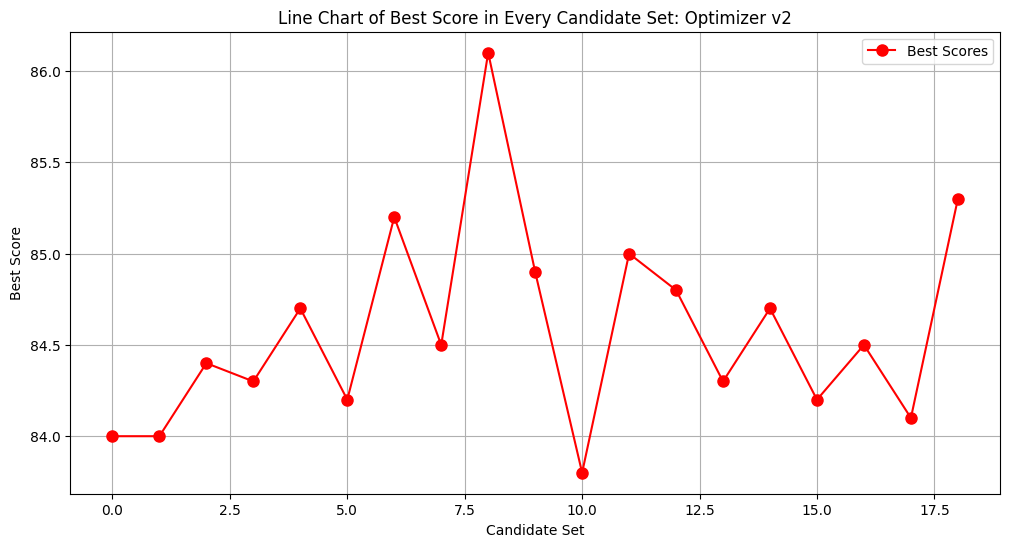

In [15]:
# Iterate over every 50 items
n = 50
iterations = len(best_score_v2) // n

# Plot only the max values
plt.figure(figsize=(12, 6))
plt.plot(best_score_v2, color='red', marker='o', linestyle='-', markersize=8, label='Best Scores')


# Adding final touches to the plot
plt.title('Line Chart of Best Score in Every Candidate Set: Optimizer v2')
plt.xlabel('Candidate Set')
plt.ylabel('Best Score')
plt.grid(True)
plt.legend()
plt.show()

## V3

In [ ]:
config = dict(max_bootstrapped_demos=16)

teleprompter = BootstrapFewShotWithRandomSearch(metric=metric, **config)
optimized_program_v3 = teleprompter.compile(Topics_in_reviews(), trainset=training_set,valset=devset)

/usr/local/lib/python3.10/dist-packages/joblib/memory.py:655: JobLibCollisionWarning: Possible name collisions between functions 'v1_cached_gpt3_turbo_request_v2' (/usr/local/lib/python3.10/dist-packages/dsp/modules/gpt3.py:-1) and 'v1_cached_gpt3_turbo_request_v2' (/usr/local/lib/python3.10/dist-packages/dsp/modules/gpt3.py:254)
  return self._cached_call(args, kwargs)[0]


Going to sample between 1 and 16 traces per predictor.
Will attempt to train 16 candidate sets.


Average Metric: 42.05 / 50  (84.1): 100%|██████████| 50/50 [01:32<00:00,  1.84s/it]


Average Metric: 42.05 / 50  (84.1%)
Score: 84.1 for set: [0, 0]
New best score: 84.1 for seed -3
Scores so far: [84.1]
Best score: 84.1


Average Metric: 42.05000000000001 / 50  (84.1): 100%|██████████| 50/50 [00:00<00:00, 314.82it/s]


Average Metric: 42.05000000000001 / 50  (84.1%)
Score: 84.1 for set: [16, 16]
Scores so far: [84.1, 84.1]
Best score: 84.1


 16%|█▌        | 16/100 [01:19<06:56,  4.95s/it]


Bootstrapped 16 full traces after 17 examples in round 0.


Average Metric: 30.800000000000008 / 37  (83.2):  74%|███████▍  | 37/50 [00:35<00:12,  1.08it/s]

Backing off 0.1 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 32.50000000000001 / 39  (83.3):  78%|███████▊  | 39/50 [00:36<00:08,  1.27it/s]INFO:backoff:Backing off request(...) for 1.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198927, Requested 5493. Please try again in 1.326s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 0.0s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198936, Requested 5468. Please try again in 1.321s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 1.3 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 0.0 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.4s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197594, Requested 5464. Please try again in 917ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.4 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 1.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197471, Requested 5468. Please try again in 881ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 1.9 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 33.35000000000001 / 40  (83.4):  80%|████████  | 40/50 [00:39<00:14,  1.49s/it]INFO:backoff:Backing off request(...) for 1.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198683, Requested 5493. Please try again in 1.252s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 1.1 seconds after 3 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 34.10000000000001 / 41  (83.2):  82%|████████▏ | 41/50 [00:41<00:13,  1.52s/it]INFO:backoff:Backing off request(...) for 1.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198881, Requested 5464. Please try again in 1.303s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 1.2 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 34.900000000000006 / 42  (83.1):  84%|████████▍ | 42/50 [00:42<00:09,  1.24s/it]INFO:backoff:Backing off request(...) for 0.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 194799, Requested 5462. Please try again in 78ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 4.7s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 194756, Requested 5493. Please try again in 74ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 0.5s (openai.Rat

Backing off 0.9 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 4.7 seconds after 4 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 0.5 seconds after 3 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.7s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198819, Requested 5434. Please try again in 1.275s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.7 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 36.650000000000006 / 44  (83.3):  86%|████████▌ | 43/50 [00:46<00:15,  2.26s/it]INFO:backoff:Backing off request(...) for 7.6s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197844, Requested 5464. Please try again in 992ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 7.6 seconds after 4 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197610, Requested 5488. Please try again in 929ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 1.0s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197559, Requested 5533. Please try again in 927ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.2 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 1.0 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 38.35000000000001 / 46  (83.4):  92%|█████████▏| 46/50 [00:52<00:07,  1.91s/it]INFO:backoff:Backing off request(...) for 1.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 196889, Requested 5533. Please try again in 726ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 1.2 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 41.70000000000001 / 50  (83.4): 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]


Average Metric: 41.70000000000001 / 50  (83.4%)
Score: 83.4 for set: [16, 16]
Scores so far: [84.1, 84.1, 83.4]
Best score: 84.1
Average of max per entry across top 1 scores: 0.841
Average of max per entry across top 2 scores: 0.8750000000000004
Average of max per entry across top 3 scores: 0.8860000000000003
Average of max per entry across top 5 scores: 0.8860000000000003
Average of max per entry across top 8 scores: 0.8860000000000003
Average of max per entry across top 9999 scores: 0.8860000000000003


 13%|█▎        | 13/100 [00:38<04:19,  2.98s/it]


Bootstrapped 13 full traces after 14 examples in round 0.


Average Metric: 34.95000000000001 / 42  (83.2):  84%|████████▍ | 42/50 [00:36<00:06,  1.30it/s]INFO:backoff:Backing off request(...) for 0.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198879, Requested 3985. Please try again in 859ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.1 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 35.80000000000001 / 43  (83.3):  86%|████████▌ | 43/50 [00:37<00:05,  1.27it/s]INFO:backoff:Backing off request(...) for 0.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 196245, Requested 3974. Please try again in 65ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.3 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 199754, Requested 3985. Please try again in 1.121s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.1 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 3.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 199776, Requested 3985. Please try again in 1.128s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Average Metric: 36.65000000000001 / 44  (83.3):  88%|████████▊ | 44/50 [00:40<00:08,  1.42s/it]

Backing off 3.9 seconds after 3 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 41.75000000000002 / 50  (83.5): 100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


Average Metric: 41.75000000000002 / 50  (83.5%)
Score: 83.5 for set: [16, 16]
Scores so far: [84.1, 84.1, 83.4, 83.5]
Best score: 84.1
Average of max per entry across top 1 scores: 0.841
Average of max per entry across top 2 scores: 0.8750000000000004
Average of max per entry across top 3 scores: 0.8890000000000003
Average of max per entry across top 5 scores: 0.8960000000000004
Average of max per entry across top 8 scores: 0.8960000000000004
Average of max per entry across top 9999 scores: 0.8960000000000004


  5%|▌         | 5/100 [00:22<07:12,  4.56s/it]


Bootstrapped 5 full traces after 6 examples in round 0.


Average Metric: 42.45000000000002 / 50  (84.9): 100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Average Metric: 42.45000000000002 / 50  (84.9%)
Score: 84.9 for set: [16, 16]
New best score: 84.9 for seed 1
Scores so far: [84.1, 84.1, 83.4, 83.5, 84.9]
Best score: 84.9
Average of max per entry across top 1 scores: 0.8490000000000003
Average of max per entry across top 2 scores: 0.8810000000000003
Average of max per entry across top 3 scores: 0.8940000000000003
Average of max per entry across top 5 scores: 0.9080000000000003
Average of max per entry across top 8 scores: 0.9080000000000003
Average of max per entry across top 9999 scores: 0.9080000000000003


  2%|▏         | 2/100 [00:07<06:27,  3.95s/it]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 42.900000000000006 / 50  (85.8): 100%|██████████| 50/50 [00:54<00:00,  1.08s/it]


Average Metric: 42.900000000000006 / 50  (85.8%)
Score: 85.8 for set: [16, 16]
New best score: 85.8 for seed 2
Scores so far: [84.1, 84.1, 83.4, 83.5, 84.9, 85.8]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000001
Average of max per entry across top 2 scores: 0.8830000000000002
Average of max per entry across top 3 scores: 0.8990000000000002
Average of max per entry across top 5 scores: 0.9100000000000005
Average of max per entry across top 8 scores: 0.9130000000000003
Average of max per entry across top 9999 scores: 0.9130000000000003


  8%|▊         | 8/100 [00:24<04:41,  3.06s/it]


Bootstrapped 8 full traces after 9 examples in round 0.


Average Metric: 42.60000000000003 / 50  (85.2): 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]


Average Metric: 42.60000000000003 / 50  (85.2%)
Score: 85.2 for set: [16, 16]
Scores so far: [84.1, 84.1, 83.4, 83.5, 84.9, 85.8, 85.2]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000001
Average of max per entry across top 2 scores: 0.8880000000000003
Average of max per entry across top 3 scores: 0.9030000000000002
Average of max per entry across top 5 scores: 0.9160000000000003
Average of max per entry across top 8 scores: 0.9220000000000003
Average of max per entry across top 9999 scores: 0.9220000000000003


  8%|▊         | 8/100 [00:30<05:52,  3.83s/it]


Bootstrapped 8 full traces after 9 examples in round 0.


Average Metric: 42.45000000000001 / 50  (84.9): 100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


Average Metric: 42.45000000000001 / 50  (84.9%)
Score: 84.9 for set: [16, 16]
Scores so far: [84.1, 84.1, 83.4, 83.5, 84.9, 85.8, 85.2, 84.9]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000001
Average of max per entry across top 2 scores: 0.8880000000000003
Average of max per entry across top 3 scores: 0.9030000000000002
Average of max per entry across top 5 scores: 0.9140000000000001
Average of max per entry across top 8 scores: 0.9240000000000002
Average of max per entry across top 9999 scores: 0.9240000000000002


  9%|▉         | 9/100 [00:30<05:07,  3.38s/it]


Bootstrapped 9 full traces after 10 examples in round 0.


Average Metric: 42.300000000000026 / 50  (84.6): 100%|██████████| 50/50 [00:47<00:00,  1.04it/s]


Average Metric: 42.300000000000026 / 50  (84.6%)
Score: 84.6 for set: [16, 16]
Scores so far: [84.1, 84.1, 83.4, 83.5, 84.9, 85.8, 85.2, 84.9, 84.6]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000001
Average of max per entry across top 2 scores: 0.8880000000000003
Average of max per entry across top 3 scores: 0.9030000000000002
Average of max per entry across top 5 scores: 0.9120000000000004
Average of max per entry across top 8 scores: 0.9270000000000002
Average of max per entry across top 9999 scores: 0.9270000000000002


  3%|▎         | 3/100 [00:09<05:08,  3.18s/it]


Bootstrapped 3 full traces after 4 examples in round 0.


Average Metric: 42.40000000000003 / 50  (84.8): 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


Average Metric: 42.40000000000003 / 50  (84.8%)
Score: 84.8 for set: [16, 16]
Scores so far: [84.1, 84.1, 83.4, 83.5, 84.9, 85.8, 85.2, 84.9, 84.6, 84.8]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000001
Average of max per entry across top 2 scores: 0.8880000000000003
Average of max per entry across top 3 scores: 0.9030000000000002
Average of max per entry across top 5 scores: 0.9120000000000001
Average of max per entry across top 8 scores: 0.9240000000000002
Average of max per entry across top 9999 scores: 0.9290000000000002


 11%|█         | 11/100 [00:36<04:55,  3.32s/it]


Bootstrapped 11 full traces after 12 examples in round 0.


Average Metric: 41.90000000000001 / 50  (83.8): 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


Average Metric: 41.90000000000001 / 50  (83.8%)
Score: 83.8 for set: [16, 16]
Scores so far: [84.1, 84.1, 83.4, 83.5, 84.9, 85.8, 85.2, 84.9, 84.6, 84.8, 83.8]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000001
Average of max per entry across top 2 scores: 0.8880000000000003
Average of max per entry across top 3 scores: 0.9030000000000002
Average of max per entry across top 5 scores: 0.9120000000000001
Average of max per entry across top 8 scores: 0.9240000000000002
Average of max per entry across top 9999 scores: 0.9320000000000003


  8%|▊         | 8/100 [00:25<04:49,  3.15s/it]


Bootstrapped 8 full traces after 9 examples in round 0.


Average Metric: 42.40000000000002 / 50  (84.8): 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Average Metric: 42.40000000000002 / 50  (84.8%)
Score: 84.8 for set: [16, 16]
Scores so far: [84.1, 84.1, 83.4, 83.5, 84.9, 85.8, 85.2, 84.9, 84.6, 84.8, 83.8, 84.8]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000001
Average of max per entry across top 2 scores: 0.8880000000000003
Average of max per entry across top 3 scores: 0.9030000000000002
Average of max per entry across top 5 scores: 0.9120000000000001
Average of max per entry across top 8 scores: 0.9230000000000003
Average of max per entry across top 9999 scores: 0.9340000000000004


 15%|█▌        | 15/100 [00:21<02:01,  1.43s/it]


Bootstrapped 15 full traces after 16 examples in round 0.


Average Metric: 32.50000000000001 / 38  (85.5):  76%|███████▌  | 38/50 [00:35<00:07,  1.65it/s]INFO:backoff:Backing off request(...) for 0.5s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 199767, Requested 5133. Please try again in 1.47s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.5 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 199645, Requested 5248. Please try again in 1.467s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.8 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 195644, Requested 5122. Please try again in 229ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.1 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 34.10000000000001 / 40  (85.3):  80%|████████  | 40/50 [00:38<00:09,  1.04it/s]INFO:backoff:Backing off request(...) for 0.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 196321, Requested 5209. Please try again in 459ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 1.6s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 196319, Requested 5248. Please try again in 470ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.8 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 1.6 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.6s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198114, Requested 5216. Please try again in 999ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 0.0s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197913, Requested 5371. Please try again in 985ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.6 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 0.0 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 34.85000000000001 / 41  (85.0):  82%|████████▏ | 41/50 [00:40<00:12,  1.44s/it]INFO:backoff:Backing off request(...) for 0.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 199504, Requested 5371. Please try again in 1.462s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.3 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 1.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197908, Requested 5209. Please try again in 935ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 1.3 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 35.60000000000001 / 42  (84.8):  84%|████████▍ | 42/50 [00:42<00:12,  1.60s/it]INFO:backoff:Backing off request(...) for 1.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197344, Requested 5248. Please try again in 777ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 1.8 seconds after 3 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 1.6s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197998, Requested 5371. Please try again in 1.01s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 1.6 seconds after 3 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 1.0s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198917, Requested 5132. Please try again in 1.214s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 0.7s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198866, Requested 5206. Please try again in 1.221s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 1.0 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 0.7 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 37.500000000000014 / 44  (85.2):  88%|████████▊ | 44/50 [00:46<00:09,  1.61s/it]INFO:backoff:Backing off request(...) for 1.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 196727, Requested 5206. Please try again in 579ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 4.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 196612, Requested 5371. Please try again in 594ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 1.9 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 4.9 seconds after 4 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 38.350000000000016 / 45  (85.2):  90%|█████████ | 45/50 [00:48<00:08,  1.73s/it]INFO:backoff:Backing off request(...) for 0.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197373, Requested 5236. Please try again in 782ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.9 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 1.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 199336, Requested 5236. Please try again in 1.371s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Average Metric: 40.05000000000002 / 47  (85.2):  92%|█████████▏| 46/50 [00:53<00:10,  2.68s/it]

Backing off 1.9 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 42.60000000000002 / 50  (85.2): 100%|██████████| 50/50 [00:58<00:00,  1.18s/it]


Average Metric: 42.60000000000002 / 50  (85.2%)
Score: 85.2 for set: [16, 16]
Scores so far: [84.1, 84.1, 83.4, 83.5, 84.9, 85.8, 85.2, 84.9, 84.6, 84.8, 83.8, 84.8, 85.2]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000001
Average of max per entry across top 2 scores: 0.8880000000000003
Average of max per entry across top 3 scores: 0.9010000000000005
Average of max per entry across top 5 scores: 0.9120000000000004
Average of max per entry across top 8 scores: 0.9250000000000004
Average of max per entry across top 9999 scores: 0.9360000000000004


  2%|▏         | 2/100 [00:00<00:00, 218.31it/s]


Bootstrapped 2 full traces after 3 examples in round 0.


Average Metric: 42.55000000000002 / 50  (85.1): 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


Average Metric: 42.55000000000002 / 50  (85.1%)
Score: 85.1 for set: [16, 16]
Scores so far: [84.1, 84.1, 83.4, 83.5, 84.9, 85.8, 85.2, 84.9, 84.6, 84.8, 83.8, 84.8, 85.2, 85.1]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000001
Average of max per entry across top 2 scores: 0.8880000000000003
Average of max per entry across top 3 scores: 0.9010000000000005
Average of max per entry across top 5 scores: 0.9170000000000003
Average of max per entry across top 8 scores: 0.9290000000000005
Average of max per entry across top 9999 scores: 0.9380000000000004


 15%|█▌        | 15/100 [00:29<02:49,  1.99s/it]


Bootstrapped 15 full traces after 16 examples in round 0.


Average Metric: 23.5 / 28  (83.9):  56%|█████▌    | 28/50 [00:23<00:12,  1.82it/s]INFO:backoff:Backing off request(...) for 0.5s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197135, Requested 5370. Please try again in 751ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 0.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197141, Requested 5156. Please try again in 689ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.5 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 0.2 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 26.000000000000004 / 31  (83.9):  62%|██████▏   | 31/50 [00:27<00:13,  1.41it/s]INFO:backoff:Backing off request(...) for 2.0s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 194935, Requested 5370. Please try again in 91ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 2.0 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 199273, Requested 5320. Please try again in 1.377s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.1 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198532, Requested 5136. Please try again in 1.1s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.8 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 26.850000000000005 / 32  (83.9):  64%|██████▍   | 32/50 [00:29<00:22,  1.24s/it]INFO:backoff:Backing off request(...) for 1.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 199695, Requested 5320. Please try again in 1.504s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 1.2 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.4s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197642, Requested 5139. Please try again in 834ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.4 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 27.700000000000006 / 33  (83.9):  66%|██████▌   | 33/50 [00:31<00:26,  1.54s/it]INFO:backoff:Backing off request(...) for 1.7s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198647, Requested 5320. Please try again in 1.19s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 1.6s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198632, Requested 5370. Please try again in 1.2s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 1.7 seconds after 3 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 1.6 seconds after 3 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 1.0s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198499, Requested 5419. Please try again in 1.175s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 1.0 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 29.550000000000004 / 35  (84.4):  70%|███████   | 35/50 [00:34<00:21,  1.40s/it]INFO:backoff:Backing off request(...) for 3.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 199756, Requested 5320. Please try again in 1.522s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 2.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 199700, Requested 5370. Please try again in 1.521s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 3.3 seconds after 4 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 2.2 seconds after 4 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 30.350000000000005 / 36  (84.3):  72%|███████▏  | 36/50 [00:36<00:19,  1.41s/it]INFO:backoff:Backing off request(...) for 0.4s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 195402, Requested 5419. Please try again in 246ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.4 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.5s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198137, Requested 5135. Please try again in 981ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.5 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 8.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198565, Requested 5370. Please try again in 1.18s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 0.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198536, Requested 5419. Please try again in 1.186s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 8.8 seconds after 5 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 0.9 seconds after 3 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 31.200000000000006 / 37  (84.3):  74%|███████▍  | 37/50 [00:40<00:30,  2.36s/it]INFO:backoff:Backing off request(...) for 13.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198310, Requested 5320. Please try again in 1.089s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 13.1 seconds after 5 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 32.900000000000006 / 39  (84.4):  78%|███████▊  | 39/50 [00:43<00:18,  1.69s/it]INFO:backoff:Backing off request(...) for 3.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198779, Requested 5419. Please try again in 1.259s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 3.1 seconds after 4 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 33.85000000000001 / 40  (84.6):  80%|████████  | 40/50 [00:45<00:17,  1.75s/it]INFO:backoff:Backing off request(...) for 0.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197279, Requested 5492. Please try again in 831ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.3 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 35.60000000000001 / 42  (84.8):  84%|████████▍ | 42/50 [00:49<00:14,  1.83s/it]

Backing off 3.5 seconds after 5 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197771, Requested 5367. Please try again in 941ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.2 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 36.45000000000001 / 43  (84.8):  86%|████████▌ | 43/50 [00:52<00:15,  2.24s/it]INFO:backoff:Backing off request(...) for 0.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 195241, Requested 5367. Please try again in 182ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.9 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.7s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198768, Requested 5266. Please try again in 1.21s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 3.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198653, Requested 5419. Please try again in 1.221s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.7 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 3.9 seconds after 6 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 38.15000000000001 / 45  (84.8):  90%|█████████ | 45/50 [00:57<00:10,  2.19s/it]INFO:backoff:Backing off request(...) for 0.0s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 195498, Requested 5311. Please try again in 242ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 0.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 195425, Requested 5367. Please try again in 237ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.0 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 0.8 seconds after 3 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 47.0s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 199731, Requested 5419. Please try again in 1.545s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Average Metric: 39.05000000000001 / 46  (84.9):  92%|█████████▏| 46/50 [01:00<00:10,  2.62s/it]

Backing off 47.0 seconds after 7 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 42.45000000000002 / 50  (84.9): 100%|██████████| 50/50 [01:55<00:00,  2.31s/it]


Average Metric: 42.45000000000002 / 50  (84.9%)
Score: 84.9 for set: [16, 16]
Scores so far: [84.1, 84.1, 83.4, 83.5, 84.9, 85.8, 85.2, 84.9, 84.6, 84.8, 83.8, 84.8, 85.2, 85.1, 84.9]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000001
Average of max per entry across top 2 scores: 0.8880000000000003
Average of max per entry across top 3 scores: 0.9010000000000005
Average of max per entry across top 5 scores: 0.9170000000000003
Average of max per entry across top 8 scores: 0.9280000000000004
Average of max per entry across top 9999 scores: 0.9390000000000005


 16%|█▌        | 16/100 [00:14<01:13,  1.14it/s]


Bootstrapped 16 full traces after 17 examples in round 0.


Average Metric: 34.40000000000001 / 41  (83.9):  80%|████████  | 40/50 [00:34<00:08,  1.17it/s]INFO:backoff:Backing off request(...) for 0.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197279, Requested 4974. Please try again in 675ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 0.5s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198237, Requested 5226. Please try again in 1.038s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.9 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 0.5 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 36.95000000000002 / 44  (84.0):  86%|████████▌ | 43/50 [00:37<00:06,  1.12it/s] INFO:backoff:Backing off request(...) for 1.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 195729, Requested 5226. Please try again in 286ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 1.3 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.5s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 199575, Requested 4974. Please try again in 1.364s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.5 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.5s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198035, Requested 5044. Please try again in 923ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.5 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 38.75000000000002 / 46  (84.2):  92%|█████████▏| 46/50 [00:40<00:03,  1.17it/s]INFO:backoff:Backing off request(...) for 0.5s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197993, Requested 5226. Please try again in 965ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.5 seconds after 3 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 39.60000000000002 / 47  (84.3):  94%|█████████▍| 47/50 [00:43<00:04,  1.51s/it]INFO:backoff:Backing off request(...) for 2.0s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 196593, Requested 5226. Please try again in 545ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 2.0 seconds after 4 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 42.15000000000002 / 50  (84.3): 100%|██████████| 50/50 [00:54<00:00,  1.08s/it]


Average Metric: 42.15000000000002 / 50  (84.3%)
Score: 84.3 for set: [16, 16]
Scores so far: [84.1, 84.1, 83.4, 83.5, 84.9, 85.8, 85.2, 84.9, 84.6, 84.8, 83.8, 84.8, 85.2, 85.1, 84.9, 84.3]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000001
Average of max per entry across top 2 scores: 0.8880000000000003
Average of max per entry across top 3 scores: 0.9010000000000005
Average of max per entry across top 5 scores: 0.9170000000000003
Average of max per entry across top 8 scores: 0.9280000000000004
Average of max per entry across top 9999 scores: 0.9390000000000005


  9%|▉         | 9/100 [00:18<03:08,  2.08s/it]


Bootstrapped 9 full traces after 10 examples in round 0.


Average Metric: 17.1 / 20  (85.5):  40%|████      | 20/50 [00:18<00:25,  1.16it/s]

Backing off 0.1 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.5s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198970, Requested 4309. Please try again in 983ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.5 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 21.250000000000004 / 25  (85.0):  50%|█████     | 25/50 [00:22<00:15,  1.66it/s]

Backing off 0.9 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.5s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197146, Requested 4309. Please try again in 436ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.5 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197661, Requested 4579. Please try again in 672ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Average Metric: 22.150000000000002 / 26  (85.2):  52%|█████▏    | 26/50 [00:24<00:23,  1.02it/s]

Backing off 0.3 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.4s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197516, Requested 4309. Please try again in 547ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 0.7s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197387, Requested 4434. Please try again in 546ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.4 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 0.7 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198464, Requested 4036. Please try again in 750ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Average Metric: 22.900000000000002 / 27  (84.8):  54%|█████▍    | 27/50 [00:26<00:31,  1.35s/it]INFO:backoff:Backing off request(...) for 1.4s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197016, Requested 4579. Please try again in 478ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.1 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 1.4 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 2.9s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197955, Requested 4434. Please try again in 716ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 2.9 seconds after 3 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 199304, Requested 4304. Please try again in 1.082s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.8 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 25.550000000000004 / 30  (85.2):  60%|██████    | 30/50 [00:29<00:19,  1.05it/s]INFO:backoff:Backing off request(...) for 0.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198677, Requested 4579. Please try again in 976ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.3 seconds after 3 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198310, Requested 4401. Please try again in 813ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.1 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 3.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198059, Requested 4434. Please try again in 747ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 7.6s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197826, Requested 4579. Please try again in 721ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 3.2 seconds after 4 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 7.6 seconds after 4 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 1.4s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 199186, Requested 4401. Please try again in 1.076s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 1.4 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 28.050000000000008 / 33  (85.0):  66%|██████▌   | 33/50 [00:36<00:26,  1.57s/it]INFO:backoff:Backing off request(...) for 10.3s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197894, Requested 4434. Please try again in 698ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 10.3 seconds after 5 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.7s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197990, Requested 4502. Please try again in 747ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.7 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 29.85000000000001 / 35  (85.3):  70%|███████   | 35/50 [00:40<00:24,  1.66s/it]INFO:backoff:Backing off request(...) for 2.2s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 196017, Requested 4579. Please try again in 178ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 2.2 seconds after 5 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.6s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198055, Requested 4366. Please try again in 726ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.6 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 31.50000000000001 / 37  (85.1):  74%|███████▍  | 37/50 [00:45<00:26,  2.00s/it]INFO:backoff:Backing off request(...) for 8.7s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 195596, Requested 4579. Please try again in 52ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 8.7 seconds after 6 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 32.35000000000001 / 38  (85.1):  76%|███████▌  | 38/50 [00:46<00:19,  1.65s/it]INFO:backoff:Backing off request(...) for 0.6s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198820, Requested 4329. Please try again in 944ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.6 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 30.5s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197955, Requested 4434. Please try again in 716ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 30.5 seconds after 6 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 34.70000000000001 / 41  (84.6):  82%|████████▏ | 41/50 [00:50<00:11,  1.27s/it]INFO:backoff:Backing off request(...) for 0.5s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197226, Requested 4575. Please try again in 540ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.5 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.7s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198373, Requested 4056. Please try again in 728ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.7 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 1.7s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 198877, Requested 4575. Please try again in 1.035s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 1.7 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 37.40000000000001 / 44  (85.0):  88%|████████▊ | 44/50 [00:55<00:08,  1.43s/it]INFO:backoff:Backing off request(...) for 0.8s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197479, Requested 4349. Please try again in 548ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
INFO:backoff:Backing off request(...) for 1.7s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 197253, Requested 4575. Please try again in 548ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.8 seconds after 1 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}
Backing off 1.7 seconds after 3 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 199532, Requested 4349. Please try again in 1.164s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 0.1 seconds after 2 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


INFO:backoff:Backing off request(...) for 6.1s (openai.RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-IhJfNK5fDnNxBJK0vVZWmTuF on tokens per min (TPM): Limit 200000, Used 199352, Requested 4575. Please try again in 1.178s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})


Backing off 6.1 seconds after 4 tries calling function <function GPT3.request at 0x7a9ced7a24d0> with kwargs {}


Average Metric: 42.700000000000024 / 50  (85.4): 100%|██████████| 50/50 [01:24<00:00,  1.68s/it]


Average Metric: 42.700000000000024 / 50  (85.4%)
Score: 85.4 for set: [16, 16]
Scores so far: [84.1, 84.1, 83.4, 83.5, 84.9, 85.8, 85.2, 84.9, 84.6, 84.8, 83.8, 84.8, 85.2, 85.1, 84.9, 84.3, 85.4]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000001
Average of max per entry across top 2 scores: 0.8890000000000003
Average of max per entry across top 3 scores: 0.9060000000000004
Average of max per entry across top 5 scores: 0.9200000000000004
Average of max per entry across top 8 scores: 0.9340000000000004
Average of max per entry across top 9999 scores: 0.9450000000000004


  4%|▍         | 4/100 [00:00<00:00, 151.16it/s]


Bootstrapped 4 full traces after 5 examples in round 0.


Average Metric: 42.45000000000002 / 50  (84.9): 100%|██████████| 50/50 [00:51<00:00,  1.02s/it]


Average Metric: 42.45000000000002 / 50  (84.9%)
Score: 84.9 for set: [16, 16]
Scores so far: [84.1, 84.1, 83.4, 83.5, 84.9, 85.8, 85.2, 84.9, 84.6, 84.8, 83.8, 84.8, 85.2, 85.1, 84.9, 84.3, 85.4, 84.9]
Best score: 85.8
Average of max per entry across top 1 scores: 0.8580000000000001
Average of max per entry across top 2 scores: 0.8890000000000003
Average of max per entry across top 3 scores: 0.9060000000000004
Average of max per entry across top 5 scores: 0.9200000000000004
Average of max per entry across top 8 scores: 0.9340000000000004
Average of max per entry across top 9999 scores: 0.9450000000000004


  7%|▋         | 7/100 [00:05<01:16,  1.22it/s]


Bootstrapped 7 full traces after 8 examples in round 0.


Average Metric: 42.95000000000002 / 50  (85.9): 100%|██████████| 50/50 [00:51<00:00,  1.03s/it]

Average Metric: 42.95000000000002 / 50  (85.9%)
Score: 85.9 for set: [16, 16]
New best score: 85.9 for seed 15
Scores so far: [84.1, 84.1, 83.4, 83.5, 84.9, 85.8, 85.2, 84.9, 84.6, 84.8, 83.8, 84.8, 85.2, 85.1, 84.9, 84.3, 85.4, 84.9, 85.9]
Best score: 85.9
Average of max per entry across top 1 scores: 0.8590000000000003
Average of max per entry across top 2 scores: 0.8910000000000002
Average of max per entry across top 3 scores: 0.9090000000000004
Average of max per entry across top 5 scores: 0.9210000000000005
Average of max per entry across top 8 scores: 0.9320000000000003
Average of max per entry across top 9999 scores: 0.9460000000000004
19 candidate programs found.


In [ ]:
results = pd.DataFrame()
for example in training_set:
    result = optimized_program_v3(Comment=example['Comment'])
    # Convert result.Descriptions to a Series for concatenation
    optimized_result = pd.concat([pd.Series(example['Comment']), pd.Series(result.Descriptions)], axis=1)
    results = pd.concat([results, optimized_result], ignore_index=True)
results = results.rename(columns={0: 'Comment', 1: 'Descriptions'}) #Rename columns to avoid duplicates

In [ ]:
import pickle

with open('optimized_v3_mbd_16.pkl', 'wb') as f:
    pickle.dump(results, f)

In [13]:
best_score_v3 = [84.1, 84.1, 83.4, 83.5, 84.9, 85.8, 85.2, 84.9, 84.6, 84.8, 83.8, 84.8, 85.2, 85.1, 84.9, 84.3, 85.4, 84.9, 85.9]

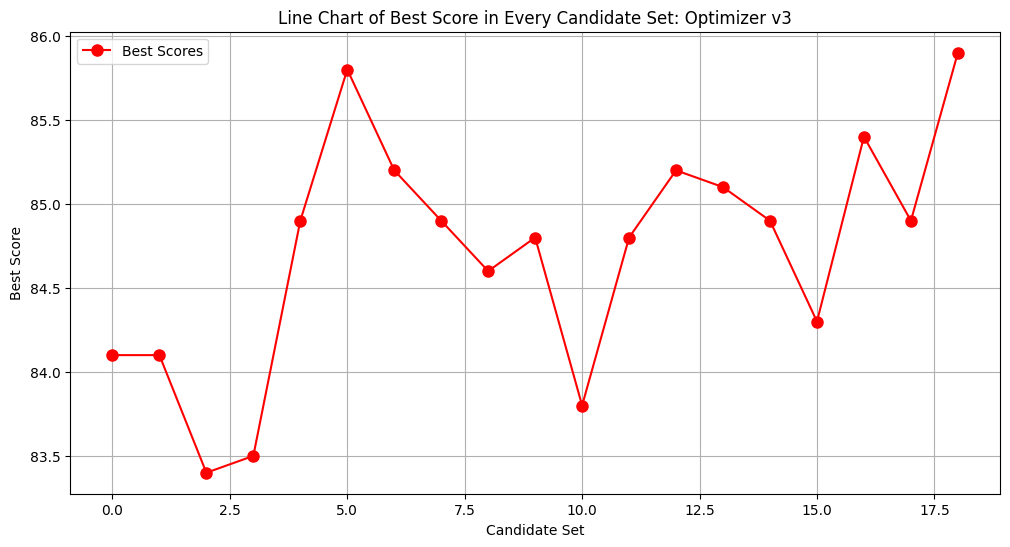

In [16]:
# Iterate over every 50 items
n = 50
iterations = len(best_score_v3) // n

# Plot only the max values
plt.figure(figsize=(12, 6))
plt.plot(best_score_v3, color='red', marker='o', linestyle='-', markersize=8, label='Best Scores')


# Adding final touches to the plot
plt.title('Line Chart of Best Score in Every Candidate Set: Optimizer v3')
plt.xlabel('Candidate Set')
plt.ylabel('Best Score')
plt.grid(True)
plt.legend()
plt.show()

## V4

In [ ]:
config = dict(max_labeled_demos=8)

teleprompter = BootstrapFewShotWithRandomSearch(metric=metric, **config)
optimized_program_v4 = teleprompter.compile(Topics_in_reviews(), trainset=training_set,valset=devset)

Going to sample between 1 and 4 traces per predictor.
Will attempt to train 16 candidate sets.



Average Metric: 42.05000000000002 / 50  (84.1): 100%|██████████| 50/50 [00:00<00:00, 196.25it/s]


Average Metric: 42.05000000000002 / 50  (84.1%)
Score: 84.1 for set: [0, 0]
New best score: 84.1 for seed -3
Scores so far: [84.1]
Best score: 84.1



Average Metric: 42.05000000000002 / 50  (84.1): 100%|██████████| 50/50 [00:00<00:00, 145.23it/s]


Average Metric: 42.05000000000002 / 50  (84.1%)
Score: 84.1 for set: [8, 8]
Scores so far: [84.1, 84.1]
Best score: 84.1



  4%|▍         | 4/100 [00:00<00:02, 38.71it/s]


Bootstrapped 4 full traces after 5 examples in round 0.



Average Metric: 42.000000000000014 / 50  (84.0): 100%|██████████| 50/50 [00:00<00:00, 257.70it/s]


Average Metric: 42.000000000000014 / 50  (84.0%)
Score: 84.0 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0]
Best score: 84.1
Average of max per entry across top 1 scores: 0.8410000000000004
Average of max per entry across top 2 scores: 0.8750000000000004
Average of max per entry across top 3 scores: 0.8890000000000005
Average of max per entry across top 5 scores: 0.8890000000000005
Average of max per entry across top 8 scores: 0.8890000000000005
Average of max per entry across top 9999 scores: 0.8890000000000005



  4%|▍         | 4/100 [00:00<00:04, 20.42it/s]


Bootstrapped 4 full traces after 5 examples in round 0.



Average Metric: 42.50000000000002 / 50  (85.0): 100%|██████████| 50/50 [00:00<00:00, 133.78it/s]


Average Metric: 42.50000000000002 / 50  (85.0%)
Score: 85.0 for set: [8, 8]
New best score: 85.0 for seed 0
Scores so far: [84.1, 84.1, 84.0, 85.0]
Best score: 85.0
Average of max per entry across top 1 scores: 0.8500000000000004
Average of max per entry across top 2 scores: 0.8820000000000005
Average of max per entry across top 3 scores: 0.8940000000000005
Average of max per entry across top 5 scores: 0.8990000000000004
Average of max per entry across top 8 scores: 0.8990000000000004
Average of max per entry across top 9999 scores: 0.8990000000000004



  2%|▏         | 2/100 [00:00<00:01, 79.62it/s]


Bootstrapped 2 full traces after 3 examples in round 0.



Average Metric: 42.85 / 50  (85.7): 100%|██████████| 50/50 [00:00<00:00, 112.14it/s]


Average Metric: 42.85 / 50  (85.7%)
Score: 85.7 for set: [8, 8]
New best score: 85.7 for seed 1
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7]
Best score: 85.7
Average of max per entry across top 1 scores: 0.857
Average of max per entry across top 2 scores: 0.8910000000000003
Average of max per entry across top 3 scores: 0.9020000000000004
Average of max per entry across top 5 scores: 0.9110000000000003
Average of max per entry across top 8 scores: 0.9110000000000003
Average of max per entry across top 9999 scores: 0.9110000000000003



  1%|          | 1/100 [00:00<00:07, 13.12it/s]


Bootstrapped 1 full traces after 2 examples in round 0.



Average Metric: 42.35000000000001 / 50  (84.7): 100%|██████████| 50/50 [00:00<00:00, 166.56it/s]


Average Metric: 42.35000000000001 / 50  (84.7%)
Score: 84.7 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7]
Best score: 85.7
Average of max per entry across top 1 scores: 0.857
Average of max per entry across top 2 scores: 0.8910000000000003
Average of max per entry across top 3 scores: 0.9070000000000001
Average of max per entry across top 5 scores: 0.9160000000000003
Average of max per entry across top 8 scores: 0.9180000000000003
Average of max per entry across top 9999 scores: 0.9180000000000003



  2%|▏         | 2/100 [00:00<00:01, 65.91it/s]


Bootstrapped 2 full traces after 3 examples in round 0.



Average Metric: 43.05000000000001 / 50  (86.1): 100%|██████████| 50/50 [00:00<00:00, 159.76it/s]


Average Metric: 43.05000000000001 / 50  (86.1%)
Score: 86.1 for set: [8, 8]
New best score: 86.1 for seed 3
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000002
Average of max per entry across top 2 scores: 0.8960000000000002
Average of max per entry across top 3 scores: 0.9070000000000004
Average of max per entry across top 5 scores: 0.9230000000000004
Average of max per entry across top 8 scores: 0.9290000000000004
Average of max per entry across top 9999 scores: 0.9290000000000004



  2%|▏         | 2/100 [00:00<00:03, 28.07it/s]


Bootstrapped 2 full traces after 3 examples in round 0.



Average Metric: 43.000000000000014 / 50  (86.0): 100%|██████████| 50/50 [00:00<00:00, 207.64it/s]


Average Metric: 43.000000000000014 / 50  (86.0%)
Score: 86.0 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000002
Average of max per entry across top 2 scores: 0.8930000000000002
Average of max per entry across top 3 scores: 0.9100000000000001
Average of max per entry across top 5 scores: 0.9270000000000002
Average of max per entry across top 8 scores: 0.9340000000000004
Average of max per entry across top 9999 scores: 0.9340000000000004



  3%|▎         | 3/100 [00:00<00:01, 55.32it/s]


Bootstrapped 3 full traces after 4 examples in round 0.



Average Metric: 41.500000000000014 / 50  (83.0): 100%|██████████| 50/50 [00:00<00:00, 165.83it/s]


Average Metric: 41.500000000000014 / 50  (83.0%)
Score: 83.0 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000002
Average of max per entry across top 2 scores: 0.8930000000000002
Average of max per entry across top 3 scores: 0.9100000000000001
Average of max per entry across top 5 scores: 0.9270000000000002
Average of max per entry across top 8 scores: 0.9340000000000004
Average of max per entry across top 9999 scores: 0.9350000000000003



  1%|          | 1/100 [00:00<00:01, 89.05it/s]


Bootstrapped 1 full traces after 2 examples in round 0.



Average Metric: 41.90000000000002 / 50  (83.8): 100%|██████████| 50/50 [00:00<00:00, 175.12it/s]


Average Metric: 41.90000000000002 / 50  (83.8%)
Score: 83.8 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000002
Average of max per entry across top 2 scores: 0.8930000000000002
Average of max per entry across top 3 scores: 0.9100000000000001
Average of max per entry across top 5 scores: 0.9270000000000002
Average of max per entry across top 8 scores: 0.9340000000000004
Average of max per entry across top 9999 scores: 0.9370000000000003



  3%|▎         | 3/100 [00:00<00:01, 79.92it/s]


Bootstrapped 3 full traces after 4 examples in round 0.



Average Metric: 42.30000000000001 / 50  (84.6): 100%|██████████| 50/50 [00:00<00:00, 174.32it/s]


Average Metric: 42.30000000000001 / 50  (84.6%)
Score: 84.6 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000002
Average of max per entry across top 2 scores: 0.8930000000000002
Average of max per entry across top 3 scores: 0.9100000000000001
Average of max per entry across top 5 scores: 0.9270000000000002
Average of max per entry across top 8 scores: 0.9350000000000002
Average of max per entry across top 9999 scores: 0.9400000000000004



  2%|▏         | 2/100 [00:00<00:01, 67.13it/s]


Bootstrapped 2 full traces after 3 examples in round 0.



Average Metric: 40.600000000000016 / 50  (81.2): 100%|██████████| 50/50 [00:00<00:00, 167.46it/s]


Average Metric: 40.600000000000016 / 50  (81.2%)
Score: 81.2 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6, 81.2]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000002
Average of max per entry across top 2 scores: 0.8930000000000002
Average of max per entry across top 3 scores: 0.9100000000000001
Average of max per entry across top 5 scores: 0.9270000000000002
Average of max per entry across top 8 scores: 0.9350000000000002
Average of max per entry across top 9999 scores: 0.9420000000000005



  4%|▍         | 4/100 [00:00<00:01, 67.93it/s]


Bootstrapped 4 full traces after 5 examples in round 0.



Average Metric: 43.15000000000002 / 50  (86.3): 100%|██████████| 50/50 [00:00<00:00, 146.95it/s]


Average Metric: 43.15000000000002 / 50  (86.3%)
Score: 86.3 for set: [8, 8]
New best score: 86.3 for seed 9
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6, 81.2, 86.3]
Best score: 86.3
Average of max per entry across top 1 scores: 0.8630000000000004
Average of max per entry across top 2 scores: 0.9000000000000006
Average of max per entry across top 3 scores: 0.9100000000000005
Average of max per entry across top 5 scores: 0.9230000000000003
Average of max per entry across top 8 scores: 0.9340000000000002
Average of max per entry across top 9999 scores: 0.9420000000000005



  1%|          | 1/100 [00:00<00:00, 114.14it/s]


Bootstrapped 1 full traces after 2 examples in round 0.



Average Metric: 42.45000000000001 / 50  (84.9): 100%|██████████| 50/50 [00:00<00:00, 89.89it/s] 


Average Metric: 42.45000000000001 / 50  (84.9%)
Score: 84.9 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6, 81.2, 86.3, 84.9]
Best score: 86.3
Average of max per entry across top 1 scores: 0.8630000000000004
Average of max per entry across top 2 scores: 0.9000000000000006
Average of max per entry across top 3 scores: 0.9100000000000005
Average of max per entry across top 5 scores: 0.9230000000000003
Average of max per entry across top 8 scores: 0.9370000000000003
Average of max per entry across top 9999 scores: 0.9430000000000005



  4%|▍         | 4/100 [00:00<00:01, 62.67it/s]


Bootstrapped 4 full traces after 5 examples in round 0.



Average Metric: 42.90000000000002 / 50  (85.8): 100%|██████████| 50/50 [00:02<00:00, 18.74it/s]


Average Metric: 42.90000000000002 / 50  (85.8%)
Score: 85.8 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6, 81.2, 86.3, 84.9, 85.8]
Best score: 86.3
Average of max per entry across top 1 scores: 0.8630000000000004
Average of max per entry across top 2 scores: 0.9000000000000006
Average of max per entry across top 3 scores: 0.9100000000000005
Average of max per entry across top 5 scores: 0.9220000000000002
Average of max per entry across top 8 scores: 0.9390000000000004
Average of max per entry across top 9999 scores: 0.9440000000000005



  4%|▍         | 4/100 [00:00<00:00, 119.46it/s]


Bootstrapped 4 full traces after 5 examples in round 0.



Average Metric: 42.40000000000003 / 50  (84.8): 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


Average Metric: 42.40000000000003 / 50  (84.8%)
Score: 84.8 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6, 81.2, 86.3, 84.9, 85.8, 84.8]
Best score: 86.3
Average of max per entry across top 1 scores: 0.8630000000000004
Average of max per entry across top 2 scores: 0.9000000000000006
Average of max per entry across top 3 scores: 0.9100000000000005
Average of max per entry across top 5 scores: 0.9220000000000002
Average of max per entry across top 8 scores: 0.9340000000000002
Average of max per entry across top 9999 scores: 0.9440000000000005



  3%|▎         | 3/100 [00:00<00:00, 121.93it/s]


Bootstrapped 3 full traces after 4 examples in round 0.



Average Metric: 42.35 / 50  (84.7): 100%|██████████| 50/50 [00:47<00:00,  1.04it/s]


Average Metric: 42.35 / 50  (84.7%)
Score: 84.7 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6, 81.2, 86.3, 84.9, 85.8, 84.8, 84.7]
Best score: 86.3
Average of max per entry across top 1 scores: 0.8630000000000004
Average of max per entry across top 2 scores: 0.9000000000000006
Average of max per entry across top 3 scores: 0.9100000000000005
Average of max per entry across top 5 scores: 0.9220000000000002
Average of max per entry across top 8 scores: 0.9340000000000002
Average of max per entry across top 9999 scores: 0.9440000000000005



  1%|          | 1/100 [00:00<00:00, 148.52it/s]


Bootstrapped 1 full traces after 2 examples in round 0.



Average Metric: 42.40000000000001 / 50  (84.8): 100%|██████████| 50/50 [00:46<00:00,  1.06it/s]


Average Metric: 42.40000000000001 / 50  (84.8%)
Score: 84.8 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6, 81.2, 86.3, 84.9, 85.8, 84.8, 84.7, 84.8]
Best score: 86.3
Average of max per entry across top 1 scores: 0.8630000000000004
Average of max per entry across top 2 scores: 0.9000000000000006
Average of max per entry across top 3 scores: 0.9100000000000005
Average of max per entry across top 5 scores: 0.9220000000000002
Average of max per entry across top 8 scores: 0.9340000000000002
Average of max per entry across top 9999 scores: 0.9450000000000006



  2%|▏         | 2/100 [00:00<00:00, 175.54it/s]


Bootstrapped 2 full traces after 3 examples in round 0.



Average Metric: 43.000000000000014 / 50  (86.0): 100%|██████████| 50/50 [00:51<00:00,  1.04s/it]

Average Metric: 43.000000000000014 / 50  (86.0%)
Score: 86.0 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6, 81.2, 86.3, 84.9, 85.8, 84.8, 84.7, 84.8, 86.0]
Best score: 86.3
Average of max per entry across top 1 scores: 0.8630000000000004
Average of max per entry across top 2 scores: 0.9000000000000006
Average of max per entry across top 3 scores: 0.9100000000000005
Average of max per entry across top 5 scores: 0.9240000000000002
Average of max per entry across top 8 scores: 0.9370000000000002
Average of max per entry across top 9999 scores: 0.9460000000000005
19 candidate programs found.


### output list

In [17]:
output = """
Going to sample between 1 and 4 traces per predictor.
Will attempt to train 16 candidate sets.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.85 / 1  (85.0):   0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 1.5 / 2  (75.0):   2%|▏         | 1/50 [00:00<00:00, 71.09it/s]
Average Metric: 2.35 / 3  (78.3):   4%|▍         | 2/50 [00:00<00:00, 115.22it/s]
Average Metric: 3.1500000000000004 / 4  (78.8):   6%|▌         | 3/50 [00:00<00:00, 142.90it/s]
Average Metric: 3.9000000000000004 / 5  (78.0):   8%|▊         | 4/50 [00:00<00:00, 134.25it/s]
Average Metric: 4.7 / 6  (78.3):  10%|█         | 5/50 [00:00<00:00, 148.48it/s]
Average Metric: 5.65 / 7  (80.7):  12%|█▏        | 6/50 [00:00<00:00, 152.79it/s]
Average Metric: 6.5 / 8  (81.2):  14%|█▍        | 7/50 [00:00<00:00, 154.66it/s]
Average Metric: 7.25 / 9  (80.6):  16%|█▌        | 8/50 [00:00<00:00, 162.62it/s]
Average Metric: 8.1 / 10  (81.0):  18%|█▊        | 9/50 [00:00<00:00, 171.34it/s]
Average Metric: 9.049999999999999 / 11  (82.3):  20%|██        | 10/50 [00:00<00:00, 177.50it/s]
Average Metric: 9.95 / 12  (82.9):  22%|██▏       | 11/50 [00:00<00:00, 178.82it/s]
Average Metric: 10.799999999999999 / 13  (83.1):  24%|██▍       | 12/50 [00:00<00:00, 181.73it/s]
Average Metric: 11.649999999999999 / 14  (83.2):  26%|██▌       | 13/50 [00:00<00:00, 182.37it/s]
Average Metric: 12.45 / 15  (83.0):  28%|██▊       | 14/50 [00:00<00:00, 186.24it/s]
Average Metric: 13.299999999999999 / 16  (83.1):  30%|███       | 15/50 [00:00<00:00, 186.56it/s]
Average Metric: 14.249999999999998 / 17  (83.8):  32%|███▏      | 16/50 [00:00<00:00, 187.79it/s]
Average Metric: 15.149999999999999 / 18  (84.2):  34%|███▍      | 17/50 [00:00<00:00, 189.67it/s]
Average Metric: 15.999999999999998 / 19  (84.2):  36%|███▌      | 18/50 [00:00<00:00, 191.43it/s]
Average Metric: 16.849999999999998 / 20  (84.2):  38%|███▊      | 19/50 [00:00<00:00, 193.21it/s]
Average Metric: 16.849999999999998 / 20  (84.2):  40%|████      | 20/50 [00:00<00:00, 197.79it/s]
Average Metric: 17.7 / 21  (84.3):  40%|████      | 20/50 [00:00<00:00, 197.79it/s]
Average Metric: 18.5 / 22  (84.1):  42%|████▏     | 21/50 [00:00<00:00, 197.79it/s]
Average Metric: 19.35 / 23  (84.1):  44%|████▍     | 22/50 [00:00<00:00, 197.79it/s]
Average Metric: 20.200000000000003 / 24  (84.2):  46%|████▌     | 23/50 [00:00<00:00, 197.79it/s]
Average Metric: 20.950000000000003 / 25  (83.8):  48%|████▊     | 24/50 [00:00<00:00, 197.79it/s]
Average Metric: 21.800000000000004 / 26  (83.8):  50%|█████     | 25/50 [00:00<00:00, 197.79it/s]
Average Metric: 22.550000000000004 / 27  (83.5):  52%|█████▏    | 26/50 [00:00<00:00, 197.79it/s]
Average Metric: 23.450000000000003 / 28  (83.8):  54%|█████▍    | 27/50 [00:00<00:00, 197.79it/s]
Average Metric: 24.250000000000004 / 29  (83.6):  56%|█████▌    | 28/50 [00:00<00:00, 197.79it/s]
Average Metric: 25.100000000000005 / 30  (83.7):  58%|█████▊    | 29/50 [00:00<00:00, 197.79it/s]
Average Metric: 25.900000000000006 / 31  (83.5):  60%|██████    | 30/50 [00:00<00:00, 197.79it/s]
Average Metric: 26.750000000000007 / 32  (83.6):  62%|██████▏   | 31/50 [00:00<00:00, 197.79it/s]
Average Metric: 27.60000000000001 / 33  (83.6):  64%|██████▍   | 32/50 [00:00<00:00, 197.79it/s]
Average Metric: 28.550000000000008 / 34  (84.0):  66%|██████▌   | 33/50 [00:00<00:00, 197.79it/s]
Average Metric: 29.40000000000001 / 35  (84.0):  68%|██████▊   | 34/50 [00:00<00:00, 197.79it/s]
Average Metric: 30.25000000000001 / 36  (84.0):  70%|███████   | 35/50 [00:00<00:00, 197.79it/s]
Average Metric: 31.100000000000012 / 37  (84.1):  72%|███████▏  | 36/50 [00:00<00:00, 197.79it/s]
Average Metric: 31.950000000000014 / 38  (84.1):  74%|███████▍  | 37/50 [00:00<00:00, 197.79it/s]
Average Metric: 32.80000000000001 / 39  (84.1):  76%|███████▌  | 38/50 [00:00<00:00, 197.79it/s]
Average Metric: 33.65000000000001 / 40  (84.1):  78%|███████▊  | 39/50 [00:00<00:00, 197.79it/s]
Average Metric: 33.65000000000001 / 40  (84.1):  80%|████████  | 40/50 [00:00<00:00, 196.75it/s]
Average Metric: 34.500000000000014 / 41  (84.1):  80%|████████  | 40/50 [00:00<00:00, 196.75it/s]
Average Metric: 35.350000000000016 / 42  (84.2):  82%|████████▏ | 41/50 [00:00<00:00, 196.75it/s]
Average Metric: 36.15000000000001 / 43  (84.1):  84%|████████▍ | 42/50 [00:00<00:00, 196.75it/s]
Average Metric: 36.90000000000001 / 44  (83.9):  86%|████████▌ | 43/50 [00:00<00:00, 196.75it/s]
Average Metric: 37.70000000000001 / 45  (83.8):  88%|████████▊ | 44/50 [00:00<00:00, 196.75it/s]
Average Metric: 38.55000000000001 / 46  (83.8):  90%|█████████ | 45/50 [00:00<00:00, 196.75it/s]
Average Metric: 39.500000000000014 / 47  (84.0):  92%|█████████▏| 46/50 [00:00<00:00, 196.75it/s]
Average Metric: 40.250000000000014 / 48  (83.9):  94%|█████████▍| 47/50 [00:00<00:00, 196.75it/s]
Average Metric: 41.100000000000016 / 49  (83.9):  96%|█████████▌| 48/50 [00:00<00:00, 196.75it/s]
Average Metric: 42.05000000000002 / 50  (84.1): 100%|██████████| 50/50 [00:00<00:00, 196.25it/s]
Average Metric: 42.05000000000002 / 50  (84.1%)
Score: 84.1 for set: [0, 0]
New best score: 84.1 for seed -3
Scores so far: [84.1]
Best score: 84.1

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.9 / 1  (90.0):   0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 1.75 / 2  (87.5):   2%|▏         | 1/50 [00:00<00:00, 145.29it/s]
Average Metric: 2.6 / 3  (86.7):   4%|▍         | 2/50 [00:00<00:00, 162.37it/s]
Average Metric: 3.4000000000000004 / 4  (85.0):   6%|▌         | 3/50 [00:00<00:00, 179.74it/s]
Average Metric: 4.25 / 5  (85.0):   8%|▊         | 4/50 [00:00<00:00, 191.27it/s]
Average Metric: 5.05 / 6  (84.2):  10%|█         | 5/50 [00:00<00:00, 199.27it/s]
Average Metric: 5.8999999999999995 / 7  (84.3):  12%|█▏        | 6/50 [00:00<00:00, 206.34it/s]
Average Metric: 6.699999999999999 / 8  (83.7):  14%|█▍        | 7/50 [00:00<00:00, 205.50it/s]
Average Metric: 7.549999999999999 / 9  (83.9):  16%|█▌        | 8/50 [00:00<00:00, 199.61it/s]
Average Metric: 8.399999999999999 / 10  (84.0):  18%|█▊        | 9/50 [00:00<00:00, 206.10it/s]
Average Metric: 9.249999999999998 / 11  (84.1):  20%|██        | 10/50 [00:00<00:00, 210.82it/s]
Average Metric: 9.999999999999998 / 12  (83.3):  22%|██▏       | 11/50 [00:00<00:00, 215.55it/s]
Average Metric: 10.849999999999998 / 13  (83.5):  24%|██▍       | 12/50 [00:00<00:00, 220.08it/s]
Average Metric: 11.699999999999998 / 14  (83.6):  26%|██▌       | 13/50 [00:00<00:00, 215.31it/s]
Average Metric: 12.549999999999997 / 15  (83.7):  28%|██▊       | 14/50 [00:00<00:00, 216.48it/s]
Average Metric: 13.299999999999997 / 16  (83.1):  30%|███       | 15/50 [00:00<00:00, 213.06it/s]
Average Metric: 14.099999999999998 / 17  (82.9):  32%|███▏      | 16/50 [00:00<00:00, 212.45it/s]
Average Metric: 15.049999999999997 / 18  (83.6):  34%|███▍      | 17/50 [00:00<00:00, 214.77it/s]
Average Metric: 15.899999999999997 / 19  (83.7):  36%|███▌      | 18/50 [00:00<00:00, 208.65it/s]
Average Metric: 16.65 / 20  (83.2):  38%|███▊      | 19/50 [00:00<00:00, 202.58it/s]
Average Metric: 17.599999999999998 / 21  (83.8):  40%|████      | 20/50 [00:00<00:00, 204.24it/s]
Average Metric: 17.599999999999998 / 21  (83.8):  42%|████▏     | 21/50 [00:00<00:00, 205.09it/s]
Average Metric: 18.549999999999997 / 22  (84.3):  42%|████▏     | 21/50 [00:00<00:00, 205.09it/s]
Average Metric: 19.199999999999996 / 23  (83.5):  44%|████▍     | 22/50 [00:00<00:00, 205.09it/s]
Average Metric: 19.999999999999996 / 24  (83.3):  46%|████▌     | 23/50 [00:00<00:00, 205.09it/s]
Average Metric: 20.849999999999998 / 25  (83.4):  48%|████▊     | 24/50 [00:00<00:00, 205.09it/s]
Average Metric: 21.749999999999996 / 26  (83.7):  50%|█████     | 25/50 [00:00<00:00, 205.09it/s]
Average Metric: 22.599999999999998 / 27  (83.7):  52%|█████▏    | 26/50 [00:00<00:00, 205.09it/s]
Average Metric: 23.45 / 28  (83.8):  54%|█████▍    | 27/50 [00:00<00:00, 205.09it/s]
Average Metric: 24.4 / 29  (84.1):  56%|█████▌    | 28/50 [00:00<00:00, 205.09it/s]
Average Metric: 25.25 / 30  (84.2):  58%|█████▊    | 29/50 [00:00<00:00, 205.09it/s]
Average Metric: 26.0 / 31  (83.9):  60%|██████    | 30/50 [00:00<00:00, 205.09it/s]
Average Metric: 26.8 / 32  (83.8):  62%|██████▏   | 31/50 [00:00<00:00, 205.09it/s]
Average Metric: 27.650000000000002 / 33  (83.8):  64%|██████▍   | 32/50 [00:00<00:00, 205.09it/s]
Average Metric: 28.500000000000004 / 34  (83.8):  66%|██████▌   | 33/50 [00:00<00:00, 205.09it/s]
Average Metric: 29.350000000000005 / 35  (83.9):  68%|██████▊   | 34/50 [00:00<00:00, 205.09it/s]
Average Metric: 30.100000000000005 / 36  (83.6):  70%|███████   | 35/50 [00:00<00:00, 205.09it/s]
Average Metric: 30.900000000000006 / 37  (83.5):  72%|███████▏  | 36/50 [00:00<00:00, 205.09it/s]
Average Metric: 31.700000000000006 / 38  (83.4):  74%|███████▍  | 37/50 [00:00<00:00, 205.09it/s]
Average Metric: 32.550000000000004 / 39  (83.5):  76%|███████▌  | 38/50 [00:00<00:00, 205.09it/s]
Average Metric: 33.50000000000001 / 40  (83.8):  78%|███████▊  | 39/50 [00:00<00:00, 205.09it/s]
Average Metric: 34.35000000000001 / 41  (83.8):  80%|████████  | 40/50 [00:00<00:00, 205.09it/s]
Average Metric: 35.20000000000001 / 42  (83.8):  82%|████████▏ | 41/50 [00:00<00:00, 205.09it/s]
Average Metric: 35.20000000000001 / 42  (83.8):  84%|████████▍ | 42/50 [00:00<00:00, 144.82it/s]
Average Metric: 36.05000000000001 / 43  (83.8):  84%|████████▍ | 42/50 [00:00<00:00, 144.82it/s]
Average Metric: 36.90000000000001 / 44  (83.9):  86%|████████▌ | 43/50 [00:00<00:00, 144.82it/s]
Average Metric: 37.65000000000001 / 45  (83.7):  88%|████████▊ | 44/50 [00:00<00:00, 144.82it/s]
Average Metric: 38.600000000000016 / 46  (83.9):  90%|█████████ | 45/50 [00:00<00:00, 144.82it/s]
Average Metric: 39.45000000000002 / 47  (83.9):  92%|█████████▏| 46/50 [00:00<00:00, 144.82it/s]
Average Metric: 40.350000000000016 / 48  (84.1):  94%|█████████▍| 47/50 [00:00<00:00, 144.82it/s]
Average Metric: 41.20000000000002 / 49  (84.1):  96%|█████████▌| 48/50 [00:00<00:00, 144.82it/s]
Average Metric: 42.05000000000002 / 50  (84.1): 100%|██████████| 50/50 [00:00<00:00, 145.23it/s]
Average Metric: 42.05000000000002 / 50  (84.1%)
Score: 84.1 for set: [8, 8]
Scores so far: [84.1, 84.1]
Best score: 84.1

  4%|▍         | 4/100 [00:00<00:02, 38.71it/s]
Bootstrapped 4 full traces after 5 examples in round 0.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.85 / 1  (85.0):   0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 1.7 / 2  (85.0):   2%|▏         | 1/50 [00:00<00:00, 114.84it/s]
Average Metric: 2.55 / 3  (85.0):   4%|▍         | 2/50 [00:00<00:00, 128.14it/s]
Average Metric: 3.5 / 4  (87.5):   6%|▌         | 3/50 [00:00<00:00, 139.21it/s]
Average Metric: 4.45 / 5  (89.0):   8%|▊         | 4/50 [00:00<00:00, 107.90it/s]
Average Metric: 5.3 / 6  (88.3):  10%|█         | 5/50 [00:00<00:00, 123.76it/s]
Average Metric: 6.05 / 7  (86.4):  12%|█▏        | 6/50 [00:00<00:00, 137.91it/s]
Average Metric: 6.95 / 8  (86.9):  14%|█▍        | 7/50 [00:00<00:00, 148.15it/s]
Average Metric: 7.8 / 9  (86.7):  16%|█▌        | 8/50 [00:00<00:00, 157.55it/s]
Average Metric: 8.55 / 10  (85.5):  18%|█▊        | 9/50 [00:00<00:00, 161.14it/s]
Average Metric: 9.4 / 11  (85.5):  20%|██        | 10/50 [00:00<00:00, 168.08it/s]
Average Metric: 10.15 / 12  (84.6):  22%|██▏       | 11/50 [00:00<00:00, 175.17it/s]
Average Metric: 10.9 / 13  (83.8):  24%|██▍       | 12/50 [00:00<00:00, 181.77it/s]
Average Metric: 11.700000000000001 / 14  (83.6):  26%|██▌       | 13/50 [00:00<00:00, 188.04it/s]
Average Metric: 12.55 / 15  (83.7):  28%|██▊       | 14/50 [00:00<00:00, 193.87it/s]
Average Metric: 13.4 / 16  (83.8):  30%|███       | 15/50 [00:00<00:00, 197.63it/s]
Average Metric: 14.25 / 17  (83.8):  32%|███▏      | 16/50 [00:00<00:00, 202.15it/s]
Average Metric: 15.05 / 18  (83.6):  34%|███▍      | 17/50 [00:00<00:00, 206.29it/s]
Average Metric: 15.9 / 19  (83.7):  36%|███▌      | 18/50 [00:00<00:00, 209.45it/s]
Average Metric: 16.75 / 20  (83.8):  38%|███▊      | 19/50 [00:00<00:00, 212.99it/s]
Average Metric: 17.7 / 21  (84.3):  40%|████      | 20/50 [00:00<00:00, 216.51it/s]
Average Metric: 18.45 / 22  (83.9):  42%|████▏     | 21/50 [00:00<00:00, 219.64it/s]
Average Metric: 19.349999999999998 / 23  (84.1):  44%|████▍     | 22/50 [00:00<00:00, 222.85it/s]
Average Metric: 19.349999999999998 / 23  (84.1):  46%|████▌     | 23/50 [00:00<00:00, 228.21it/s]
Average Metric: 20.099999999999998 / 24  (83.7):  46%|████▌     | 23/50 [00:00<00:00, 228.21it/s]
Average Metric: 20.95 / 25  (83.8):  48%|████▊     | 24/50 [00:00<00:00, 228.21it/s]
Average Metric: 21.8 / 26  (83.8):  50%|█████     | 25/50 [00:00<00:00, 228.21it/s]
Average Metric: 22.650000000000002 / 27  (83.9):  52%|█████▏    | 26/50 [00:00<00:00, 228.21it/s]
Average Metric: 23.500000000000004 / 28  (83.9):  54%|█████▍    | 27/50 [00:00<00:00, 228.21it/s]
Average Metric: 24.400000000000002 / 29  (84.1):  56%|█████▌    | 28/50 [00:00<00:00, 228.21it/s]
Average Metric: 25.250000000000004 / 30  (84.2):  58%|█████▊    | 29/50 [00:00<00:00, 228.21it/s]
Average Metric: 25.950000000000003 / 31  (83.7):  60%|██████    | 30/50 [00:00<00:00, 228.21it/s]
Average Metric: 26.700000000000003 / 32  (83.4):  62%|██████▏   | 31/50 [00:00<00:00, 228.21it/s]
Average Metric: 27.550000000000004 / 33  (83.5):  64%|██████▍   | 32/50 [00:00<00:00, 228.21it/s]
Average Metric: 28.400000000000006 / 34  (83.5):  66%|██████▌   | 33/50 [00:00<00:00, 228.21it/s]
Average Metric: 29.350000000000005 / 35  (83.9):  68%|██████▊   | 34/50 [00:00<00:00, 228.21it/s]
Average Metric: 30.200000000000006 / 36  (83.9):  70%|███████   | 35/50 [00:00<00:00, 228.21it/s]
Average Metric: 31.000000000000007 / 37  (83.8):  72%|███████▏  | 36/50 [00:00<00:00, 228.21it/s]
Average Metric: 31.800000000000008 / 38  (83.7):  74%|███████▍  | 37/50 [00:00<00:00, 228.21it/s]
Average Metric: 32.75000000000001 / 39  (84.0):  76%|███████▌  | 38/50 [00:00<00:00, 228.21it/s]
Average Metric: 33.45000000000001 / 40  (83.6):  78%|███████▊  | 39/50 [00:00<00:00, 228.21it/s]
Average Metric: 34.35000000000001 / 41  (83.8):  80%|████████  | 40/50 [00:00<00:00, 228.21it/s]
Average Metric: 35.20000000000001 / 42  (83.8):  82%|████████▏ | 41/50 [00:00<00:00, 228.21it/s]
Average Metric: 36.05000000000001 / 43  (83.8):  84%|████████▍ | 42/50 [00:00<00:00, 228.21it/s]
Average Metric: 36.90000000000001 / 44  (83.9):  86%|████████▌ | 43/50 [00:00<00:00, 228.21it/s]
Average Metric: 37.750000000000014 / 45  (83.9):  88%|████████▊ | 44/50 [00:00<00:00, 228.21it/s]
Average Metric: 38.600000000000016 / 46  (83.9):  90%|█████████ | 45/50 [00:00<00:00, 228.21it/s]
Average Metric: 39.500000000000014 / 47  (84.0):  92%|█████████▏| 46/50 [00:00<00:00, 228.21it/s]
Average Metric: 40.350000000000016 / 48  (84.1):  94%|█████████▍| 47/50 [00:00<00:00, 228.21it/s]
Average Metric: 41.100000000000016 / 49  (83.9):  96%|█████████▌| 48/50 [00:00<00:00, 228.21it/s]
Average Metric: 42.000000000000014 / 50  (84.0): 100%|██████████| 50/50 [00:00<00:00, 257.70it/s]
Average Metric: 42.000000000000014 / 50  (84.0%)
Score: 84.0 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0]
Best score: 84.1
Average of max per entry across top 1 scores: 0.8410000000000004
Average of max per entry across top 2 scores: 0.8750000000000004
Average of max per entry across top 3 scores: 0.8890000000000005
Average of max per entry across top 5 scores: 0.8890000000000005
Average of max per entry across top 8 scores: 0.8890000000000005
Average of max per entry across top 9999 scores: 0.8890000000000005

  0%|          | 0/100 [00:00<?, ?it/s]
  4%|▍         | 4/100 [00:00<00:04, 20.42it/s]
Bootstrapped 4 full traces after 5 examples in round 0.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.85 / 1  (85.0):   0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 1.7 / 2  (85.0):   2%|▏         | 1/50 [00:00<00:01, 29.87it/s]
Average Metric: 2.55 / 3  (85.0):   4%|▍         | 2/50 [00:00<00:01, 25.66it/s]
Average Metric: 3.5 / 4  (87.5):   6%|▌         | 3/50 [00:00<00:01, 29.68it/s]
Average Metric: 3.5 / 4  (87.5):   8%|▊         | 4/50 [00:00<00:01, 36.43it/s]
Average Metric: 4.45 / 5  (89.0):   8%|▊         | 4/50 [00:00<00:01, 36.43it/s]
Average Metric: 5.3 / 6  (88.3):  10%|█         | 5/50 [00:00<00:01, 36.43it/s]
Average Metric: 6.1499999999999995 / 7  (87.9):  12%|█▏        | 6/50 [00:00<00:01, 36.43it/s]
Average Metric: 6.8999999999999995 / 8  (86.2):  14%|█▍        | 7/50 [00:00<00:01, 36.43it/s]
Average Metric: 7.749999999999999 / 9  (86.1):  16%|█▌        | 8/50 [00:00<00:01, 36.43it/s]
Average Metric: 8.5 / 10  (85.0):  18%|█▊        | 9/50 [00:00<00:01, 36.43it/s]
Average Metric: 9.35 / 11  (85.0):  20%|██        | 10/50 [00:00<00:01, 36.43it/s]
Average Metric: 10.2 / 12  (85.0):  22%|██▏       | 11/50 [00:00<00:01, 36.43it/s]
Average Metric: 11.1 / 13  (85.4):  24%|██▍       | 12/50 [00:00<00:01, 36.43it/s]
Average Metric: 11.95 / 14  (85.4):  26%|██▌       | 13/50 [00:00<00:01, 36.43it/s]
Average Metric: 12.75 / 15  (85.0):  28%|██▊       | 14/50 [00:00<00:00, 36.43it/s]
Average Metric: 13.7 / 16  (85.6):  30%|███       | 15/50 [00:00<00:00, 36.43it/s]
Average Metric: 14.45 / 17  (85.0):  32%|███▏      | 16/50 [00:00<00:00, 36.43it/s]
Average Metric: 15.299999999999999 / 18  (85.0):  34%|███▍      | 17/50 [00:00<00:00, 36.43it/s]
Average Metric: 16.2 / 19  (85.3):  36%|███▌      | 18/50 [00:00<00:00, 36.43it/s]
Average Metric: 17.05 / 20  (85.2):  38%|███▊      | 19/50 [00:00<00:00, 36.43it/s]
Average Metric: 18.0 / 21  (85.7):  40%|████      | 20/50 [00:00<00:00, 36.43it/s]
Average Metric: 18.0 / 21  (85.7):  42%|████▏     | 21/50 [00:00<00:00, 111.41it/s]
Average Metric: 18.95 / 22  (86.1):  42%|████▏     | 21/50 [00:00<00:00, 111.41it/s]
Average Metric: 19.65 / 23  (85.4):  44%|████▍     | 22/50 [00:00<00:00, 111.41it/s]
Average Metric: 20.5 / 24  (85.4):  46%|████▌     | 23/50 [00:00<00:00, 111.41it/s]
Average Metric: 21.45 / 25  (85.8):  48%|████▊     | 24/50 [00:00<00:00, 111.41it/s]
Average Metric: 22.3 / 26  (85.8):  50%|█████     | 25/50 [00:00<00:00, 111.41it/s]
Average Metric: 23.2 / 27  (85.9):  52%|█████▏    | 26/50 [00:00<00:00, 111.41it/s]
Average Metric: 23.8 / 28  (85.0):  54%|█████▍    | 27/50 [00:00<00:00, 111.41it/s]
Average Metric: 24.650000000000002 / 29  (85.0):  56%|█████▌    | 28/50 [00:00<00:00, 111.41it/s]
Average Metric: 25.500000000000004 / 30  (85.0):  58%|█████▊    | 29/50 [00:00<00:00, 111.41it/s]
Average Metric: 26.350000000000005 / 31  (85.0):  60%|██████    | 30/50 [00:00<00:00, 111.41it/s]
Average Metric: 27.200000000000006 / 32  (85.0):  62%|██████▏   | 31/50 [00:00<00:00, 111.41it/s]
Average Metric: 28.050000000000008 / 33  (85.0):  64%|██████▍   | 32/50 [00:00<00:00, 111.41it/s]
Average Metric: 28.800000000000008 / 34  (84.7):  66%|██████▌   | 33/50 [00:00<00:00, 111.41it/s]
Average Metric: 29.750000000000007 / 35  (85.0):  68%|██████▊   | 34/50 [00:00<00:00, 111.41it/s]
Average Metric: 30.60000000000001 / 36  (85.0):  70%|███████   | 35/50 [00:00<00:00, 111.41it/s]
Average Metric: 31.550000000000008 / 37  (85.3):  72%|███████▏  | 36/50 [00:00<00:00, 111.41it/s]
Average Metric: 32.400000000000006 / 38  (85.3):  74%|███████▍  | 37/50 [00:00<00:00, 111.41it/s]
Average Metric: 33.25000000000001 / 39  (85.3):  76%|███████▌  | 38/50 [00:00<00:00, 111.41it/s]
Average Metric: 34.10000000000001 / 40  (85.3):  78%|███████▊  | 39/50 [00:00<00:00, 111.41it/s]
Average Metric: 34.95000000000001 / 41  (85.2):  80%|████████  | 40/50 [00:00<00:00, 111.41it/s]
Average Metric: 34.95000000000001 / 41  (85.2):  82%|████████▏ | 41/50 [00:00<00:00, 147.59it/s]
Average Metric: 35.80000000000001 / 42  (85.2):  82%|████████▏ | 41/50 [00:00<00:00, 147.59it/s]
Average Metric: 36.55000000000001 / 43  (85.0):  84%|████████▍ | 42/50 [00:00<00:00, 147.59it/s]
Average Metric: 37.40000000000001 / 44  (85.0):  86%|████████▌ | 43/50 [00:00<00:00, 147.59it/s]
Average Metric: 38.250000000000014 / 45  (85.0):  88%|████████▊ | 44/50 [00:00<00:00, 147.59it/s]
Average Metric: 39.100000000000016 / 46  (85.0):  90%|█████████ | 45/50 [00:00<00:00, 147.59it/s]
Average Metric: 39.95000000000002 / 47  (85.0):  92%|█████████▏| 46/50 [00:00<00:00, 147.59it/s]
Average Metric: 40.80000000000002 / 48  (85.0):  94%|█████████▍| 47/50 [00:00<00:00, 147.59it/s]
Average Metric: 41.65000000000002 / 49  (85.0):  96%|█████████▌| 48/50 [00:00<00:00, 147.59it/s]
Average Metric: 42.50000000000002 / 50  (85.0): 100%|██████████| 50/50 [00:00<00:00, 133.78it/s]
Average Metric: 42.50000000000002 / 50  (85.0%)
Score: 85.0 for set: [8, 8]
New best score: 85.0 for seed 0
Scores so far: [84.1, 84.1, 84.0, 85.0]
Best score: 85.0
Average of max per entry across top 1 scores: 0.8500000000000004
Average of max per entry across top 2 scores: 0.8820000000000005
Average of max per entry across top 3 scores: 0.8940000000000005
Average of max per entry across top 5 scores: 0.8990000000000004
Average of max per entry across top 8 scores: 0.8990000000000004
Average of max per entry across top 9999 scores: 0.8990000000000004

  2%|▏         | 2/100 [00:00<00:01, 79.62it/s]
Bootstrapped 2 full traces after 3 examples in round 0.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.9 / 1  (90.0):   0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 1.85 / 2  (92.5):   2%|▏         | 1/50 [00:00<00:01, 33.20it/s]
Average Metric: 2.7 / 3  (90.0):   4%|▍         | 2/50 [00:00<00:00, 57.28it/s]
Average Metric: 3.35 / 4  (83.8):   6%|▌         | 3/50 [00:00<00:00, 69.13it/s]
Average Metric: 4.2 / 5  (84.0):   8%|▊         | 4/50 [00:00<00:00, 82.22it/s]
Average Metric: 5.05 / 6  (84.2):  10%|█         | 5/50 [00:00<00:00, 93.72it/s]
Average Metric: 5.8999999999999995 / 7  (84.3):  12%|█▏        | 6/50 [00:00<00:00, 106.58it/s]
Average Metric: 6.6499999999999995 / 8  (83.1):  14%|█▍        | 7/50 [00:00<00:00, 112.58it/s]
Average Metric: 7.499999999999999 / 9  (83.3):  16%|█▌        | 8/50 [00:00<00:00, 122.42it/s]
Average Metric: 8.45 / 10  (84.5):  18%|█▊        | 9/50 [00:00<00:00, 128.76it/s]
Average Metric: 9.399999999999999 / 11  (85.5):  20%|██        | 10/50 [00:00<00:00, 137.29it/s]
Average Metric: 10.299999999999999 / 12  (85.8):  22%|██▏       | 11/50 [00:00<00:00, 141.92it/s]
Average Metric: 11.149999999999999 / 13  (85.8):  24%|██▍       | 12/50 [00:00<00:00, 149.06it/s]
Average Metric: 12.099999999999998 / 14  (86.4):  26%|██▌       | 13/50 [00:00<00:00, 150.13it/s]
Average Metric: 12.949999999999998 / 15  (86.3):  28%|██▊       | 14/50 [00:00<00:00, 154.02it/s]
Average Metric: 13.799999999999997 / 16  (86.2):  30%|███       | 15/50 [00:00<00:00, 157.31it/s]
Average Metric: 14.749999999999996 / 17  (86.8):  32%|███▏      | 16/50 [00:00<00:00, 161.68it/s]
Average Metric: 14.749999999999996 / 17  (86.8):  34%|███▍      | 17/50 [00:00<00:00, 128.06it/s]
Average Metric: 15.599999999999996 / 18  (86.7):  34%|███▍      | 17/50 [00:00<00:00, 128.06it/s]
Average Metric: 16.449999999999996 / 19  (86.6):  36%|███▌      | 18/50 [00:00<00:00, 128.06it/s]
Average Metric: 17.199999999999996 / 20  (86.0):  38%|███▊      | 19/50 [00:00<00:00, 128.06it/s]
Average Metric: 18.099999999999994 / 21  (86.2):  40%|████      | 20/50 [00:00<00:00, 128.06it/s]
Average Metric: 19.049999999999994 / 22  (86.6):  42%|████▏     | 21/50 [00:00<00:00, 128.06it/s]
Average Metric: 19.899999999999995 / 23  (86.5):  44%|████▍     | 22/50 [00:00<00:00, 128.06it/s]
Average Metric: 20.699999999999996 / 24  (86.2):  46%|████▌     | 23/50 [00:00<00:00, 128.06it/s]
Average Metric: 21.449999999999996 / 25  (85.8):  48%|████▊     | 24/50 [00:00<00:00, 128.06it/s]
Average Metric: 22.249999999999996 / 26  (85.6):  50%|█████     | 25/50 [00:00<00:00, 128.06it/s]
Average Metric: 23.049999999999997 / 27  (85.4):  52%|█████▏    | 26/50 [00:00<00:00, 128.06it/s]
Average Metric: 23.9 / 28  (85.4):  54%|█████▍    | 27/50 [00:00<00:00, 128.06it/s]
Average Metric: 24.75 / 29  (85.3):  56%|█████▌    | 28/50 [00:00<00:00, 128.06it/s]
Average Metric: 25.5 / 30  (85.0):  58%|█████▊    | 29/50 [00:00<00:00, 128.06it/s]
Average Metric: 25.5 / 30  (85.0):  60%|██████    | 30/50 [00:00<00:00, 98.72it/s]
Average Metric: 26.25 / 31  (84.7):  60%|██████    | 30/50 [00:00<00:00, 98.72it/s]
Average Metric: 27.15 / 32  (84.8):  62%|██████▏   | 31/50 [00:00<00:00, 98.72it/s]
Average Metric: 28.099999999999998 / 33  (85.2):  64%|██████▍   | 32/50 [00:00<00:00, 98.72it/s]
Average Metric: 28.999999999999996 / 34  (85.3):  66%|██████▌   | 33/50 [00:00<00:00, 98.72it/s]
Average Metric: 29.899999999999995 / 35  (85.4):  68%|██████▊   | 34/50 [00:00<00:00, 98.72it/s]
Average Metric: 30.649999999999995 / 36  (85.1):  70%|███████   | 35/50 [00:00<00:00, 98.72it/s]
Average Metric: 31.599999999999994 / 37  (85.4):  72%|███████▏  | 36/50 [00:00<00:00, 98.72it/s]
Average Metric: 32.449999999999996 / 38  (85.4):  74%|███████▍  | 37/50 [00:00<00:00, 98.72it/s]
Average Metric: 33.24999999999999 / 39  (85.3):  76%|███████▌  | 38/50 [00:00<00:00, 98.72it/s]
Average Metric: 34.199999999999996 / 40  (85.5):  78%|███████▊  | 39/50 [00:00<00:00, 98.72it/s]
Average Metric: 35.15 / 41  (85.7):  80%|████████  | 40/50 [00:00<00:00, 98.72it/s]
Average Metric: 36.0 / 42  (85.7):  82%|████████▏ | 41/50 [00:00<00:00, 98.72it/s]
Average Metric: 36.85 / 43  (85.7):  84%|████████▍ | 42/50 [00:00<00:00, 98.72it/s]
Average Metric: 37.75 / 44  (85.8):  86%|████████▌ | 43/50 [00:00<00:00, 98.72it/s]
Average Metric: 38.5 / 45  (85.6):  88%|████████▊ | 44/50 [00:00<00:00, 98.72it/s]
Average Metric: 38.5 / 45  (85.6):  90%|█████████ | 45/50 [00:00<00:00, 114.09it/s]
Average Metric: 39.45 / 46  (85.8):  90%|█████████ | 45/50 [00:00<00:00, 114.09it/s]
Average Metric: 40.25 / 47  (85.6):  92%|█████████▏| 46/50 [00:00<00:00, 114.09it/s]
Average Metric: 41.1 / 48  (85.6):  94%|█████████▍| 47/50 [00:00<00:00, 114.09it/s]
Average Metric: 42.0 / 49  (85.7):  96%|█████████▌| 48/50 [00:00<00:00, 114.09it/s]
Average Metric: 42.85 / 50  (85.7): 100%|██████████| 50/50 [00:00<00:00, 112.14it/s]
Average Metric: 42.85 / 50  (85.7%)
Score: 85.7 for set: [8, 8]
New best score: 85.7 for seed 1
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7]
Best score: 85.7
Average of max per entry across top 1 scores: 0.857
Average of max per entry across top 2 scores: 0.8910000000000003
Average of max per entry across top 3 scores: 0.9020000000000004
Average of max per entry across top 5 scores: 0.9110000000000003
Average of max per entry across top 8 scores: 0.9110000000000003
Average of max per entry across top 9999 scores: 0.9110000000000003

  1%|          | 1/100 [00:00<00:07, 13.12it/s]
Bootstrapped 1 full traces after 2 examples in round 0.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.85 / 1  (85.0):   0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 1.65 / 2  (82.5):   2%|▏         | 1/50 [00:00<00:00, 168.01it/s]
Average Metric: 2.55 / 3  (85.0):   4%|▍         | 2/50 [00:00<00:00, 222.01it/s]
Average Metric: 3.5 / 4  (87.5):   6%|▌         | 3/50 [00:00<00:00, 244.57it/s]
Average Metric: 4.35 / 5  (87.0):   8%|▊         | 4/50 [00:00<00:00, 261.47it/s]
Average Metric: 5.199999999999999 / 6  (86.7):  10%|█         | 5/50 [00:00<00:00, 262.43it/s]
Average Metric: 5.949999999999999 / 7  (85.0):  12%|█▏        | 6/50 [00:00<00:00, 257.89it/s]
Average Metric: 6.799999999999999 / 8  (85.0):  14%|█▍        | 7/50 [00:00<00:00, 263.43it/s]
Average Metric: 7.699999999999999 / 9  (85.6):  16%|█▌        | 8/50 [00:00<00:00, 185.13it/s]
Average Metric: 8.549999999999999 / 10  (85.5):  18%|█▊        | 9/50 [00:00<00:00, 180.23it/s]
Average Metric: 9.299999999999999 / 11  (84.5):  20%|██        | 10/50 [00:00<00:00, 169.06it/s]
Average Metric: 10.149999999999999 / 12  (84.6):  22%|██▏       | 11/50 [00:00<00:00, 175.01it/s]
Average Metric: 10.999999999999998 / 13  (84.6):  24%|██▍       | 12/50 [00:00<00:00, 181.80it/s]
Average Metric: 11.849999999999998 / 14  (84.6):  26%|██▌       | 13/50 [00:00<00:00, 184.89it/s]
Average Metric: 12.799999999999997 / 15  (85.3):  28%|██▊       | 14/50 [00:00<00:00, 184.40it/s]
Average Metric: 13.699999999999998 / 16  (85.6):  30%|███       | 15/50 [00:00<00:00, 183.74it/s]
Average Metric: 14.399999999999997 / 17  (84.7):  32%|███▏      | 16/50 [00:00<00:00, 181.16it/s]
Average Metric: 15.249999999999996 / 18  (84.7):  34%|███▍      | 17/50 [00:00<00:00, 176.68it/s]
Average Metric: 15.249999999999996 / 18  (84.7):  36%|███▌      | 18/50 [00:00<00:00, 176.05it/s]
Average Metric: 16.049999999999997 / 19  (84.5):  36%|███▌      | 18/50 [00:00<00:00, 176.05it/s]
Average Metric: 16.9 / 20  (84.5):  38%|███▊      | 19/50 [00:00<00:00, 176.05it/s]
Average Metric: 17.65 / 21  (84.0):  40%|████      | 20/50 [00:00<00:00, 176.05it/s]
Average Metric: 18.5 / 22  (84.1):  42%|████▏     | 21/50 [00:00<00:00, 176.05it/s]
Average Metric: 19.4 / 23  (84.3):  44%|████▍     | 22/50 [00:00<00:00, 176.05it/s]
Average Metric: 20.299999999999997 / 24  (84.6):  46%|████▌     | 23/50 [00:00<00:00, 176.05it/s]
Average Metric: 21.049999999999997 / 25  (84.2):  48%|████▊     | 24/50 [00:00<00:00, 176.05it/s]
Average Metric: 21.749999999999996 / 26  (83.7):  50%|█████     | 25/50 [00:00<00:00, 176.05it/s]
Average Metric: 22.499999999999996 / 27  (83.3):  52%|█████▏    | 26/50 [00:00<00:00, 176.05it/s]
Average Metric: 23.449999999999996 / 28  (83.7):  54%|█████▍    | 27/50 [00:00<00:00, 176.05it/s]
Average Metric: 24.349999999999994 / 29  (84.0):  56%|█████▌    | 28/50 [00:00<00:00, 176.05it/s]
Average Metric: 25.199999999999996 / 30  (84.0):  58%|█████▊    | 29/50 [00:00<00:00, 176.05it/s]
Average Metric: 26.049999999999997 / 31  (84.0):  60%|██████    | 30/50 [00:00<00:00, 176.05it/s]
Average Metric: 26.9 / 32  (84.1):  62%|██████▏   | 31/50 [00:00<00:00, 176.05it/s]
Average Metric: 27.75 / 33  (84.1):  64%|██████▍   | 32/50 [00:00<00:00, 176.05it/s]
Average Metric: 28.7 / 34  (84.4):  66%|██████▌   | 33/50 [00:00<00:00, 176.05it/s]
Average Metric: 29.5 / 35  (84.3):  68%|██████▊   | 34/50 [00:00<00:00, 176.05it/s]
Average Metric: 30.35 / 36  (84.3):  70%|███████   | 35/50 [00:00<00:00, 176.05it/s]
Average Metric: 30.35 / 36  (84.3):  72%|███████▏  | 36/50 [00:00<00:00, 164.85it/s]
Average Metric: 31.3 / 37  (84.6):  72%|███████▏  | 36/50 [00:00<00:00, 164.85it/s]
Average Metric: 32.15 / 38  (84.6):  74%|███████▍  | 37/50 [00:00<00:00, 164.85it/s]
Average Metric: 33.05 / 39  (84.7):  76%|███████▌  | 38/50 [00:00<00:00, 164.85it/s]
Average Metric: 33.9 / 40  (84.8):  78%|███████▊  | 39/50 [00:00<00:00, 164.85it/s]
Average Metric: 34.75 / 41  (84.8):  80%|████████  | 40/50 [00:00<00:00, 164.85it/s]
Average Metric: 35.6 / 42  (84.8):  82%|████████▏ | 41/50 [00:00<00:00, 164.85it/s]
Average Metric: 36.45 / 43  (84.8):  84%|████████▍ | 42/50 [00:00<00:00, 164.85it/s]
Average Metric: 37.400000000000006 / 44  (85.0):  86%|████████▌ | 43/50 [00:00<00:00, 164.85it/s]
Average Metric: 38.25000000000001 / 45  (85.0):  88%|████████▊ | 44/50 [00:00<00:00, 164.85it/s]
Average Metric: 39.00000000000001 / 46  (84.8):  90%|█████████ | 45/50 [00:00<00:00, 164.85it/s]
Average Metric: 39.95000000000001 / 47  (85.0):  92%|█████████▏| 46/50 [00:00<00:00, 164.85it/s]
Average Metric: 40.75000000000001 / 48  (84.9):  94%|█████████▍| 47/50 [00:00<00:00, 164.85it/s]
Average Metric: 41.60000000000001 / 49  (84.9):  96%|█████████▌| 48/50 [00:00<00:00, 164.85it/s]
Average Metric: 42.35000000000001 / 50  (84.7): 100%|██████████| 50/50 [00:00<00:00, 166.56it/s]
Average Metric: 42.35000000000001 / 50  (84.7%)
Score: 84.7 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7]
Best score: 85.7
Average of max per entry across top 1 scores: 0.857
Average of max per entry across top 2 scores: 0.8910000000000003
Average of max per entry across top 3 scores: 0.9070000000000001
Average of max per entry across top 5 scores: 0.9160000000000003
Average of max per entry across top 8 scores: 0.9180000000000003
Average of max per entry across top 9999 scores: 0.9180000000000003

  2%|▏         | 2/100 [00:00<00:01, 65.91it/s]
Bootstrapped 2 full traces after 3 examples in round 0.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.75 / 1  (75.0):   0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 1.55 / 2  (77.5):   2%|▏         | 1/50 [00:00<00:00, 182.61it/s]
Average Metric: 2.4 / 3  (80.0):   4%|▍         | 2/50 [00:00<00:00, 229.38it/s]
Average Metric: 3.25 / 4  (81.2):   6%|▌         | 3/50 [00:00<00:00, 240.60it/s]
Average Metric: 3.95 / 5  (79.0):   8%|▊         | 4/50 [00:00<00:00, 181.20it/s]
Average Metric: 4.8500000000000005 / 6  (80.8):  10%|█         | 5/50 [00:00<00:00, 141.86it/s]
Average Metric: 5.750000000000001 / 7  (82.1):  12%|█▏        | 6/50 [00:00<00:00, 153.92it/s]
Average Metric: 6.500000000000001 / 8  (81.3):  14%|█▍        | 7/50 [00:00<00:00, 155.42it/s]
Average Metric: 7.300000000000001 / 9  (81.1):  16%|█▌        | 8/50 [00:00<00:00, 154.63it/s]
Average Metric: 8.25 / 10  (82.5):  18%|█▊        | 9/50 [00:00<00:00, 157.30it/s]
Average Metric: 9.1 / 11  (82.7):  20%|██        | 10/50 [00:00<00:00, 159.44it/s]
Average Metric: 10.0 / 12  (83.3):  22%|██▏       | 11/50 [00:00<00:00, 160.55it/s]
Average Metric: 10.85 / 13  (83.5):  24%|██▍       | 12/50 [00:00<00:00, 164.71it/s]
Average Metric: 11.799999999999999 / 14  (84.3):  26%|██▌       | 13/50 [00:00<00:00, 169.51it/s]
Average Metric: 12.7 / 15  (84.7):  28%|██▊       | 14/50 [00:00<00:00, 173.36it/s]
Average Metric: 13.649999999999999 / 16  (85.3):  30%|███       | 15/50 [00:00<00:00, 176.87it/s]
Average Metric: 14.499999999999998 / 17  (85.3):  32%|███▏      | 16/50 [00:00<00:00, 180.93it/s]
Average Metric: 15.399999999999999 / 18  (85.6):  34%|███▍      | 17/50 [00:00<00:00, 182.99it/s]
Average Metric: 16.299999999999997 / 19  (85.8):  36%|███▌      | 18/50 [00:00<00:00, 185.19it/s]
Average Metric: 16.299999999999997 / 19  (85.8):  38%|███▊      | 19/50 [00:00<00:00, 189.94it/s]
Average Metric: 17.15 / 20  (85.7):  38%|███▊      | 19/50 [00:00<00:00, 189.94it/s]
Average Metric: 18.099999999999998 / 21  (86.2):  40%|████      | 20/50 [00:00<00:00, 189.94it/s]
Average Metric: 19.049999999999997 / 22  (86.6):  42%|████▏     | 21/50 [00:00<00:00, 189.94it/s]
Average Metric: 19.999999999999996 / 23  (87.0):  44%|████▍     | 22/50 [00:00<00:00, 189.94it/s]
Average Metric: 20.949999999999996 / 24  (87.3):  46%|████▌     | 23/50 [00:00<00:00, 189.94it/s]
Average Metric: 21.799999999999997 / 25  (87.2):  48%|████▊     | 24/50 [00:00<00:00, 189.94it/s]
Average Metric: 22.599999999999998 / 26  (86.9):  50%|█████     | 25/50 [00:00<00:00, 189.94it/s]
Average Metric: 23.549999999999997 / 27  (87.2):  52%|█████▏    | 26/50 [00:00<00:00, 189.94it/s]
Average Metric: 24.4 / 28  (87.1):  54%|█████▍    | 27/50 [00:00<00:00, 189.94it/s]
Average Metric: 25.25 / 29  (87.1):  56%|█████▌    | 28/50 [00:00<00:00, 189.94it/s]
Average Metric: 26.05 / 30  (86.8):  58%|█████▊    | 29/50 [00:00<00:00, 189.94it/s]
Average Metric: 26.95 / 31  (86.9):  60%|██████    | 30/50 [00:00<00:00, 189.94it/s]
Average Metric: 27.65 / 32  (86.4):  62%|██████▏   | 31/50 [00:00<00:00, 189.94it/s]
Average Metric: 28.45 / 33  (86.2):  64%|██████▍   | 32/50 [00:00<00:00, 189.94it/s]
Average Metric: 29.349999999999998 / 34  (86.3):  66%|██████▌   | 33/50 [00:00<00:00, 189.94it/s]
Average Metric: 30.15 / 35  (86.1):  68%|██████▊   | 34/50 [00:00<00:00, 189.94it/s]
Average Metric: 31.099999999999998 / 36  (86.4):  70%|███████   | 35/50 [00:00<00:00, 189.94it/s]
Average Metric: 31.849999999999998 / 37  (86.1):  72%|███████▏  | 36/50 [00:00<00:00, 189.94it/s]
Average Metric: 32.8 / 38  (86.3):  74%|███████▍  | 37/50 [00:00<00:00, 189.94it/s]
Average Metric: 32.8 / 38  (86.3):  76%|███████▌  | 38/50 [00:00<00:00, 177.89it/s]
Average Metric: 33.65 / 39  (86.3):  76%|███████▌  | 38/50 [00:00<00:00, 177.89it/s]
Average Metric: 34.5 / 40  (86.2):  78%|███████▊  | 39/50 [00:00<00:00, 177.89it/s]
Average Metric: 35.35 / 41  (86.2):  80%|████████  | 40/50 [00:00<00:00, 177.89it/s]
Average Metric: 36.300000000000004 / 42  (86.4):  82%|████████▏ | 41/50 [00:00<00:00, 177.89it/s]
Average Metric: 37.150000000000006 / 43  (86.4):  84%|████████▍ | 42/50 [00:00<00:00, 177.89it/s]
Average Metric: 38.00000000000001 / 44  (86.4):  86%|████████▌ | 43/50 [00:00<00:00, 177.89it/s]
Average Metric: 38.85000000000001 / 45  (86.3):  88%|████████▊ | 44/50 [00:00<00:00, 177.89it/s]
Average Metric: 39.70000000000001 / 46  (86.3):  90%|█████████ | 45/50 [00:00<00:00, 177.89it/s]
Average Metric: 40.50000000000001 / 47  (86.2):  92%|█████████▏| 46/50 [00:00<00:00, 177.89it/s]
Average Metric: 41.35000000000001 / 48  (86.1):  94%|█████████▍| 47/50 [00:00<00:00, 177.89it/s]
Average Metric: 42.20000000000001 / 49  (86.1):  96%|█████████▌| 48/50 [00:00<00:00, 177.89it/s]
Average Metric: 43.05000000000001 / 50  (86.1): 100%|██████████| 50/50 [00:00<00:00, 159.76it/s]
Average Metric: 43.05000000000001 / 50  (86.1%)
Score: 86.1 for set: [8, 8]
New best score: 86.1 for seed 3
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000002
Average of max per entry across top 2 scores: 0.8960000000000002
Average of max per entry across top 3 scores: 0.9070000000000004
Average of max per entry across top 5 scores: 0.9230000000000004
Average of max per entry across top 8 scores: 0.9290000000000004
Average of max per entry across top 9999 scores: 0.9290000000000004

  2%|▏         | 2/100 [00:00<00:03, 28.07it/s]
Bootstrapped 2 full traces after 3 examples in round 0.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.85 / 1  (85.0):   0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 1.7 / 2  (85.0):   2%|▏         | 1/50 [00:00<00:03, 13.31it/s]
Average Metric: 2.35 / 3  (78.3):   4%|▍         | 2/50 [00:00<00:01, 25.37it/s]
Average Metric: 3.2 / 4  (80.0):   6%|▌         | 3/50 [00:00<00:01, 36.59it/s]
Average Metric: 4.1000000000000005 / 5  (82.0):   8%|▊         | 4/50 [00:00<00:00, 47.00it/s]
Average Metric: 4.95 / 6  (82.5):  10%|█         | 5/50 [00:00<00:00, 56.63it/s]
Average Metric: 5.8 / 7  (82.9):  12%|█▏        | 6/50 [00:00<00:00, 65.33it/s]
Average Metric: 6.55 / 8  (81.9):  14%|█▍        | 7/50 [00:00<00:00, 73.62it/s]
Average Metric: 7.5 / 9  (83.3):  16%|█▌        | 8/50 [00:00<00:00, 81.39it/s]
Average Metric: 7.5 / 9  (83.3):  18%|█▊        | 9/50 [00:00<00:00, 89.67it/s]
Average Metric: 8.45 / 10  (84.5):  18%|█▊        | 9/50 [00:00<00:00, 89.67it/s]
Average Metric: 9.25 / 11  (84.1):  20%|██        | 10/50 [00:00<00:00, 89.67it/s]
Average Metric: 10.05 / 12  (83.8):  22%|██▏       | 11/50 [00:00<00:00, 89.67it/s]
Average Metric: 11.0 / 13  (84.6):  24%|██▍       | 12/50 [00:00<00:00, 89.67it/s]
Average Metric: 11.85 / 14  (84.6):  26%|██▌       | 13/50 [00:00<00:00, 89.67it/s]
Average Metric: 12.7 / 15  (84.7):  28%|██▊       | 14/50 [00:00<00:00, 89.67it/s]
Average Metric: 13.6 / 16  (85.0):  30%|███       | 15/50 [00:00<00:00, 89.67it/s]
Average Metric: 14.299999999999999 / 17  (84.1):  32%|███▏      | 16/50 [00:00<00:00, 89.67it/s]
Average Metric: 15.249999999999998 / 18  (84.7):  34%|███▍      | 17/50 [00:00<00:00, 89.67it/s]
Average Metric: 16.099999999999998 / 19  (84.7):  36%|███▌      | 18/50 [00:00<00:00, 89.67it/s]
Average Metric: 16.999999999999996 / 20  (85.0):  38%|███▊      | 19/50 [00:00<00:00, 89.67it/s]
Average Metric: 17.949999999999996 / 21  (85.5):  40%|████      | 20/50 [00:00<00:00, 89.67it/s]
Average Metric: 18.799999999999997 / 22  (85.5):  42%|████▏     | 21/50 [00:00<00:00, 89.67it/s]
Average Metric: 19.599999999999998 / 23  (85.2):  44%|████▍     | 22/50 [00:00<00:00, 89.67it/s]
Average Metric: 20.45 / 24  (85.2):  46%|████▌     | 23/50 [00:00<00:00, 89.67it/s]
Average Metric: 21.2 / 25  (84.8):  48%|████▊     | 24/50 [00:00<00:00, 89.67it/s]
Average Metric: 22.15 / 26  (85.2):  50%|█████     | 25/50 [00:00<00:00, 89.67it/s]
Average Metric: 23.049999999999997 / 27  (85.4):  52%|█████▏    | 26/50 [00:00<00:00, 89.67it/s]
Average Metric: 23.9 / 28  (85.4):  54%|█████▍    | 27/50 [00:00<00:00, 89.67it/s]
Average Metric: 24.7 / 29  (85.2):  56%|█████▌    | 28/50 [00:00<00:00, 89.67it/s]
Average Metric: 25.599999999999998 / 30  (85.3):  58%|█████▊    | 29/50 [00:00<00:00, 89.67it/s]
Average Metric: 26.45 / 31  (85.3):  60%|██████    | 30/50 [00:00<00:00, 89.67it/s]
Average Metric: 27.3 / 32  (85.3):  62%|██████▏   | 31/50 [00:00<00:00, 89.67it/s]
Average Metric: 28.25 / 33  (85.6):  64%|██████▍   | 32/50 [00:00<00:00, 89.67it/s]
Average Metric: 29.1 / 34  (85.6):  66%|██████▌   | 33/50 [00:00<00:00, 89.67it/s]
Average Metric: 29.85 / 35  (85.3):  68%|██████▊   | 34/50 [00:00<00:00, 89.67it/s]
Average Metric: 30.8 / 36  (85.6):  70%|███████   | 35/50 [00:00<00:00, 89.67it/s]
Average Metric: 31.650000000000002 / 37  (85.5):  72%|███████▏  | 36/50 [00:00<00:00, 89.67it/s]
Average Metric: 32.6 / 38  (85.8):  74%|███████▍  | 37/50 [00:00<00:00, 89.67it/s]
Average Metric: 33.45 / 39  (85.8):  76%|███████▌  | 38/50 [00:00<00:00, 89.67it/s]
Average Metric: 33.45 / 39  (85.8):  78%|███████▊  | 39/50 [00:00<00:00, 212.25it/s]
Average Metric: 34.300000000000004 / 40  (85.8):  78%|███████▊  | 39/50 [00:00<00:00, 212.25it/s]
Average Metric: 35.2 / 41  (85.9):  80%|████████  | 40/50 [00:00<00:00, 212.25it/s]
Average Metric: 36.050000000000004 / 42  (85.8):  82%|████████▏ | 41/50 [00:00<00:00, 212.25it/s]
Average Metric: 36.900000000000006 / 43  (85.8):  84%|████████▍ | 42/50 [00:00<00:00, 212.25it/s]
Average Metric: 37.75000000000001 / 44  (85.8):  86%|████████▌ | 43/50 [00:00<00:00, 212.25it/s]
Average Metric: 38.60000000000001 / 45  (85.8):  88%|████████▊ | 44/50 [00:00<00:00, 212.25it/s]
Average Metric: 39.55000000000001 / 46  (86.0):  90%|█████████ | 45/50 [00:00<00:00, 212.25it/s]
Average Metric: 40.45000000000001 / 47  (86.1):  92%|█████████▏| 46/50 [00:00<00:00, 212.25it/s]
Average Metric: 41.30000000000001 / 48  (86.0):  94%|█████████▍| 47/50 [00:00<00:00, 212.25it/s]
Average Metric: 42.15000000000001 / 49  (86.0):  96%|█████████▌| 48/50 [00:00<00:00, 212.25it/s]
Average Metric: 43.000000000000014 / 50  (86.0): 100%|██████████| 50/50 [00:00<00:00, 207.64it/s]
Average Metric: 43.000000000000014 / 50  (86.0%)
Score: 86.0 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000002
Average of max per entry across top 2 scores: 0.8930000000000002
Average of max per entry across top 3 scores: 0.9100000000000001
Average of max per entry across top 5 scores: 0.9270000000000002
Average of max per entry across top 8 scores: 0.9340000000000004
Average of max per entry across top 9999 scores: 0.9340000000000004

  3%|▎         | 3/100 [00:00<00:01, 55.32it/s]
Bootstrapped 3 full traces after 4 examples in round 0.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.75 / 1  (75.0):   0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 1.45 / 2  (72.5):   2%|▏         | 1/50 [00:00<00:00, 85.88it/s]
Average Metric: 2.2 / 3  (73.3):   4%|▍         | 2/50 [00:00<00:00, 121.43it/s]
Average Metric: 3.1500000000000004 / 4  (78.8):   6%|▌         | 3/50 [00:00<00:00, 138.41it/s]
Average Metric: 4.0 / 5  (80.0):   8%|▊         | 4/50 [00:00<00:00, 152.82it/s]
Average Metric: 4.85 / 6  (80.8):  10%|█         | 5/50 [00:00<00:00, 163.16it/s]
Average Metric: 5.699999999999999 / 7  (81.4):  12%|█▏        | 6/50 [00:00<00:00, 165.86it/s]
Average Metric: 6.549999999999999 / 8  (81.9):  14%|█▍        | 7/50 [00:00<00:00, 162.11it/s]
Average Metric: 7.349999999999999 / 9  (81.7):  16%|█▌        | 8/50 [00:00<00:00, 162.89it/s]
Average Metric: 8.149999999999999 / 10  (81.5):  18%|█▊        | 9/50 [00:00<00:00, 166.43it/s]
Average Metric: 8.899999999999999 / 11  (80.9):  20%|██        | 10/50 [00:00<00:00, 170.62it/s]
Average Metric: 9.749999999999998 / 12  (81.2):  22%|██▏       | 11/50 [00:00<00:00, 158.61it/s]
Average Metric: 10.599999999999998 / 13  (81.5):  24%|██▍       | 12/50 [00:00<00:00, 161.05it/s]
Average Metric: 11.299999999999997 / 14  (80.7):  26%|██▌       | 13/50 [00:00<00:00, 158.57it/s]
Average Metric: 12.199999999999998 / 15  (81.3):  28%|██▊       | 14/50 [00:00<00:00, 159.66it/s]
Average Metric: 13.049999999999997 / 16  (81.6):  30%|███       | 15/50 [00:00<00:00, 159.63it/s]
Average Metric: 13.899999999999997 / 17  (81.8):  32%|███▏      | 16/50 [00:00<00:00, 157.50it/s]
Average Metric: 13.899999999999997 / 17  (81.8):  34%|███▍      | 17/50 [00:00<00:00, 163.64it/s]
Average Metric: 14.699999999999998 / 18  (81.7):  34%|███▍      | 17/50 [00:00<00:00, 163.64it/s]
Average Metric: 15.449999999999998 / 19  (81.3):  36%|███▌      | 18/50 [00:00<00:00, 163.64it/s]
Average Metric: 16.4 / 20  (82.0):  38%|███▊      | 19/50 [00:00<00:00, 163.64it/s]
Average Metric: 17.25 / 21  (82.1):  40%|████      | 20/50 [00:00<00:00, 163.64it/s]
Average Metric: 18.1 / 22  (82.3):  42%|████▏     | 21/50 [00:00<00:00, 163.64it/s]
Average Metric: 18.950000000000003 / 23  (82.4):  44%|████▍     | 22/50 [00:00<00:00, 163.64it/s]
Average Metric: 19.800000000000004 / 24  (82.5):  46%|████▌     | 23/50 [00:00<00:00, 163.64it/s]
Average Metric: 20.600000000000005 / 25  (82.4):  48%|████▊     | 24/50 [00:00<00:00, 163.64it/s]
Average Metric: 21.450000000000006 / 26  (82.5):  50%|█████     | 25/50 [00:00<00:00, 163.64it/s]
Average Metric: 22.400000000000006 / 27  (83.0):  52%|█████▏    | 26/50 [00:00<00:00, 163.64it/s]
Average Metric: 23.350000000000005 / 28  (83.4):  54%|█████▍    | 27/50 [00:00<00:00, 163.64it/s]
Average Metric: 24.200000000000006 / 29  (83.4):  56%|█████▌    | 28/50 [00:00<00:00, 163.64it/s]
Average Metric: 24.950000000000006 / 30  (83.2):  58%|█████▊    | 29/50 [00:00<00:00, 163.64it/s]
Average Metric: 25.700000000000006 / 31  (82.9):  60%|██████    | 30/50 [00:00<00:00, 163.64it/s]
Average Metric: 26.550000000000008 / 32  (83.0):  62%|██████▏   | 31/50 [00:00<00:00, 163.64it/s]
Average Metric: 27.300000000000008 / 33  (82.7):  64%|██████▍   | 32/50 [00:00<00:00, 163.64it/s]
Average Metric: 28.15000000000001 / 34  (82.8):  66%|██████▌   | 33/50 [00:00<00:00, 163.64it/s]
Average Metric: 28.15000000000001 / 34  (82.8):  68%|██████▊   | 34/50 [00:00<00:00, 160.14it/s]
Average Metric: 28.95000000000001 / 35  (82.7):  68%|██████▊   | 34/50 [00:00<00:00, 160.14it/s]
Average Metric: 29.80000000000001 / 36  (82.8):  70%|███████   | 35/50 [00:00<00:00, 160.14it/s]
Average Metric: 30.650000000000013 / 37  (82.8):  72%|███████▏  | 36/50 [00:00<00:00, 160.14it/s]
Average Metric: 31.55000000000001 / 38  (83.0):  74%|███████▍  | 37/50 [00:00<00:00, 160.14it/s]
Average Metric: 32.30000000000001 / 39  (82.8):  76%|███████▌  | 38/50 [00:00<00:00, 160.14it/s]
Average Metric: 33.15000000000001 / 40  (82.9):  78%|███████▊  | 39/50 [00:00<00:00, 160.14it/s]
Average Metric: 34.000000000000014 / 41  (82.9):  80%|████████  | 40/50 [00:00<00:00, 160.14it/s]
Average Metric: 34.850000000000016 / 42  (83.0):  82%|████████▏ | 41/50 [00:00<00:00, 160.14it/s]
Average Metric: 35.70000000000002 / 43  (83.0):  84%|████████▍ | 42/50 [00:00<00:00, 160.14it/s]
Average Metric: 36.45000000000002 / 44  (82.8):  86%|████████▌ | 43/50 [00:00<00:00, 160.14it/s]
Average Metric: 37.250000000000014 / 45  (82.8):  88%|████████▊ | 44/50 [00:00<00:00, 160.14it/s]
Average Metric: 38.15000000000001 / 46  (82.9):  90%|█████████ | 45/50 [00:00<00:00, 160.14it/s]
Average Metric: 39.000000000000014 / 47  (83.0):  92%|█████████▏| 46/50 [00:00<00:00, 160.14it/s]
Average Metric: 39.80000000000001 / 48  (82.9):  94%|█████████▍| 47/50 [00:00<00:00, 160.14it/s]
Average Metric: 40.65000000000001 / 49  (83.0):  96%|█████████▌| 48/50 [00:00<00:00, 160.14it/s]
Average Metric: 41.500000000000014 / 50  (83.0): 100%|██████████| 50/50 [00:00<00:00, 165.83it/s]
Average Metric: 41.500000000000014 / 50  (83.0%)
Score: 83.0 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000002
Average of max per entry across top 2 scores: 0.8930000000000002
Average of max per entry across top 3 scores: 0.9100000000000001
Average of max per entry across top 5 scores: 0.9270000000000002
Average of max per entry across top 8 scores: 0.9340000000000004
Average of max per entry across top 9999 scores: 0.9350000000000003

  1%|          | 1/100 [00:00<00:01, 89.05it/s]
Bootstrapped 1 full traces after 2 examples in round 0.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.7 / 1  (70.0):   0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 1.5 / 2  (75.0):   2%|▏         | 1/50 [00:00<00:01, 36.58it/s]
Average Metric: 2.45 / 3  (81.7):   4%|▍         | 2/50 [00:00<00:00, 61.96it/s]
Average Metric: 3.3000000000000003 / 4  (82.5):   6%|▌         | 3/50 [00:00<00:00, 80.00it/s]
Average Metric: 4.0 / 5  (80.0):   8%|▊         | 4/50 [00:00<00:00, 93.80it/s]
Average Metric: 4.85 / 6  (80.8):  10%|█         | 5/50 [00:00<00:00, 101.83it/s]
Average Metric: 5.6 / 7  (80.0):  12%|█▏        | 6/50 [00:00<00:00, 114.39it/s]
Average Metric: 6.449999999999999 / 8  (80.6):  14%|█▍        | 7/50 [00:00<00:00, 120.19it/s]
Average Metric: 7.299999999999999 / 9  (81.1):  16%|█▌        | 8/50 [00:00<00:00, 128.49it/s]
Average Metric: 8.249999999999998 / 10  (82.5):  18%|█▊        | 9/50 [00:00<00:00, 132.60it/s]
Average Metric: 8.999999999999998 / 11  (81.8):  20%|██        | 10/50 [00:00<00:00, 140.31it/s]
Average Metric: 9.849999999999998 / 12  (82.1):  22%|██▏       | 11/50 [00:00<00:00, 114.36it/s]
Average Metric: 10.699999999999998 / 13  (82.3):  24%|██▍       | 12/50 [00:00<00:00, 124.19it/s]
Average Metric: 11.549999999999997 / 14  (82.5):  26%|██▌       | 13/50 [00:00<00:00, 134.19it/s]
Average Metric: 12.399999999999997 / 15  (82.7):  28%|██▊       | 14/50 [00:00<00:00, 144.21it/s]
Average Metric: 13.149999999999997 / 16  (82.2):  30%|███       | 15/50 [00:00<00:00, 154.19it/s]
Average Metric: 14.049999999999997 / 17  (82.6):  32%|███▏      | 16/50 [00:00<00:00, 164.02it/s]
Average Metric: 14.999999999999996 / 18  (83.3):  34%|███▍      | 17/50 [00:00<00:00, 173.89it/s]
Average Metric: 15.899999999999997 / 19  (83.7):  36%|███▌      | 18/50 [00:00<00:00, 183.72it/s]
Average Metric: 16.749999999999996 / 20  (83.7):  38%|███▊      | 19/50 [00:00<00:00, 193.54it/s]
Average Metric: 17.499999999999996 / 21  (83.3):  40%|████      | 20/50 [00:00<00:00, 203.25it/s]
Average Metric: 17.499999999999996 / 21  (83.3):  42%|████▏     | 21/50 [00:00<00:00, 208.68it/s]
Average Metric: 18.299999999999997 / 22  (83.2):  42%|████▏     | 21/50 [00:00<00:00, 208.68it/s]
Average Metric: 19.249999999999996 / 23  (83.7):  44%|████▍     | 22/50 [00:00<00:00, 208.68it/s]
Average Metric: 20.099999999999998 / 24  (83.7):  46%|████▌     | 23/50 [00:00<00:00, 208.68it/s]
Average Metric: 20.95 / 25  (83.8):  48%|████▊     | 24/50 [00:00<00:00, 208.68it/s]
Average Metric: 21.8 / 26  (83.8):  50%|█████     | 25/50 [00:00<00:00, 208.68it/s]
Average Metric: 22.650000000000002 / 27  (83.9):  52%|█████▏    | 26/50 [00:00<00:00, 208.68it/s]
Average Metric: 23.500000000000004 / 28  (83.9):  54%|█████▍    | 27/50 [00:00<00:00, 208.68it/s]
Average Metric: 24.350000000000005 / 29  (84.0):  56%|█████▌    | 28/50 [00:00<00:00, 208.68it/s]
Average Metric: 25.200000000000006 / 30  (84.0):  58%|█████▊    | 29/50 [00:00<00:00, 208.68it/s]
Average Metric: 25.900000000000006 / 31  (83.5):  60%|██████    | 30/50 [00:00<00:00, 208.68it/s]
Average Metric: 26.700000000000006 / 32  (83.4):  62%|██████▏   | 31/50 [00:00<00:00, 208.68it/s]
Average Metric: 27.550000000000008 / 33  (83.5):  64%|██████▍   | 32/50 [00:00<00:00, 208.68it/s]
Average Metric: 28.500000000000007 / 34  (83.8):  66%|██████▌   | 33/50 [00:00<00:00, 208.68it/s]
Average Metric: 29.35000000000001 / 35  (83.9):  68%|██████▊   | 34/50 [00:00<00:00, 208.68it/s]
Average Metric: 30.20000000000001 / 36  (83.9):  70%|███████   | 35/50 [00:00<00:00, 208.68it/s]
Average Metric: 31.10000000000001 / 37  (84.1):  72%|███████▏  | 36/50 [00:00<00:00, 208.68it/s]
Average Metric: 31.95000000000001 / 38  (84.1):  74%|███████▍  | 37/50 [00:00<00:00, 208.68it/s]
Average Metric: 32.80000000000001 / 39  (84.1):  76%|███████▌  | 38/50 [00:00<00:00, 208.68it/s]
Average Metric: 33.65000000000001 / 40  (84.1):  78%|███████▊  | 39/50 [00:00<00:00, 208.68it/s]
Average Metric: 34.45000000000001 / 41  (84.0):  80%|████████  | 40/50 [00:00<00:00, 208.68it/s]
Average Metric: 35.15000000000001 / 42  (83.7):  82%|████████▏ | 41/50 [00:00<00:00, 208.68it/s]
Average Metric: 35.15000000000001 / 42  (83.7):  84%|████████▍ | 42/50 [00:00<00:00, 180.94it/s]
Average Metric: 36.000000000000014 / 43  (83.7):  84%|████████▍ | 42/50 [00:00<00:00, 180.94it/s]
Average Metric: 36.750000000000014 / 44  (83.5):  86%|████████▌ | 43/50 [00:00<00:00, 180.94it/s]
Average Metric: 37.600000000000016 / 45  (83.6):  88%|████████▊ | 44/50 [00:00<00:00, 180.94it/s]
Average Metric: 38.45000000000002 / 46  (83.6):  90%|█████████ | 45/50 [00:00<00:00, 180.94it/s]
Average Metric: 39.350000000000016 / 47  (83.7):  92%|█████████▏| 46/50 [00:00<00:00, 180.94it/s]
Average Metric: 40.20000000000002 / 48  (83.8):  94%|█████████▍| 47/50 [00:00<00:00, 180.94it/s]
Average Metric: 41.15000000000002 / 49  (84.0):  96%|█████████▌| 48/50 [00:00<00:00, 180.94it/s]
Average Metric: 41.90000000000002 / 50  (83.8): 100%|██████████| 50/50 [00:00<00:00, 175.12it/s]
Average Metric: 41.90000000000002 / 50  (83.8%)
Score: 83.8 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000002
Average of max per entry across top 2 scores: 0.8930000000000002
Average of max per entry across top 3 scores: 0.9100000000000001
Average of max per entry across top 5 scores: 0.9270000000000002
Average of max per entry across top 8 scores: 0.9340000000000004
Average of max per entry across top 9999 scores: 0.9370000000000003

  3%|▎         | 3/100 [00:00<00:01, 79.92it/s]
Bootstrapped 3 full traces after 4 examples in round 0.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.8 / 1  (80.0):   0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 1.65 / 2  (82.5):   2%|▏         | 1/50 [00:00<00:00, 1921.35it/s]
Average Metric: 2.45 / 3  (81.7):   4%|▍         | 2/50 [00:00<00:00, 2814.97it/s]
Average Metric: 3.35 / 4  (83.8):   6%|▌         | 3/50 [00:00<00:00, 3422.99it/s]
Average Metric: 4.25 / 5  (85.0):   8%|▊         | 4/50 [00:00<00:00, 3857.72it/s]
Average Metric: 5.2 / 6  (86.7):  10%|█         | 5/50 [00:00<00:00, 1242.98it/s]
Average Metric: 6.15 / 7  (87.9):  12%|█▏        | 6/50 [00:00<00:00, 1405.68it/s]
Average Metric: 7.0 / 8  (87.5):  14%|█▍        | 7/50 [00:00<00:00, 1575.96it/s]
Average Metric: 7.75 / 9  (86.1):  16%|█▌        | 8/50 [00:00<00:00, 1733.72it/s]
Average Metric: 8.65 / 10  (86.5):  18%|█▊        | 9/50 [00:00<00:00, 1885.55it/s]
Average Metric: 9.4 / 11  (85.5):  20%|██        | 10/50 [00:00<00:00, 2028.39it/s]
Average Metric: 10.1 / 12  (84.2):  22%|██▏       | 11/50 [00:00<00:00, 1399.46it/s]
Average Metric: 10.85 / 13  (83.5):  24%|██▍       | 12/50 [00:00<00:00, 426.37it/s]
Average Metric: 11.7 / 14  (83.6):  26%|██▌       | 13/50 [00:00<00:00, 457.02it/s]
Average Metric: 12.549999999999999 / 15  (83.7):  28%|██▊       | 14/50 [00:00<00:00, 488.94it/s]
Average Metric: 13.399999999999999 / 16  (83.7):  30%|███       | 15/50 [00:00<00:00, 520.70it/s]
Average Metric: 14.299999999999999 / 17  (84.1):  32%|███▏      | 16/50 [00:00<00:00, 552.21it/s]
Average Metric: 15.149999999999999 / 18  (84.2):  34%|███▍      | 17/50 [00:00<00:00, 575.81it/s]
Average Metric: 15.899999999999999 / 19  (83.7):  36%|███▌      | 18/50 [00:00<00:00, 605.11it/s]
Average Metric: 16.75 / 20  (83.8):  38%|███▊      | 19/50 [00:00<00:00, 634.61it/s]
Average Metric: 17.45 / 21  (83.1):  40%|████      | 20/50 [00:00<00:00, 662.82it/s]
Average Metric: 18.25 / 22  (83.0):  42%|████▏     | 21/50 [00:00<00:00, 691.05it/s]
Average Metric: 19.1 / 23  (83.0):  44%|████▍     | 22/50 [00:00<00:00, 719.09it/s]
Average Metric: 19.900000000000002 / 24  (82.9):  46%|████▌     | 23/50 [00:00<00:00, 747.32it/s]
Average Metric: 20.8 / 25  (83.2):  48%|████▊     | 24/50 [00:00<00:00, 775.63it/s]
Average Metric: 21.75 / 26  (83.7):  50%|█████     | 25/50 [00:00<00:00, 803.17it/s]
Average Metric: 22.6 / 27  (83.7):  52%|█████▏    | 26/50 [00:00<00:00, 830.80it/s]
Average Metric: 23.400000000000002 / 28  (83.6):  54%|█████▍    | 27/50 [00:00<00:00, 857.57it/s]
Average Metric: 24.250000000000004 / 29  (83.6):  56%|█████▌    | 28/50 [00:00<00:00, 884.61it/s]
Average Metric: 25.100000000000005 / 30  (83.7):  58%|█████▊    | 29/50 [00:00<00:00, 911.51it/s]
Average Metric: 25.950000000000006 / 31  (83.7):  60%|██████    | 30/50 [00:00<00:00, 938.20it/s]
Average Metric: 25.950000000000006 / 31  (83.7):  62%|██████▏   | 31/50 [00:00<00:00, 204.90it/s]
Average Metric: 26.750000000000007 / 32  (83.6):  62%|██████▏   | 31/50 [00:00<00:00, 204.90it/s]
Average Metric: 27.700000000000006 / 33  (83.9):  64%|██████▍   | 32/50 [00:00<00:00, 204.90it/s]
Average Metric: 28.600000000000005 / 34  (84.1):  66%|██████▌   | 33/50 [00:00<00:00, 204.90it/s]
Average Metric: 29.350000000000005 / 35  (83.9):  68%|██████▊   | 34/50 [00:00<00:00, 204.90it/s]
Average Metric: 30.150000000000006 / 36  (83.8):  70%|███████   | 35/50 [00:00<00:00, 204.90it/s]
Average Metric: 31.050000000000004 / 37  (83.9):  72%|███████▏  | 36/50 [00:00<00:00, 204.90it/s]
Average Metric: 31.950000000000003 / 38  (84.1):  74%|███████▍  | 37/50 [00:00<00:00, 204.90it/s]
Average Metric: 32.800000000000004 / 39  (84.1):  76%|███████▌  | 38/50 [00:00<00:00, 204.90it/s]
Average Metric: 33.75000000000001 / 40  (84.4):  78%|███████▊  | 39/50 [00:00<00:00, 204.90it/s]
Average Metric: 34.50000000000001 / 41  (84.1):  80%|████████  | 40/50 [00:00<00:00, 204.90it/s]
Average Metric: 35.35000000000001 / 42  (84.2):  82%|████████▏ | 41/50 [00:00<00:00, 204.90it/s]
Average Metric: 36.150000000000006 / 43  (84.1):  84%|████████▍ | 42/50 [00:00<00:00, 204.90it/s]
Average Metric: 37.050000000000004 / 44  (84.2):  86%|████████▌ | 43/50 [00:00<00:00, 204.90it/s]
Average Metric: 38.00000000000001 / 45  (84.4):  88%|████████▊ | 44/50 [00:00<00:00, 204.90it/s]
Average Metric: 38.85000000000001 / 46  (84.5):  90%|█████████ | 45/50 [00:00<00:00, 204.90it/s]
Average Metric: 39.75000000000001 / 47  (84.6):  92%|█████████▏| 46/50 [00:00<00:00, 204.90it/s]
Average Metric: 40.60000000000001 / 48  (84.6):  94%|█████████▍| 47/50 [00:00<00:00, 204.90it/s]
Average Metric: 41.45000000000001 / 49  (84.6):  96%|█████████▌| 48/50 [00:00<00:00, 204.90it/s]
Average Metric: 42.30000000000001 / 50  (84.6): 100%|██████████| 50/50 [00:00<00:00, 174.32it/s]
Average Metric: 42.30000000000001 / 50  (84.6%)
Score: 84.6 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000002
Average of max per entry across top 2 scores: 0.8930000000000002
Average of max per entry across top 3 scores: 0.9100000000000001
Average of max per entry across top 5 scores: 0.9270000000000002
Average of max per entry across top 8 scores: 0.9350000000000002
Average of max per entry across top 9999 scores: 0.9400000000000004

  2%|▏         | 2/100 [00:00<00:01, 67.13it/s]
Bootstrapped 2 full traces after 3 examples in round 0.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.85 / 1  (85.0):   0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 1.7 / 2  (85.0):   2%|▏         | 1/50 [00:00<00:01, 41.97it/s]
Average Metric: 2.55 / 3  (85.0):   4%|▍         | 2/50 [00:00<00:00, 60.55it/s]
Average Metric: 3.4 / 4  (85.0):   6%|▌         | 3/50 [00:00<00:00, 80.70it/s]
Average Metric: 4.15 / 5  (83.0):   8%|▊         | 4/50 [00:00<00:00, 96.57it/s]
Average Metric: 5.0 / 6  (83.3):  10%|█         | 5/50 [00:00<00:00, 106.20it/s]
Average Metric: 5.9 / 7  (84.3):  12%|█▏        | 6/50 [00:00<00:00, 119.06it/s]
Average Metric: 6.75 / 8  (84.4):  14%|█▍        | 7/50 [00:00<00:00, 123.99it/s]
Average Metric: 7.7 / 9  (85.6):  16%|█▌        | 8/50 [00:00<00:00, 134.75it/s]
Average Metric: 8.55 / 10  (85.5):  18%|█▊        | 9/50 [00:00<00:00, 143.16it/s]
Average Metric: 9.4 / 11  (85.5):  20%|██        | 10/50 [00:00<00:00, 149.96it/s]
Average Metric: 9.8 / 12  (81.7):  22%|██▏       | 11/50 [00:00<00:00, 157.77it/s]
Average Metric: 10.55 / 13  (81.2):  24%|██▍       | 12/50 [00:00<00:00, 163.63it/s]
Average Metric: 11.4 / 14  (81.4):  26%|██▌       | 13/50 [00:00<00:00, 169.69it/s]
Average Metric: 12.35 / 15  (82.3):  28%|██▊       | 14/50 [00:00<00:00, 174.18it/s]
Average Metric: 13.299999999999999 / 16  (83.1):  30%|███       | 15/50 [00:00<00:00, 175.56it/s]
Average Metric: 14.2 / 17  (83.5):  32%|███▏      | 16/50 [00:00<00:00, 177.02it/s]
Average Metric: 14.2 / 17  (83.5):  34%|███▍      | 17/50 [00:00<00:00, 159.15it/s]
Average Metric: 14.95 / 18  (83.1):  34%|███▍      | 17/50 [00:00<00:00, 159.15it/s]
Average Metric: 15.899999999999999 / 19  (83.7):  36%|███▌      | 18/50 [00:00<00:00, 159.15it/s]
Average Metric: 16.75 / 20  (83.8):  38%|███▊      | 19/50 [00:00<00:00, 159.15it/s]
Average Metric: 17.35 / 21  (82.6):  40%|████      | 20/50 [00:00<00:00, 159.15it/s]
Average Metric: 17.55 / 22  (79.8):  42%|████▏     | 21/50 [00:00<00:00, 159.15it/s]
Average Metric: 18.45 / 23  (80.2):  44%|████▍     | 22/50 [00:00<00:00, 159.15it/s]
Average Metric: 19.3 / 24  (80.4):  46%|████▌     | 23/50 [00:00<00:00, 159.15it/s]
Average Metric: 20.150000000000002 / 25  (80.6):  48%|████▊     | 24/50 [00:00<00:00, 159.15it/s]
Average Metric: 21.000000000000004 / 26  (80.8):  50%|█████     | 25/50 [00:00<00:00, 159.15it/s]
Average Metric: 21.850000000000005 / 27  (80.9):  52%|█████▏    | 26/50 [00:00<00:00, 159.15it/s]
Average Metric: 22.750000000000004 / 28  (81.3):  54%|█████▍    | 27/50 [00:00<00:00, 159.15it/s]
Average Metric: 23.600000000000005 / 29  (81.4):  56%|█████▌    | 28/50 [00:00<00:00, 159.15it/s]
Average Metric: 24.450000000000006 / 30  (81.5):  58%|█████▊    | 29/50 [00:00<00:00, 159.15it/s]
Average Metric: 25.350000000000005 / 31  (81.8):  60%|██████    | 30/50 [00:00<00:00, 159.15it/s]
Average Metric: 26.200000000000006 / 32  (81.9):  62%|██████▏   | 31/50 [00:00<00:00, 159.15it/s]
Average Metric: 27.050000000000008 / 33  (82.0):  64%|██████▍   | 32/50 [00:00<00:00, 159.15it/s]
Average Metric: 27.85000000000001 / 34  (81.9):  66%|██████▌   | 33/50 [00:00<00:00, 159.15it/s]
Average Metric: 28.70000000000001 / 35  (82.0):  68%|██████▊   | 34/50 [00:00<00:00, 159.15it/s]
Average Metric: 29.65000000000001 / 36  (82.4):  70%|███████   | 35/50 [00:00<00:00, 159.15it/s]
Average Metric: 29.65000000000001 / 36  (82.4):  72%|███████▏  | 36/50 [00:00<00:00, 172.29it/s]
Average Metric: 30.35000000000001 / 37  (82.0):  72%|███████▏  | 36/50 [00:00<00:00, 172.29it/s]
Average Metric: 31.10000000000001 / 38  (81.8):  74%|███████▍  | 37/50 [00:00<00:00, 172.29it/s]
Average Metric: 31.95000000000001 / 39  (81.9):  76%|███████▌  | 38/50 [00:00<00:00, 172.29it/s]
Average Metric: 32.80000000000001 / 40  (82.0):  78%|███████▊  | 39/50 [00:00<00:00, 172.29it/s]
Average Metric: 33.55000000000001 / 41  (81.8):  80%|████████  | 40/50 [00:00<00:00, 172.29it/s]
Average Metric: 34.45000000000001 / 42  (82.0):  82%|████████▏ | 41/50 [00:00<00:00, 172.29it/s]
Average Metric: 35.20000000000001 / 43  (81.9):  84%|████████▍ | 42/50 [00:00<00:00, 172.29it/s]
Average Metric: 36.05000000000001 / 44  (81.9):  86%|████████▌ | 43/50 [00:00<00:00, 172.29it/s]
Average Metric: 36.80000000000001 / 45  (81.8):  88%|████████▊ | 44/50 [00:00<00:00, 172.29it/s]
Average Metric: 37.500000000000014 / 46  (81.5):  90%|█████████ | 45/50 [00:00<00:00, 172.29it/s]
Average Metric: 37.90000000000001 / 47  (80.6):  92%|█████████▏| 46/50 [00:00<00:00, 172.29it/s]
Average Metric: 38.850000000000016 / 48  (80.9):  94%|█████████▍| 47/50 [00:00<00:00, 172.29it/s]
Average Metric: 39.70000000000002 / 49  (81.0):  96%|█████████▌| 48/50 [00:00<00:00, 172.29it/s]
Average Metric: 40.600000000000016 / 50  (81.2): 100%|██████████| 50/50 [00:00<00:00, 167.46it/s]
Average Metric: 40.600000000000016 / 50  (81.2%)
Score: 81.2 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6, 81.2]
Best score: 86.1
Average of max per entry across top 1 scores: 0.8610000000000002
Average of max per entry across top 2 scores: 0.8930000000000002
Average of max per entry across top 3 scores: 0.9100000000000001
Average of max per entry across top 5 scores: 0.9270000000000002
Average of max per entry across top 8 scores: 0.9350000000000002
Average of max per entry across top 9999 scores: 0.9420000000000005

  4%|▍         | 4/100 [00:00<00:01, 67.93it/s]
Bootstrapped 4 full traces after 5 examples in round 0.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.85 / 1  (85.0):   0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 1.7 / 2  (85.0):   2%|▏         | 1/50 [00:00<00:01, 33.78it/s]
Average Metric: 2.65 / 3  (88.3):   4%|▍         | 2/50 [00:00<00:00, 51.87it/s]
Average Metric: 3.55 / 4  (88.8):   6%|▌         | 3/50 [00:00<00:00, 65.28it/s]
Average Metric: 4.3999999999999995 / 5  (88.0):   8%|▊         | 4/50 [00:00<00:00, 76.03it/s]
Average Metric: 5.249999999999999 / 6  (87.5):  10%|█         | 5/50 [00:00<00:00, 82.46it/s]
Average Metric: 6.099999999999999 / 7  (87.1):  12%|█▏        | 6/50 [00:00<00:00, 92.88it/s]
Average Metric: 6.949999999999998 / 8  (86.9):  14%|█▍        | 7/50 [00:00<00:00, 99.80it/s]
Average Metric: 7.899999999999999 / 9  (87.8):  16%|█▌        | 8/50 [00:00<00:00, 101.79it/s]
Average Metric: 8.649999999999999 / 10  (86.5):  18%|█▊        | 9/50 [00:00<00:00, 108.89it/s]
Average Metric: 9.399999999999999 / 11  (85.5):  20%|██        | 10/50 [00:00<00:00, 110.44it/s]
Average Metric: 10.249999999999998 / 12  (85.4):  22%|██▏       | 11/50 [00:00<00:00, 115.42it/s]
Average Metric: 10.249999999999998 / 12  (85.4):  24%|██▍       | 12/50 [00:00<00:00, 119.14it/s]
Average Metric: 11.149999999999999 / 13  (85.8):  24%|██▍       | 12/50 [00:00<00:00, 119.14it/s]
Average Metric: 11.999999999999998 / 14  (85.7):  26%|██▌       | 13/50 [00:00<00:00, 119.14it/s]
Average Metric: 12.649999999999999 / 15  (84.3):  28%|██▊       | 14/50 [00:00<00:00, 119.14it/s]
Average Metric: 13.499999999999998 / 16  (84.4):  30%|███       | 15/50 [00:00<00:00, 119.14it/s]
Average Metric: 14.449999999999998 / 17  (85.0):  32%|███▏      | 16/50 [00:00<00:00, 119.14it/s]
Average Metric: 15.399999999999997 / 18  (85.6):  34%|███▍      | 17/50 [00:00<00:00, 119.14it/s]
Average Metric: 16.249999999999996 / 19  (85.5):  36%|███▌      | 18/50 [00:00<00:00, 119.14it/s]
Average Metric: 17.099999999999998 / 20  (85.5):  38%|███▊      | 19/50 [00:00<00:00, 119.14it/s]
Average Metric: 17.95 / 21  (85.5):  40%|████      | 20/50 [00:00<00:00, 119.14it/s]
Average Metric: 18.9 / 22  (85.9):  42%|████▏     | 21/50 [00:00<00:00, 119.14it/s]
Average Metric: 19.849999999999998 / 23  (86.3):  44%|████▍     | 22/50 [00:00<00:00, 119.14it/s]
Average Metric: 20.599999999999998 / 24  (85.8):  46%|████▌     | 23/50 [00:00<00:00, 119.14it/s]
Average Metric: 21.45 / 25  (85.8):  48%|████▊     | 24/50 [00:00<00:00, 119.14it/s]
Average Metric: 22.4 / 26  (86.2):  50%|█████     | 25/50 [00:00<00:00, 119.14it/s]
Average Metric: 23.25 / 27  (86.1):  52%|█████▏    | 26/50 [00:00<00:00, 119.14it/s]
Average Metric: 24.1 / 28  (86.1):  54%|█████▍    | 27/50 [00:00<00:00, 119.14it/s]
Average Metric: 24.1 / 28  (86.1):  56%|█████▌    | 28/50 [00:00<00:00, 138.62it/s]
Average Metric: 24.900000000000002 / 29  (85.9):  56%|█████▌    | 28/50 [00:00<00:00, 138.62it/s]
Average Metric: 25.750000000000004 / 30  (85.8):  58%|█████▊    | 29/50 [00:00<00:00, 138.62it/s]
Average Metric: 26.600000000000005 / 31  (85.8):  60%|██████    | 30/50 [00:00<00:00, 138.62it/s]
Average Metric: 27.450000000000006 / 32  (85.8):  62%|██████▏   | 31/50 [00:00<00:00, 138.62it/s]
Average Metric: 28.250000000000007 / 33  (85.6):  64%|██████▍   | 32/50 [00:00<00:00, 138.62it/s]
Average Metric: 29.200000000000006 / 34  (85.9):  66%|██████▌   | 33/50 [00:00<00:00, 138.62it/s]
Average Metric: 30.050000000000008 / 35  (85.9):  68%|██████▊   | 34/50 [00:00<00:00, 138.62it/s]
Average Metric: 30.90000000000001 / 36  (85.8):  70%|███████   | 35/50 [00:00<00:00, 138.62it/s]
Average Metric: 31.85000000000001 / 37  (86.1):  72%|███████▏  | 36/50 [00:00<00:00, 138.62it/s]
Average Metric: 32.75000000000001 / 38  (86.2):  74%|███████▍  | 37/50 [00:00<00:00, 138.62it/s]
Average Metric: 33.60000000000001 / 39  (86.2):  76%|███████▌  | 38/50 [00:00<00:00, 138.62it/s]
Average Metric: 34.55000000000001 / 40  (86.4):  78%|███████▊  | 39/50 [00:00<00:00, 138.62it/s]
Average Metric: 35.500000000000014 / 41  (86.6):  80%|████████  | 40/50 [00:00<00:00, 138.62it/s]
Average Metric: 36.30000000000001 / 42  (86.4):  82%|████████▏ | 41/50 [00:00<00:00, 138.62it/s]
Average Metric: 37.15000000000001 / 43  (86.4):  84%|████████▍ | 42/50 [00:00<00:00, 138.62it/s]
Average Metric: 38.000000000000014 / 44  (86.4):  86%|████████▌ | 43/50 [00:00<00:00, 138.62it/s]
Average Metric: 38.95000000000002 / 45  (86.6):  88%|████████▊ | 44/50 [00:00<00:00, 138.62it/s]
Average Metric: 38.95000000000002 / 45  (86.6):  90%|█████████ | 45/50 [00:00<00:00, 151.06it/s]
Average Metric: 39.80000000000002 / 46  (86.5):  90%|█████████ | 45/50 [00:00<00:00, 151.06it/s]
Average Metric: 40.65000000000002 / 47  (86.5):  92%|█████████▏| 46/50 [00:00<00:00, 151.06it/s]
Average Metric: 41.40000000000002 / 48  (86.3):  94%|█████████▍| 47/50 [00:00<00:00, 151.06it/s]
Average Metric: 42.30000000000002 / 49  (86.3):  96%|█████████▌| 48/50 [00:00<00:00, 151.06it/s]
Average Metric: 43.15000000000002 / 50  (86.3): 100%|██████████| 50/50 [00:00<00:00, 146.95it/s]
Average Metric: 43.15000000000002 / 50  (86.3%)
Score: 86.3 for set: [8, 8]
New best score: 86.3 for seed 9
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6, 81.2, 86.3]
Best score: 86.3
Average of max per entry across top 1 scores: 0.8630000000000004
Average of max per entry across top 2 scores: 0.9000000000000006
Average of max per entry across top 3 scores: 0.9100000000000005
Average of max per entry across top 5 scores: 0.9230000000000003
Average of max per entry across top 8 scores: 0.9340000000000002
Average of max per entry across top 9999 scores: 0.9420000000000005

  1%|          | 1/100 [00:00<00:00, 114.14it/s]
Bootstrapped 1 full traces after 2 examples in round 0.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.75 / 1  (75.0):   0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.75 / 1  (75.0):   2%|▏         | 1/50 [00:00<00:09,  5.32it/s]
Average Metric: 1.65 / 2  (82.5):   2%|▏         | 1/50 [00:00<00:09,  5.32it/s]
Average Metric: 2.45 / 3  (81.7):   4%|▍         | 2/50 [00:00<00:09,  5.32it/s]
Average Metric: 3.3000000000000003 / 4  (82.5):   6%|▌         | 3/50 [00:00<00:08,  5.32it/s]
Average Metric: 4.15 / 5  (83.0):   8%|▊         | 4/50 [00:00<00:08,  5.32it/s]
Average Metric: 5.050000000000001 / 6  (84.2):  10%|█         | 5/50 [00:00<00:08,  5.32it/s]
Average Metric: 5.9 / 7  (84.3):  12%|█▏        | 6/50 [00:00<00:08,  5.32it/s]
Average Metric: 6.8500000000000005 / 8  (85.6):  14%|█▍        | 7/50 [00:00<00:08,  5.32it/s]
Average Metric: 7.7 / 9  (85.6):  16%|█▌        | 8/50 [00:00<00:07,  5.32it/s]
Average Metric: 8.45 / 10  (84.5):  18%|█▊        | 9/50 [00:00<00:07,  5.32it/s]
Average Metric: 9.299999999999999 / 11  (84.5):  20%|██        | 10/50 [00:00<00:07,  5.32it/s]
Average Metric: 10.149999999999999 / 12  (84.6):  22%|██▏       | 11/50 [00:00<00:07,  5.32it/s]
Average Metric: 10.999999999999998 / 13  (84.6):  24%|██▍       | 12/50 [00:00<00:07,  5.32it/s]
Average Metric: 11.849999999999998 / 14  (84.6):  26%|██▌       | 13/50 [00:00<00:06,  5.32it/s]
Average Metric: 12.799999999999997 / 15  (85.3):  28%|██▊       | 14/50 [00:00<00:06,  5.32it/s]
Average Metric: 13.649999999999997 / 16  (85.3):  30%|███       | 15/50 [00:00<00:06,  5.32it/s]
Average Metric: 13.649999999999997 / 16  (85.3):  32%|███▏      | 16/50 [00:00<00:00, 66.60it/s]
Average Metric: 14.499999999999996 / 17  (85.3):  32%|███▏      | 16/50 [00:00<00:00, 66.60it/s]
Average Metric: 15.199999999999996 / 18  (84.4):  34%|███▍      | 17/50 [00:00<00:00, 66.60it/s]
Average Metric: 16.099999999999994 / 19  (84.7):  36%|███▌      | 18/50 [00:00<00:00, 66.60it/s]
Average Metric: 17.049999999999994 / 20  (85.2):  38%|███▊      | 19/50 [00:00<00:00, 66.60it/s]
Average Metric: 17.949999999999992 / 21  (85.5):  40%|████      | 20/50 [00:00<00:00, 66.60it/s]
Average Metric: 18.84999999999999 / 22  (85.7):  42%|████▏     | 21/50 [00:00<00:00, 66.60it/s]
Average Metric: 19.64999999999999 / 23  (85.4):  44%|████▍     | 22/50 [00:00<00:00, 66.60it/s]
Average Metric: 20.499999999999993 / 24  (85.4):  46%|████▌     | 23/50 [00:00<00:00, 66.60it/s]
Average Metric: 21.349999999999994 / 25  (85.4):  48%|████▊     | 24/50 [00:00<00:00, 66.60it/s]
Average Metric: 22.099999999999994 / 26  (85.0):  50%|█████     | 25/50 [00:00<00:00, 66.60it/s]
Average Metric: 22.899999999999995 / 27  (84.8):  52%|█████▏    | 26/50 [00:00<00:00, 66.60it/s]
Average Metric: 23.749999999999996 / 28  (84.8):  54%|█████▍    | 27/50 [00:00<00:00, 66.60it/s]
Average Metric: 24.699999999999996 / 29  (85.2):  56%|█████▌    | 28/50 [00:00<00:00, 66.60it/s]
Average Metric: 24.699999999999996 / 29  (85.2):  58%|█████▊    | 29/50 [00:00<00:00, 89.05it/s]
Average Metric: 25.549999999999997 / 30  (85.2):  58%|█████▊    | 29/50 [00:00<00:00, 89.05it/s]
Average Metric: 26.299999999999997 / 31  (84.8):  60%|██████    | 30/50 [00:00<00:00, 89.05it/s]
Average Metric: 27.15 / 32  (84.8):  62%|██████▏   | 31/50 [00:00<00:00, 89.05it/s]
Average Metric: 28.049999999999997 / 33  (85.0):  64%|██████▍   | 32/50 [00:00<00:00, 89.05it/s]
Average Metric: 28.699999999999996 / 34  (84.4):  66%|██████▌   | 33/50 [00:00<00:00, 89.05it/s]
Average Metric: 29.649999999999995 / 35  (84.7):  68%|██████▊   | 34/50 [00:00<00:00, 89.05it/s]
Average Metric: 30.599999999999994 / 36  (85.0):  70%|███████   | 35/50 [00:00<00:00, 89.05it/s]
Average Metric: 31.349999999999994 / 37  (84.7):  72%|███████▏  | 36/50 [00:00<00:00, 89.05it/s]
Average Metric: 32.199999999999996 / 38  (84.7):  74%|███████▍  | 37/50 [00:00<00:00, 89.05it/s]
Average Metric: 33.05 / 39  (84.7):  76%|███████▌  | 38/50 [00:00<00:00, 89.05it/s]
Average Metric: 34.0 / 40  (85.0):  78%|███████▊  | 39/50 [00:00<00:00, 89.05it/s]
Average Metric: 34.75 / 41  (84.8):  80%|████████  | 40/50 [00:00<00:00, 89.05it/s]
Average Metric: 35.6 / 42  (84.8):  82%|████████▏ | 41/50 [00:00<00:00, 89.05it/s]
Average Metric: 35.6 / 42  (84.8):  84%|████████▍ | 42/50 [00:00<00:00, 101.88it/s]
Average Metric: 36.45 / 43  (84.8):  84%|████████▍ | 42/50 [00:00<00:00, 101.88it/s]
Average Metric: 37.25 / 44  (84.7):  86%|████████▌ | 43/50 [00:00<00:00, 101.88it/s]
Average Metric: 38.1 / 45  (84.7):  88%|████████▊ | 44/50 [00:00<00:00, 101.88it/s]
Average Metric: 38.95 / 46  (84.7):  90%|█████████ | 45/50 [00:00<00:00, 101.88it/s]
Average Metric: 39.800000000000004 / 47  (84.7):  92%|█████████▏| 46/50 [00:00<00:00, 101.88it/s]
Average Metric: 40.650000000000006 / 48  (84.7):  94%|█████████▍| 47/50 [00:00<00:00, 101.88it/s]
Average Metric: 41.60000000000001 / 49  (84.9):  96%|█████████▌| 48/50 [00:00<00:00, 101.88it/s]
Average Metric: 42.45000000000001 / 50  (84.9): 100%|██████████| 50/50 [00:00<00:00, 89.89it/s]
Average Metric: 42.45000000000001 / 50  (84.9%)
Score: 84.9 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6, 81.2, 86.3, 84.9]
Best score: 86.3
Average of max per entry across top 1 scores: 0.8630000000000004
Average of max per entry across top 2 scores: 0.9000000000000006
Average of max per entry across top 3 scores: 0.9100000000000005
Average of max per entry across top 5 scores: 0.9230000000000003
Average of max per entry across top 8 scores: 0.9370000000000003
Average of max per entry across top 9999 scores: 0.9430000000000005

  4%|▍         | 4/100 [00:00<00:01, 62.67it/s]
Bootstrapped 4 full traces after 5 examples in round 0.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.85 / 1  (85.0):   0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.85 / 1  (85.0):   2%|▏         | 1/50 [00:00<00:14,  3.34it/s]
Average Metric: 1.6 / 2  (80.0):   2%|▏         | 1/50 [00:00<00:14,  3.34it/s]
Average Metric: 2.45 / 3  (81.7):   4%|▍         | 2/50 [00:00<00:14,  3.34it/s]
Average Metric: 3.2 / 4  (80.0):   6%|▌         | 3/50 [00:00<00:14,  3.34it/s]
Average Metric: 4.05 / 5  (81.0):   8%|▊         | 4/50 [00:00<00:13,  3.34it/s]
Average Metric: 4.8999999999999995 / 6  (81.7):  10%|█         | 5/50 [00:00<00:13,  3.34it/s]
Average Metric: 5.749999999999999 / 7  (82.1):  12%|█▏        | 6/50 [00:00<00:13,  3.34it/s]
Average Metric: 6.599999999999999 / 8  (82.5):  14%|█▍        | 7/50 [00:00<00:12,  3.34it/s]
Average Metric: 7.449999999999998 / 9  (82.8):  16%|█▌        | 8/50 [00:00<00:12,  3.34it/s]
Average Metric: 8.349999999999998 / 10  (83.5):  18%|█▊        | 9/50 [00:00<00:12,  3.34it/s]
Average Metric: 8.349999999999998 / 10  (83.5):  20%|██        | 10/50 [00:00<00:01, 30.39it/s]
Average Metric: 9.249999999999998 / 11  (84.1):  20%|██        | 10/50 [00:00<00:01, 30.39it/s]
Average Metric: 10.099999999999998 / 12  (84.2):  22%|██▏       | 11/50 [00:00<00:01, 30.39it/s]
Average Metric: 10.949999999999998 / 13  (84.2):  24%|██▍       | 12/50 [00:00<00:01, 30.39it/s]
Average Metric: 11.799999999999997 / 14  (84.3):  26%|██▌       | 13/50 [00:00<00:01, 30.39it/s]
Average Metric: 12.699999999999998 / 15  (84.7):  28%|██▊       | 14/50 [00:00<00:01, 30.39it/s]
Average Metric: 13.649999999999997 / 16  (85.3):  30%|███       | 15/50 [00:00<00:01, 30.39it/s]
Average Metric: 14.599999999999996 / 17  (85.9):  32%|███▏      | 16/50 [00:00<00:01, 30.39it/s]
Average Metric: 15.549999999999995 / 18  (86.4):  34%|███▍      | 17/50 [00:00<00:01, 30.39it/s]
Average Metric: 16.499999999999996 / 19  (86.8):  36%|███▌      | 18/50 [00:00<00:01, 30.39it/s]
Average Metric: 17.349999999999998 / 20  (86.7):  38%|███▊      | 19/50 [00:00<00:01, 30.39it/s]
Average Metric: 17.349999999999998 / 20  (86.7):  40%|████      | 20/50 [00:00<00:00, 45.20it/s]
Average Metric: 18.099999999999998 / 21  (86.2):  40%|████      | 20/50 [00:00<00:00, 45.20it/s]
Average Metric: 18.849999999999998 / 22  (85.7):  42%|████▏     | 21/50 [00:00<00:00, 45.20it/s]
Average Metric: 19.7 / 23  (85.7):  44%|████▍     | 22/50 [00:00<00:00, 45.20it/s]
Average Metric: 20.65 / 24  (86.0):  46%|████▌     | 23/50 [00:00<00:00, 45.20it/s]
Average Metric: 21.5 / 25  (86.0):  48%|████▊     | 24/50 [00:00<00:00, 45.20it/s]
Average Metric: 22.35 / 26  (86.0):  50%|█████     | 25/50 [00:00<00:00, 45.20it/s]
Average Metric: 22.35 / 26  (86.0):  52%|█████▏    | 26/50 [00:00<00:00, 47.33it/s]
Average Metric: 23.200000000000003 / 27  (85.9):  52%|█████▏    | 26/50 [00:00<00:00, 47.33it/s]
Average Metric: 24.050000000000004 / 28  (85.9):  54%|█████▍    | 27/50 [00:00<00:00, 47.33it/s]
Average Metric: 24.900000000000006 / 29  (85.9):  56%|█████▌    | 28/50 [00:00<00:00, 47.33it/s]
Average Metric: 25.800000000000004 / 30  (86.0):  58%|█████▊    | 29/50 [00:00<00:00, 47.33it/s]
Average Metric: 26.650000000000006 / 31  (86.0):  60%|██████    | 30/50 [00:00<00:00, 47.33it/s]
Average Metric: 27.450000000000006 / 32  (85.8):  62%|██████▏   | 31/50 [00:00<00:00, 47.33it/s]
Average Metric: 27.450000000000006 / 32  (85.8):  64%|██████▍   | 32/50 [00:00<00:00, 36.80it/s]
Average Metric: 28.300000000000008 / 33  (85.8):  64%|██████▍   | 32/50 [00:00<00:00, 36.80it/s]
Average Metric: 29.200000000000006 / 34  (85.9):  66%|██████▌   | 33/50 [00:00<00:00, 36.80it/s]
Average Metric: 30.050000000000008 / 35  (85.9):  68%|██████▊   | 34/50 [00:00<00:00, 36.80it/s]
Average Metric: 31.000000000000007 / 36  (86.1):  70%|███████   | 35/50 [00:00<00:00, 36.80it/s]
Average Metric: 31.800000000000008 / 37  (85.9):  72%|███████▏  | 36/50 [00:00<00:00, 36.80it/s]
Average Metric: 32.650000000000006 / 38  (85.9):  74%|███████▍  | 37/50 [00:00<00:00, 36.80it/s]
Average Metric: 33.50000000000001 / 39  (85.9):  76%|███████▌  | 38/50 [00:00<00:00, 36.80it/s]
Average Metric: 34.35000000000001 / 40  (85.9):  78%|███████▊  | 39/50 [00:00<00:00, 36.80it/s]
Average Metric: 35.20000000000001 / 41  (85.9):  80%|████████  | 40/50 [00:00<00:00, 36.80it/s]
Average Metric: 36.15000000000001 / 42  (86.1):  82%|████████▏ | 41/50 [00:00<00:00, 36.80it/s]
Average Metric: 37.05000000000001 / 43  (86.2):  84%|████████▍ | 42/50 [00:00<00:00, 36.80it/s]
Average Metric: 37.85000000000001 / 44  (86.0):  86%|████████▌ | 43/50 [00:00<00:00, 36.80it/s]
Average Metric: 38.70000000000001 / 45  (86.0):  88%|████████▊ | 44/50 [00:00<00:00, 36.80it/s]
Average Metric: 39.55000000000001 / 46  (86.0):  90%|█████████ | 45/50 [00:00<00:00, 36.80it/s]
Average Metric: 40.40000000000001 / 47  (86.0):  92%|█████████▏| 46/50 [00:00<00:00, 36.80it/s]
Average Metric: 41.350000000000016 / 48  (86.1):  94%|█████████▍| 47/50 [00:00<00:00, 36.80it/s]
Average Metric: 42.20000000000002 / 49  (86.1):  96%|█████████▌| 48/50 [00:00<00:00, 36.80it/s]
Average Metric: 42.90000000000002 / 50  (85.8):  98%|█████████▊| 49/50 [00:02<00:00, 36.80it/s]
Average Metric: 42.90000000000002 / 50  (85.8): 100%|██████████| 50/50 [00:02<00:00, 18.74it/s]
Average Metric: 42.90000000000002 / 50  (85.8%)
Score: 85.8 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6, 81.2, 86.3, 84.9, 85.8]
Best score: 86.3
Average of max per entry across top 1 scores: 0.8630000000000004
Average of max per entry across top 2 scores: 0.9000000000000006
Average of max per entry across top 3 scores: 0.9100000000000005
Average of max per entry across top 5 scores: 0.9220000000000002
Average of max per entry across top 8 scores: 0.9390000000000004
Average of max per entry across top 9999 scores: 0.9440000000000005

  4%|▍         | 4/100 [00:00<00:00, 119.46it/s]
Bootstrapped 4 full traces after 5 examples in round 0.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.8 / 1  (80.0):   0%|          | 0/50 [00:04<?, ?it/s]
Average Metric: 0.8 / 1  (80.0):   2%|▏         | 1/50 [00:04<04:04,  4.98s/it]
Average Metric: 1.7000000000000002 / 2  (85.0):   2%|▏         | 1/50 [00:05<04:04,  4.98s/it]
Average Metric: 1.7000000000000002 / 2  (85.0):   4%|▍         | 2/50 [00:05<02:05,  2.61s/it]
Average Metric: 2.6 / 3  (86.7):   4%|▍         | 2/50 [00:06<02:05,  2.61s/it]
Average Metric: 2.6 / 3  (86.7):   6%|▌         | 3/50 [00:06<01:12,  1.55s/it]
Average Metric: 3.35 / 4  (83.8):   6%|▌         | 3/50 [00:06<01:12,  1.55s/it]
Average Metric: 4.3 / 5  (86.0):   8%|▊         | 4/50 [00:06<01:11,  1.55s/it]
Average Metric: 4.3 / 5  (86.0):  10%|█         | 5/50 [00:06<00:34,  1.30it/s]
Average Metric: 5.1499999999999995 / 6  (85.8):  10%|█         | 5/50 [00:06<00:34,  1.30it/s]
Average Metric: 5.1499999999999995 / 6  (85.8):  12%|█▏        | 6/50 [00:06<00:27,  1.62it/s]
Average Metric: 5.999999999999999 / 7  (85.7):  12%|█▏        | 6/50 [00:07<00:27,  1.62it/s]
Average Metric: 5.999999999999999 / 7  (85.7):  14%|█▍        | 7/50 [00:07<00:32,  1.31it/s]
Average Metric: 6.849999999999999 / 8  (85.6):  14%|█▍        | 7/50 [00:10<00:32,  1.31it/s]
Average Metric: 6.849999999999999 / 8  (85.6):  16%|█▌        | 8/50 [00:10<00:49,  1.18s/it]
Average Metric: 7.799999999999999 / 9  (86.7):  16%|█▌        | 8/50 [00:10<00:49,  1.18s/it]
Average Metric: 7.799999999999999 / 9  (86.7):  18%|█▊        | 9/50 [00:10<00:43,  1.06s/it]
Average Metric: 8.6 / 10  (86.0):  18%|█▊        | 9/50 [00:11<00:43,  1.06s/it]
Average Metric: 8.6 / 10  (86.0):  20%|██        | 10/50 [00:11<00:36,  1.08it/s]
Average Metric: 9.45 / 11  (85.9):  20%|██        | 10/50 [00:11<00:36,  1.08it/s]
Average Metric: 9.45 / 11  (85.9):  22%|██▏       | 11/50 [00:11<00:27,  1.44it/s]
Average Metric: 10.2 / 12  (85.0):  22%|██▏       | 11/50 [00:13<00:27,  1.44it/s]
Average Metric: 10.2 / 12  (85.0):  24%|██▍       | 12/50 [00:13<00:35,  1.07it/s]
Average Metric: 11.149999999999999 / 13  (85.8):  24%|██▍       | 12/50 [00:14<00:35,  1.07it/s]
Average Metric: 11.149999999999999 / 13  (85.8):  26%|██▌       | 13/50 [00:14<00:40,  1.09s/it]
Average Metric: 11.999999999999998 / 14  (85.7):  26%|██▌       | 13/50 [00:14<00:40,  1.09s/it]
Average Metric: 12.699999999999998 / 15  (84.7):  28%|██▊       | 14/50 [00:14<00:39,  1.09s/it]
Average Metric: 12.699999999999998 / 15  (84.7):  30%|███       | 15/50 [00:14<00:22,  1.55it/s]
Average Metric: 13.549999999999997 / 16  (84.7):  30%|███       | 15/50 [00:15<00:22,  1.55it/s]
Average Metric: 13.549999999999997 / 16  (84.7):  32%|███▏      | 16/50 [00:15<00:19,  1.73it/s]
Average Metric: 14.449999999999998 / 17  (85.0):  32%|███▏      | 16/50 [00:16<00:19,  1.73it/s]
Average Metric: 14.449999999999998 / 17  (85.0):  34%|███▍      | 17/50 [00:16<00:26,  1.25it/s]
Average Metric: 15.299999999999997 / 18  (85.0):  34%|███▍      | 17/50 [00:16<00:26,  1.25it/s]
Average Metric: 15.299999999999997 / 18  (85.0):  36%|███▌      | 18/50 [00:16<00:20,  1.57it/s]
Average Metric: 16.15 / 19  (85.0):  36%|███▌      | 18/50 [00:18<00:20,  1.57it/s]
Average Metric: 16.15 / 19  (85.0):  38%|███▊      | 19/50 [00:18<00:24,  1.26it/s]
Average Metric: 16.799999999999997 / 20  (84.0):  38%|███▊      | 19/50 [00:18<00:24,  1.26it/s]
Average Metric: 17.599999999999998 / 21  (83.8):  40%|████      | 20/50 [00:18<00:23,  1.26it/s]
Average Metric: 18.45 / 22  (83.9):  42%|████▏     | 21/50 [00:18<00:23,  1.26it/s]
Average Metric: 19.349999999999998 / 23  (84.1):  44%|████▍     | 22/50 [00:18<00:22,  1.26it/s]
Average Metric: 20.099999999999998 / 24  (83.7):  46%|████▌     | 23/50 [00:18<00:21,  1.26it/s]
Average Metric: 21.049999999999997 / 25  (84.2):  48%|████▊     | 24/50 [00:18<00:20,  1.26it/s]
Average Metric: 21.9 / 26  (84.2):  50%|█████     | 25/50 [00:18<00:19,  1.26it/s]
Average Metric: 22.75 / 27  (84.3):  52%|█████▏    | 26/50 [00:18<00:19,  1.26it/s]
Average Metric: 23.6 / 28  (84.3):  54%|█████▍    | 27/50 [00:19<00:18,  1.26it/s]
Average Metric: 23.6 / 28  (84.3):  56%|█████▌    | 28/50 [00:19<00:06,  3.49it/s]
Average Metric: 24.450000000000003 / 29  (84.3):  56%|█████▌    | 28/50 [00:19<00:06,  3.49it/s]
Average Metric: 24.450000000000003 / 29  (84.3):  58%|█████▊    | 29/50 [00:19<00:05,  3.65it/s]
Average Metric: 25.300000000000004 / 30  (84.3):  58%|█████▊    | 29/50 [00:20<00:05,  3.65it/s]
Average Metric: 25.300000000000004 / 30  (84.3):  60%|██████    | 30/50 [00:20<00:06,  2.95it/s]
Average Metric: 26.150000000000006 / 31  (84.4):  60%|██████    | 30/50 [00:20<00:06,  2.95it/s]
Average Metric: 26.150000000000006 / 31  (84.4):  62%|██████▏   | 31/50 [00:20<00:07,  2.67it/s]
Average Metric: 27.000000000000007 / 32  (84.4):  62%|██████▏   | 31/50 [00:21<00:07,  2.67it/s]
Average Metric: 27.000000000000007 / 32  (84.4):  64%|██████▍   | 32/50 [00:21<00:07,  2.50it/s]
Average Metric: 27.85000000000001 / 33  (84.4):  64%|██████▍   | 32/50 [00:23<00:07,  2.50it/s]
Average Metric: 27.85000000000001 / 33  (84.4):  66%|██████▌   | 33/50 [00:23<00:14,  1.19it/s]
Average Metric: 28.70000000000001 / 34  (84.4):  66%|██████▌   | 33/50 [00:24<00:14,  1.19it/s]
Average Metric: 28.70000000000001 / 34  (84.4):  68%|██████▊   | 34/50 [00:24<00:11,  1.40it/s]
Average Metric: 29.55000000000001 / 35  (84.4):  68%|██████▊   | 34/50 [00:24<00:11,  1.40it/s]
Average Metric: 29.55000000000001 / 35  (84.4):  70%|███████   | 35/50 [00:24<00:10,  1.42it/s]
Average Metric: 30.400000000000013 / 36  (84.4):  70%|███████   | 35/50 [00:25<00:10,  1.42it/s]
Average Metric: 30.400000000000013 / 36  (84.4):  72%|███████▏  | 36/50 [00:25<00:09,  1.47it/s]
Average Metric: 31.250000000000014 / 37  (84.5):  72%|███████▏  | 36/50 [00:26<00:09,  1.47it/s]
Average Metric: 31.250000000000014 / 37  (84.5):  74%|███████▍  | 37/50 [00:26<00:09,  1.31it/s]
Average Metric: 32.100000000000016 / 38  (84.5):  74%|███████▍  | 37/50 [00:26<00:09,  1.31it/s]
Average Metric: 32.100000000000016 / 38  (84.5):  76%|███████▌  | 38/50 [00:26<00:07,  1.50it/s]
Average Metric: 32.95000000000002 / 39  (84.5):  76%|███████▌  | 38/50 [00:29<00:07,  1.50it/s]
Average Metric: 32.95000000000002 / 39  (84.5):  78%|███████▊  | 39/50 [00:29<00:14,  1.29s/it]
Average Metric: 33.80000000000002 / 40  (84.5):  78%|███████▊  | 39/50 [00:30<00:14,  1.29s/it]
Average Metric: 33.80000000000002 / 40  (84.5):  80%|████████  | 40/50 [00:30<00:10,  1.04s/it]
Average Metric: 34.75000000000002 / 41  (84.8):  80%|████████  | 40/50 [00:31<00:10,  1.04s/it]
Average Metric: 34.75000000000002 / 41  (84.8):  82%|████████▏ | 41/50 [00:31<00:09,  1.03s/it]
Average Metric: 35.60000000000002 / 42  (84.8):  82%|████████▏ | 41/50 [00:32<00:09,  1.03s/it]
Average Metric: 35.60000000000002 / 42  (84.8):  84%|████████▍ | 42/50 [00:32<00:08,  1.04s/it]
Average Metric: 36.300000000000026 / 43  (84.4):  84%|████████▍ | 42/50 [00:32<00:08,  1.04s/it]
Average Metric: 36.300000000000026 / 43  (84.4):  86%|████████▌ | 43/50 [00:32<00:06,  1.13it/s]
Average Metric: 37.200000000000024 / 44  (84.5):  86%|████████▌ | 43/50 [00:33<00:06,  1.13it/s]
Average Metric: 37.200000000000024 / 44  (84.5):  88%|████████▊ | 44/50 [00:33<00:05,  1.03it/s]
Average Metric: 38.10000000000002 / 45  (84.7):  88%|████████▊ | 44/50 [00:33<00:05,  1.03it/s]
Average Metric: 38.950000000000024 / 46  (84.7):  90%|█████████ | 45/50 [00:36<00:04,  1.03it/s]
Average Metric: 38.950000000000024 / 46  (84.7):  92%|█████████▏| 46/50 [00:36<00:04,  1.04s/it]
Average Metric: 39.800000000000026 / 47  (84.7):  92%|█████████▏| 46/50 [00:36<00:04,  1.04s/it]
Average Metric: 39.800000000000026 / 47  (84.7):  94%|█████████▍| 47/50 [00:36<00:02,  1.21it/s]
Average Metric: 40.700000000000024 / 48  (84.8):  94%|█████████▍| 47/50 [00:36<00:02,  1.21it/s]
Average Metric: 40.700000000000024 / 48  (84.8):  96%|█████████▌| 48/50 [00:36<00:01,  1.25it/s]
Average Metric: 41.65000000000003 / 49  (85.0):  96%|█████████▌| 48/50 [00:37<00:01,  1.25it/s]
Average Metric: 41.65000000000003 / 49  (85.0):  98%|█████████▊| 49/50 [00:37<00:00,  1.21it/s]
Average Metric: 42.40000000000003 / 50  (84.8):  98%|█████████▊| 49/50 [00:41<00:00,  1.21it/s]
Average Metric: 42.40000000000003 / 50  (84.8): 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]
Average Metric: 42.40000000000003 / 50  (84.8%)
Score: 84.8 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6, 81.2, 86.3, 84.9, 85.8, 84.8]
Best score: 86.3
Average of max per entry across top 1 scores: 0.8630000000000004
Average of max per entry across top 2 scores: 0.9000000000000006
Average of max per entry across top 3 scores: 0.9100000000000005
Average of max per entry across top 5 scores: 0.9220000000000002
Average of max per entry across top 8 scores: 0.9340000000000002
Average of max per entry across top 9999 scores: 0.9440000000000005

  3%|▎         | 3/100 [00:00<00:00, 121.93it/s]
Bootstrapped 3 full traces after 4 examples in round 0.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.85 / 1  (85.0):   0%|          | 0/50 [00:04<?, ?it/s]
Average Metric: 0.85 / 1  (85.0):   2%|▏         | 1/50 [00:04<03:44,  4.58s/it]
Average Metric: 1.7999999999999998 / 2  (90.0):   2%|▏         | 1/50 [00:05<03:44,  4.58s/it]
Average Metric: 1.7999999999999998 / 2  (90.0):   4%|▍         | 2/50 [00:05<01:52,  2.34s/it]
Average Metric: 2.6999999999999997 / 3  (90.0):   4%|▍         | 2/50 [00:05<01:52,  2.34s/it]
Average Metric: 2.6999999999999997 / 3  (90.0):   6%|▌         | 3/50 [00:05<01:03,  1.35s/it]
Average Metric: 3.4499999999999997 / 4  (86.2):   6%|▌         | 3/50 [00:05<01:03,  1.35s/it]
Average Metric: 3.4499999999999997 / 4  (86.2):   8%|▊         | 4/50 [00:05<00:40,  1.13it/s]
Average Metric: 4.3 / 5  (86.0):   8%|▊         | 4/50 [00:05<00:40,  1.13it/s]
Average Metric: 4.3 / 5  (86.0):  10%|█         | 5/50 [00:06<00:30,  1.48it/s]
Average Metric: 5.1499999999999995 / 6  (85.8):  10%|█         | 5/50 [00:07<00:30,  1.48it/s]
Average Metric: 5.1499999999999995 / 6  (85.8):  12%|█▏        | 6/50 [00:07<00:39,  1.11it/s]
Average Metric: 5.999999999999999 / 7  (85.7):  12%|█▏        | 6/50 [00:08<00:39,  1.11it/s]
Average Metric: 5.999999999999999 / 7  (85.7):  14%|█▍        | 7/50 [00:08<00:46,  1.08s/it]
Average Metric: 6.799999999999999 / 8  (85.0):  14%|█▍        | 7/50 [00:09<00:46,  1.08s/it]
Average Metric: 6.799999999999999 / 8  (85.0):  16%|█▌        | 8/50 [00:09<00:39,  1.07it/s]
Average Metric: 7.649999999999999 / 9  (85.0):  16%|█▌        | 8/50 [00:10<00:39,  1.07it/s]
Average Metric: 7.649999999999999 / 9  (85.0):  18%|█▊        | 9/50 [00:10<00:43,  1.06s/it]
Average Metric: 8.599999999999998 / 10  (86.0):  18%|█▊        | 9/50 [00:12<00:43,  1.06s/it]
Average Metric: 8.599999999999998 / 10  (86.0):  20%|██        | 10/50 [00:12<00:47,  1.19s/it]
Average Metric: 9.249999999999998 / 11  (84.1):  20%|██        | 10/50 [00:12<00:47,  1.19s/it]
Average Metric: 9.249999999999998 / 11  (84.1):  22%|██▏       | 11/50 [00:12<00:34,  1.11it/s]
Average Metric: 10.099999999999998 / 12  (84.2):  22%|██▏       | 11/50 [00:13<00:34,  1.11it/s]
Average Metric: 10.099999999999998 / 12  (84.2):  24%|██▍       | 12/50 [00:13<00:38,  1.00s/it]
Average Metric: 10.949999999999998 / 13  (84.2):  24%|██▍       | 12/50 [00:13<00:38,  1.00s/it]
Average Metric: 11.799999999999997 / 14  (84.3):  26%|██▌       | 13/50 [00:14<00:37,  1.00s/it]
Average Metric: 11.799999999999997 / 14  (84.3):  28%|██▊       | 14/50 [00:14<00:28,  1.28it/s]
Average Metric: 12.699999999999998 / 15  (84.7):  28%|██▊       | 14/50 [00:16<00:28,  1.28it/s]
Average Metric: 12.699999999999998 / 15  (84.7):  30%|███       | 15/50 [00:16<00:34,  1.02it/s]
Average Metric: 13.649999999999997 / 16  (85.3):  30%|███       | 15/50 [00:17<00:34,  1.02it/s]
Average Metric: 13.649999999999997 / 16  (85.3):  32%|███▏      | 16/50 [00:17<00:37,  1.09s/it]
Average Metric: 14.599999999999996 / 17  (85.9):  32%|███▏      | 16/50 [00:17<00:37,  1.09s/it]
Average Metric: 14.599999999999996 / 17  (85.9):  34%|███▍      | 17/50 [00:17<00:27,  1.20it/s]
Average Metric: 15.449999999999996 / 18  (85.8):  34%|███▍      | 17/50 [00:17<00:27,  1.20it/s]
Average Metric: 16.249999999999996 / 19  (85.5):  36%|███▌      | 18/50 [00:19<00:26,  1.20it/s]
Average Metric: 16.249999999999996 / 19  (85.5):  38%|███▊      | 19/50 [00:19<00:24,  1.26it/s]
Average Metric: 17.199999999999996 / 20  (86.0):  38%|███▊      | 19/50 [00:20<00:24,  1.26it/s]
Average Metric: 17.199999999999996 / 20  (86.0):  40%|████      | 20/50 [00:20<00:29,  1.03it/s]
Average Metric: 17.899999999999995 / 21  (85.2):  40%|████      | 20/50 [00:21<00:29,  1.03it/s]
Average Metric: 17.899999999999995 / 21  (85.2):  42%|████▏     | 21/50 [00:21<00:26,  1.11it/s]
Average Metric: 18.799999999999994 / 22  (85.5):  42%|████▏     | 21/50 [00:22<00:26,  1.11it/s]
Average Metric: 18.799999999999994 / 22  (85.5):  44%|████▍     | 22/50 [00:22<00:21,  1.28it/s]
Average Metric: 19.649999999999995 / 23  (85.4):  44%|████▍     | 22/50 [00:22<00:21,  1.28it/s]
Average Metric: 20.499999999999996 / 24  (85.4):  46%|████▌     | 23/50 [00:22<00:21,  1.28it/s]
Average Metric: 20.499999999999996 / 24  (85.4):  48%|████▊     | 24/50 [00:22<00:14,  1.86it/s]
Average Metric: 21.349999999999998 / 25  (85.4):  48%|████▊     | 24/50 [00:22<00:14,  1.86it/s]
Average Metric: 22.099999999999998 / 26  (85.0):  50%|█████     | 25/50 [00:24<00:13,  1.86it/s]
Average Metric: 22.099999999999998 / 26  (85.0):  52%|█████▏    | 26/50 [00:24<00:18,  1.32it/s]
Average Metric: 22.95 / 27  (85.0):  52%|█████▏    | 26/50 [00:24<00:18,  1.32it/s]
Average Metric: 23.8 / 28  (85.0):  54%|█████▍    | 27/50 [00:25<00:17,  1.32it/s]
Average Metric: 23.8 / 28  (85.0):  56%|█████▌    | 28/50 [00:25<00:13,  1.69it/s]
Average Metric: 24.75 / 29  (85.3):  56%|█████▌    | 28/50 [00:26<00:13,  1.69it/s]
Average Metric: 24.75 / 29  (85.3):  58%|█████▊    | 29/50 [00:26<00:15,  1.32it/s]
Average Metric: 25.55 / 30  (85.2):  58%|█████▊    | 29/50 [00:29<00:15,  1.32it/s]
Average Metric: 25.55 / 30  (85.2):  60%|██████    | 30/50 [00:29<00:22,  1.12s/it]
Average Metric: 26.3 / 31  (84.8):  60%|██████    | 30/50 [00:30<00:22,  1.12s/it]
Average Metric: 26.3 / 31  (84.8):  62%|██████▏   | 31/50 [00:30<00:20,  1.10s/it]
Average Metric: 27.05 / 32  (84.5):  62%|██████▏   | 31/50 [00:30<00:20,  1.10s/it]
Average Metric: 27.05 / 32  (84.5):  64%|██████▍   | 32/50 [00:30<00:15,  1.14it/s]
Average Metric: 28.0 / 33  (84.8):  64%|██████▍   | 32/50 [00:30<00:15,  1.14it/s]
Average Metric: 28.0 / 33  (84.8):  66%|██████▌   | 33/50 [00:30<00:13,  1.23it/s]
Average Metric: 28.95 / 34  (85.1):  66%|██████▌   | 33/50 [00:33<00:13,  1.23it/s]
Average Metric: 28.95 / 34  (85.1):  68%|██████▊   | 34/50 [00:33<00:19,  1.19s/it]
Average Metric: 29.8 / 35  (85.1):  68%|██████▊   | 34/50 [00:33<00:19,  1.19s/it]
Average Metric: 29.8 / 35  (85.1):  70%|███████   | 35/50 [00:33<00:15,  1.01s/it]
Average Metric: 30.650000000000002 / 36  (85.1):  70%|███████   | 35/50 [00:33<00:15,  1.01s/it]
Average Metric: 30.650000000000002 / 36  (85.1):  72%|███████▏  | 36/50 [00:33<00:11,  1.26it/s]
Average Metric: 31.400000000000002 / 37  (84.9):  72%|███████▏  | 36/50 [00:34<00:11,  1.26it/s]
Average Metric: 31.400000000000002 / 37  (84.9):  74%|███████▍  | 37/50 [00:34<00:08,  1.53it/s]
Average Metric: 32.25 / 38  (84.9):  74%|███████▍  | 37/50 [00:35<00:08,  1.53it/s]
Average Metric: 32.25 / 38  (84.9):  76%|███████▌  | 38/50 [00:35<00:11,  1.08it/s]
Average Metric: 33.1 / 39  (84.9):  76%|███████▌  | 38/50 [00:36<00:11,  1.08it/s]
Average Metric: 33.1 / 39  (84.9):  78%|███████▊  | 39/50 [00:36<00:09,  1.20it/s]
Average Metric: 33.9 / 40  (84.8):  78%|███████▊  | 39/50 [00:38<00:09,  1.20it/s]
Average Metric: 33.9 / 40  (84.8):  80%|████████  | 40/50 [00:38<00:12,  1.23s/it]
Average Metric: 34.75 / 41  (84.8):  80%|████████  | 40/50 [00:39<00:12,  1.23s/it]
Average Metric: 34.75 / 41  (84.8):  82%|████████▏ | 41/50 [00:39<00:09,  1.07s/it]
Average Metric: 35.65 / 42  (84.9):  82%|████████▏ | 41/50 [00:40<00:09,  1.07s/it]
Average Metric: 35.65 / 42  (84.9):  84%|████████▍ | 42/50 [00:40<00:09,  1.15s/it]
Average Metric: 36.4 / 43  (84.7):  84%|████████▍ | 42/50 [00:41<00:09,  1.15s/it]
Average Metric: 36.4 / 43  (84.7):  86%|████████▌ | 43/50 [00:41<00:07,  1.03s/it]
Average Metric: 37.25 / 44  (84.7):  86%|████████▌ | 43/50 [00:42<00:07,  1.03s/it]
Average Metric: 37.25 / 44  (84.7):  88%|████████▊ | 44/50 [00:42<00:05,  1.06it/s]
Average Metric: 38.1 / 45  (84.7):  88%|████████▊ | 44/50 [00:42<00:05,  1.06it/s]
Average Metric: 38.95 / 46  (84.7):  90%|█████████ | 45/50 [00:44<00:04,  1.06it/s]
Average Metric: 38.95 / 46  (84.7):  92%|█████████▏| 46/50 [00:44<00:04,  1.01s/it]
Average Metric: 39.900000000000006 / 47  (84.9):  92%|█████████▏| 46/50 [00:45<00:04,  1.01s/it]
Average Metric: 39.900000000000006 / 47  (84.9):  94%|█████████▍| 47/50 [00:45<00:03,  1.02s/it]
Average Metric: 40.7 / 48  (84.8):  94%|█████████▍| 47/50 [00:46<00:03,  1.02s/it]
Average Metric: 40.7 / 48  (84.8):  96%|█████████▌| 48/50 [00:46<00:02,  1.15s/it]
Average Metric: 41.550000000000004 / 49  (84.8):  96%|█████████▌| 48/50 [00:47<00:02,  1.15s/it]
Average Metric: 41.550000000000004 / 49  (84.8):  98%|█████████▊| 49/50 [00:47<00:01,  1.08s/it]
Average Metric: 42.35 / 50  (84.7):  98%|█████████▊| 49/50 [00:47<00:01,  1.08s/it]
Average Metric: 42.35 / 50  (84.7): 100%|██████████| 50/50 [00:47<00:00,  1.04it/s]
Average Metric: 42.35 / 50  (84.7%)
Score: 84.7 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6, 81.2, 86.3, 84.9, 85.8, 84.8, 84.7]
Best score: 86.3
Average of max per entry across top 1 scores: 0.8630000000000004
Average of max per entry across top 2 scores: 0.9000000000000006
Average of max per entry across top 3 scores: 0.9100000000000005
Average of max per entry across top 5 scores: 0.9220000000000002
Average of max per entry across top 8 scores: 0.9340000000000002
Average of max per entry across top 9999 scores: 0.9440000000000005

  1%|          | 1/100 [00:00<00:00, 148.52it/s]
Bootstrapped 1 full traces after 2 examples in round 0.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.95 / 1  (95.0):   0%|          | 0/50 [00:04<?, ?it/s]
Average Metric: 0.95 / 1  (95.0):   2%|▏         | 1/50 [00:04<03:39,  4.48s/it]
Average Metric: 1.7999999999999998 / 2  (90.0):   2%|▏         | 1/50 [00:04<03:39,  4.48s/it]
Average Metric: 1.7999999999999998 / 2  (90.0):   4%|▍         | 2/50 [00:04<01:41,  2.12s/it]
Average Metric: 2.75 / 3  (91.7):   4%|▍         | 2/50 [00:05<01:41,  2.12s/it]
Average Metric: 2.75 / 3  (91.7):   6%|▌         | 3/50 [00:05<01:01,  1.31s/it]
Average Metric: 3.55 / 4  (88.8):   6%|▌         | 3/50 [00:05<01:01,  1.31s/it]
Average Metric: 3.55 / 4  (88.8):   8%|▊         | 4/50 [00:05<00:43,  1.06it/s]
Average Metric: 4.35 / 5  (87.0):   8%|▊         | 4/50 [00:06<00:43,  1.06it/s]
Average Metric: 4.35 / 5  (87.0):  10%|█         | 5/50 [00:06<00:38,  1.18it/s]
Average Metric: 5.199999999999999 / 6  (86.7):  10%|█         | 5/50 [00:07<00:38,  1.18it/s]
Average Metric: 5.199999999999999 / 6  (86.7):  12%|█▏        | 6/50 [00:07<00:37,  1.16it/s]
Average Metric: 5.949999999999999 / 7  (85.0):  12%|█▏        | 6/50 [00:09<00:37,  1.16it/s]
Average Metric: 5.949999999999999 / 7  (85.0):  14%|█▍        | 7/50 [00:09<00:58,  1.37s/it]
Average Metric: 6.749999999999999 / 8  (84.4):  14%|█▍        | 7/50 [00:10<00:58,  1.37s/it]
Average Metric: 6.749999999999999 / 8  (84.4):  16%|█▌        | 8/50 [00:10<00:45,  1.09s/it]
Average Metric: 7.599999999999999 / 9  (84.4):  16%|█▌        | 8/50 [00:10<00:45,  1.09s/it]
Average Metric: 7.599999999999999 / 9  (84.4):  18%|█▊        | 9/50 [00:10<00:37,  1.09it/s]
Average Metric: 8.299999999999999 / 10  (83.0):  18%|█▊        | 9/50 [00:11<00:37,  1.09it/s]
Average Metric: 8.299999999999999 / 10  (83.0):  20%|██        | 10/50 [00:11<00:33,  1.19it/s]
Average Metric: 9.249999999999998 / 11  (84.1):  20%|██        | 10/50 [00:11<00:33,  1.19it/s]
Average Metric: 10.099999999999998 / 12  (84.2):  22%|██▏       | 11/50 [00:13<00:32,  1.19it/s]
Average Metric: 10.099999999999998 / 12  (84.2):  24%|██▍       | 12/50 [00:13<00:37,  1.02it/s]
Average Metric: 10.949999999999998 / 13  (84.2):  24%|██▍       | 12/50 [00:13<00:37,  1.02it/s]
Average Metric: 10.949999999999998 / 13  (84.2):  26%|██▌       | 13/50 [00:13<00:30,  1.22it/s]
Average Metric: 11.849999999999998 / 14  (84.6):  26%|██▌       | 13/50 [00:15<00:30,  1.22it/s]
Average Metric: 11.849999999999998 / 14  (84.6):  28%|██▊       | 14/50 [00:15<00:37,  1.04s/it]
Average Metric: 12.699999999999998 / 15  (84.7):  28%|██▊       | 14/50 [00:15<00:37,  1.04s/it]
Average Metric: 13.599999999999998 / 16  (85.0):  30%|███       | 15/50 [00:15<00:36,  1.04s/it]
Average Metric: 13.599999999999998 / 16  (85.0):  32%|███▏      | 16/50 [00:15<00:22,  1.51it/s]
Average Metric: 14.499999999999998 / 17  (85.3):  32%|███▏      | 16/50 [00:17<00:22,  1.51it/s]
Average Metric: 14.499999999999998 / 17  (85.3):  34%|███▍      | 17/50 [00:17<00:25,  1.31it/s]
Average Metric: 15.249999999999998 / 18  (84.7):  34%|███▍      | 17/50 [00:17<00:25,  1.31it/s]
Average Metric: 15.249999999999998 / 18  (84.7):  36%|███▌      | 18/50 [00:17<00:25,  1.26it/s]
Average Metric: 16.099999999999998 / 19  (84.7):  36%|███▌      | 18/50 [00:18<00:25,  1.26it/s]
Average Metric: 16.099999999999998 / 19  (84.7):  38%|███▊      | 19/50 [00:18<00:19,  1.61it/s]
Average Metric: 17.049999999999997 / 20  (85.2):  38%|███▊      | 19/50 [00:19<00:19,  1.61it/s]
Average Metric: 17.049999999999997 / 20  (85.2):  40%|████      | 20/50 [00:19<00:25,  1.17it/s]
Average Metric: 17.9 / 21  (85.2):  40%|████      | 20/50 [00:20<00:25,  1.17it/s]
Average Metric: 17.9 / 21  (85.2):  42%|████▏     | 21/50 [00:20<00:24,  1.17it/s]
Average Metric: 18.7 / 22  (85.0):  42%|████▏     | 21/50 [00:21<00:24,  1.17it/s]
Average Metric: 18.7 / 22  (85.0):  44%|████▍     | 22/50 [00:21<00:29,  1.04s/it]
Average Metric: 19.5 / 23  (84.8):  44%|████▍     | 22/50 [00:23<00:29,  1.04s/it]
Average Metric: 19.5 / 23  (84.8):  46%|████▌     | 23/50 [00:23<00:30,  1.14s/it]
Average Metric: 20.15 / 24  (84.0):  46%|████▌     | 23/50 [00:23<00:30,  1.14s/it]
Average Metric: 20.15 / 24  (84.0):  48%|████▊     | 24/50 [00:23<00:22,  1.14it/s]
Average Metric: 20.9 / 25  (83.6):  48%|████▊     | 24/50 [00:23<00:22,  1.14it/s]
Average Metric: 21.849999999999998 / 26  (84.0):  50%|█████     | 25/50 [00:25<00:21,  1.14it/s]
Average Metric: 21.849999999999998 / 26  (84.0):  52%|█████▏    | 26/50 [00:25<00:21,  1.14it/s]
Average Metric: 22.7 / 27  (84.1):  52%|█████▏    | 26/50 [00:25<00:21,  1.14it/s]
Average Metric: 22.7 / 27  (84.1):  54%|█████▍    | 27/50 [00:25<00:17,  1.33it/s]
Average Metric: 23.65 / 28  (84.5):  54%|█████▍    | 27/50 [00:27<00:17,  1.33it/s]
Average Metric: 23.65 / 28  (84.5):  56%|█████▌    | 28/50 [00:27<00:21,  1.03it/s]
Average Metric: 24.4 / 29  (84.1):  56%|█████▌    | 28/50 [00:27<00:21,  1.03it/s]
Average Metric: 24.4 / 29  (84.1):  58%|█████▊    | 29/50 [00:27<00:19,  1.10it/s]
Average Metric: 25.15 / 30  (83.8):  58%|█████▊    | 29/50 [00:28<00:19,  1.10it/s]
Average Metric: 26.0 / 31  (83.9):  60%|██████    | 30/50 [00:28<00:18,  1.10it/s]
Average Metric: 26.0 / 31  (83.9):  62%|██████▏   | 31/50 [00:28<00:12,  1.56it/s]
Average Metric: 26.8 / 32  (83.8):  62%|██████▏   | 31/50 [00:29<00:12,  1.56it/s]
Average Metric: 26.8 / 32  (83.8):  64%|██████▍   | 32/50 [00:29<00:12,  1.43it/s]
Average Metric: 27.650000000000002 / 33  (83.8):  64%|██████▍   | 32/50 [00:31<00:12,  1.43it/s]
Average Metric: 27.650000000000002 / 33  (83.8):  66%|██████▌   | 33/50 [00:31<00:18,  1.06s/it]
Average Metric: 28.6 / 34  (84.1):  66%|██████▌   | 33/50 [00:32<00:18,  1.06s/it]
Average Metric: 28.6 / 34  (84.1):  68%|██████▊   | 34/50 [00:32<00:18,  1.13s/it]
Average Metric: 29.5 / 35  (84.3):  68%|██████▊   | 34/50 [00:33<00:18,  1.13s/it]
Average Metric: 29.5 / 35  (84.3):  70%|███████   | 35/50 [00:33<00:14,  1.05it/s]
Average Metric: 30.35 / 36  (84.3):  70%|███████   | 35/50 [00:33<00:14,  1.05it/s]
Average Metric: 30.35 / 36  (84.3):  72%|███████▏  | 36/50 [00:33<00:11,  1.23it/s]
Average Metric: 31.200000000000003 / 37  (84.3):  72%|███████▏  | 36/50 [00:34<00:11,  1.23it/s]
Average Metric: 31.200000000000003 / 37  (84.3):  74%|███████▍  | 37/50 [00:34<00:08,  1.52it/s]
Average Metric: 32.050000000000004 / 38  (84.3):  74%|███████▍  | 37/50 [00:35<00:08,  1.52it/s]
Average Metric: 32.050000000000004 / 38  (84.3):  76%|███████▌  | 38/50 [00:35<00:10,  1.20it/s]
Average Metric: 32.900000000000006 / 39  (84.4):  76%|███████▌  | 38/50 [00:37<00:10,  1.20it/s]
Average Metric: 32.900000000000006 / 39  (84.4):  78%|███████▊  | 39/50 [00:37<00:12,  1.14s/it]
Average Metric: 33.85000000000001 / 40  (84.6):  78%|███████▊  | 39/50 [00:37<00:12,  1.14s/it]
Average Metric: 33.85000000000001 / 40  (84.6):  80%|████████  | 40/50 [00:37<00:09,  1.02it/s]
Average Metric: 34.70000000000001 / 41  (84.6):  80%|████████  | 40/50 [00:38<00:09,  1.02it/s]
Average Metric: 34.70000000000001 / 41  (84.6):  82%|████████▏ | 41/50 [00:38<00:07,  1.13it/s]
Average Metric: 35.55000000000001 / 42  (84.6):  82%|████████▏ | 41/50 [00:39<00:07,  1.13it/s]
Average Metric: 35.55000000000001 / 42  (84.6):  84%|████████▍ | 42/50 [00:39<00:07,  1.07it/s]
Average Metric: 36.30000000000001 / 43  (84.4):  84%|████████▍ | 42/50 [00:40<00:07,  1.07it/s]
Average Metric: 36.30000000000001 / 43  (84.4):  86%|████████▌ | 43/50 [00:40<00:05,  1.22it/s]
Average Metric: 37.05000000000001 / 44  (84.2):  86%|████████▌ | 43/50 [00:41<00:05,  1.22it/s]
Average Metric: 37.05000000000001 / 44  (84.2):  88%|████████▊ | 44/50 [00:41<00:05,  1.18it/s]
Average Metric: 37.95000000000001 / 45  (84.3):  88%|████████▊ | 44/50 [00:41<00:05,  1.18it/s]
Average Metric: 37.95000000000001 / 45  (84.3):  90%|█████████ | 45/50 [00:41<00:04,  1.21it/s]
Average Metric: 38.90000000000001 / 46  (84.6):  90%|█████████ | 45/50 [00:42<00:04,  1.21it/s]
Average Metric: 38.90000000000001 / 46  (84.6):  92%|█████████▏| 46/50 [00:42<00:03,  1.15it/s]
Average Metric: 39.750000000000014 / 47  (84.6):  92%|█████████▏| 46/50 [00:44<00:03,  1.15it/s]
Average Metric: 39.750000000000014 / 47  (84.6):  94%|█████████▍| 47/50 [00:44<00:03,  1.21s/it]
Average Metric: 40.65000000000001 / 48  (84.7):  94%|█████████▍| 47/50 [00:45<00:03,  1.21s/it]
Average Metric: 40.65000000000001 / 48  (84.7):  96%|█████████▌| 48/50 [00:45<00:02,  1.13s/it]
Average Metric: 41.500000000000014 / 49  (84.7):  96%|█████████▌| 48/50 [00:46<00:02,  1.13s/it]
Average Metric: 41.500000000000014 / 49  (84.7):  98%|█████████▊| 49/50 [00:46<00:00,  1.00it/s]
Average Metric: 42.40000000000001 / 50  (84.8):  98%|█████████▊| 49/50 [00:46<00:00,  1.00it/s]
Average Metric: 42.40000000000001 / 50  (84.8): 100%|██████████| 50/50 [00:46<00:00,  1.06it/s]
Average Metric: 42.40000000000001 / 50  (84.8%)
Score: 84.8 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6, 81.2, 86.3, 84.9, 85.8, 84.8, 84.7, 84.8]
Best score: 86.3
Average of max per entry across top 1 scores: 0.8630000000000004
Average of max per entry across top 2 scores: 0.9000000000000006
Average of max per entry across top 3 scores: 0.9100000000000005
Average of max per entry across top 5 scores: 0.9220000000000002
Average of max per entry across top 8 scores: 0.9340000000000002
Average of max per entry across top 9999 scores: 0.9450000000000006

  2%|▏         | 2/100 [00:00<00:00, 175.54it/s]
Bootstrapped 2 full traces after 3 examples in round 0.

  0%|          | 0/50 [00:00<?, ?it/s]
Average Metric: 0.85 / 1  (85.0):   0%|          | 0/50 [00:04<?, ?it/s]
Average Metric: 0.85 / 1  (85.0):   2%|▏         | 1/50 [00:04<03:52,  4.75s/it]
Average Metric: 1.7 / 2  (85.0):   2%|▏         | 1/50 [00:05<03:52,  4.75s/it]
Average Metric: 1.7 / 2  (85.0):   4%|▍         | 2/50 [00:05<01:56,  2.44s/it]
Average Metric: 2.65 / 3  (88.3):   4%|▍         | 2/50 [00:06<01:56,  2.44s/it]
Average Metric: 2.65 / 3  (88.3):   6%|▌         | 3/50 [00:06<01:18,  1.67s/it]
Average Metric: 3.5 / 4  (87.5):   6%|▌         | 3/50 [00:06<01:18,  1.67s/it]
Average Metric: 3.5 / 4  (87.5):   8%|▊         | 4/50 [00:06<00:53,  1.17s/it]
Average Metric: 4.35 / 5  (87.0):   8%|▊         | 4/50 [00:08<00:53,  1.17s/it]
Average Metric: 4.35 / 5  (87.0):  10%|█         | 5/50 [00:08<00:57,  1.27s/it]
Average Metric: 5.199999999999999 / 6  (86.7):  10%|█         | 5/50 [00:09<00:57,  1.27s/it]
Average Metric: 5.199999999999999 / 6  (86.7):  12%|█▏        | 6/50 [00:09<00:58,  1.33s/it]
Average Metric: 6.1499999999999995 / 7  (87.9):  12%|█▏        | 6/50 [00:10<00:58,  1.33s/it]
Average Metric: 6.1499999999999995 / 7  (87.9):  14%|█▍        | 7/50 [00:10<00:52,  1.23s/it]
Average Metric: 6.8999999999999995 / 8  (86.2):  14%|█▍        | 7/50 [00:10<00:52,  1.23s/it]
Average Metric: 6.8999999999999995 / 8  (86.2):  16%|█▌        | 8/50 [00:10<00:36,  1.15it/s]
Average Metric: 7.8 / 9  (86.7):  16%|█▌        | 8/50 [00:11<00:36,  1.15it/s]
Average Metric: 7.8 / 9  (86.7):  18%|█▊        | 9/50 [00:11<00:38,  1.07it/s]
Average Metric: 8.65 / 10  (86.5):  18%|█▊        | 9/50 [00:12<00:38,  1.07it/s]
Average Metric: 8.65 / 10  (86.5):  20%|██        | 10/50 [00:12<00:40,  1.00s/it]
Average Metric: 9.5 / 11  (86.4):  20%|██        | 10/50 [00:14<00:40,  1.00s/it]
Average Metric: 9.5 / 11  (86.4):  22%|██▏       | 11/50 [00:14<00:50,  1.29s/it]
Average Metric: 10.2 / 12  (85.0):  22%|██▏       | 11/50 [00:15<00:50,  1.29s/it]
Average Metric: 10.2 / 12  (85.0):  24%|██▍       | 12/50 [00:15<00:43,  1.15s/it]
Average Metric: 11.1 / 13  (85.4):  24%|██▍       | 12/50 [00:15<00:43,  1.15s/it]
Average Metric: 12.0 / 14  (85.7):  26%|██▌       | 13/50 [00:17<00:42,  1.15s/it]
Average Metric: 12.0 / 14  (85.7):  28%|██▊       | 14/50 [00:17<00:33,  1.08it/s]
Average Metric: 12.8 / 15  (85.3):  28%|██▊       | 14/50 [00:17<00:33,  1.08it/s]
Average Metric: 12.8 / 15  (85.3):  30%|███       | 15/50 [00:17<00:27,  1.26it/s]
Average Metric: 13.75 / 16  (85.9):  30%|███       | 15/50 [00:17<00:27,  1.26it/s]
Average Metric: 13.75 / 16  (85.9):  32%|███▏      | 16/50 [00:17<00:21,  1.56it/s]
Average Metric: 14.7 / 17  (86.5):  32%|███▏      | 16/50 [00:19<00:21,  1.56it/s]
Average Metric: 14.7 / 17  (86.5):  34%|███▍      | 17/50 [00:19<00:30,  1.10it/s]
Average Metric: 15.45 / 18  (85.8):  34%|███▍      | 17/50 [00:21<00:30,  1.10it/s]
Average Metric: 15.45 / 18  (85.8):  36%|███▌      | 18/50 [00:21<00:36,  1.14s/it]
Average Metric: 16.3 / 19  (85.8):  36%|███▌      | 18/50 [00:21<00:36,  1.14s/it]
Average Metric: 16.3 / 19  (85.8):  38%|███▊      | 19/50 [00:21<00:26,  1.18it/s]
Average Metric: 17.25 / 20  (86.2):  38%|███▊      | 19/50 [00:22<00:26,  1.18it/s]
Average Metric: 17.25 / 20  (86.2):  40%|████      | 20/50 [00:22<00:27,  1.09it/s]
Average Metric: 18.15 / 21  (86.4):  40%|████      | 20/50 [00:22<00:27,  1.09it/s]
Average Metric: 19.0 / 22  (86.4):  42%|████▏     | 21/50 [00:23<00:26,  1.09it/s]
Average Metric: 19.0 / 22  (86.4):  44%|████▍     | 22/50 [00:23<00:22,  1.27it/s]
Average Metric: 19.75 / 23  (85.9):  44%|████▍     | 22/50 [00:26<00:22,  1.27it/s]
Average Metric: 19.75 / 23  (85.9):  46%|████▌     | 23/50 [00:26<00:32,  1.20s/it]
Average Metric: 20.5 / 24  (85.4):  46%|████▌     | 23/50 [00:26<00:32,  1.20s/it]
Average Metric: 21.35 / 25  (85.4):  48%|████▊     | 24/50 [00:26<00:31,  1.20s/it]
Average Metric: 21.35 / 25  (85.4):  50%|█████     | 25/50 [00:26<00:21,  1.15it/s]
Average Metric: 22.200000000000003 / 26  (85.4):  50%|█████     | 25/50 [00:26<00:21,  1.15it/s]
Average Metric: 22.950000000000003 / 27  (85.0):  52%|█████▏    | 26/50 [00:27<00:20,  1.15it/s]
Average Metric: 22.950000000000003 / 27  (85.0):  54%|█████▍    | 27/50 [00:27<00:17,  1.34it/s]
Average Metric: 23.85 / 28  (85.2):  54%|█████▍    | 27/50 [00:27<00:17,  1.34it/s]
Average Metric: 24.8 / 29  (85.5):  56%|█████▌    | 28/50 [00:30<00:16,  1.34it/s]
Average Metric: 24.8 / 29  (85.5):  58%|█████▊    | 29/50 [00:30<00:19,  1.08it/s]
Average Metric: 25.6 / 30  (85.3):  58%|█████▊    | 29/50 [00:32<00:19,  1.08it/s]
Average Metric: 25.6 / 30  (85.3):  60%|██████    | 30/50 [00:32<00:21,  1.07s/it]
Average Metric: 26.450000000000003 / 31  (85.3):  60%|██████    | 30/50 [00:32<00:21,  1.07s/it]
Average Metric: 26.450000000000003 / 31  (85.3):  62%|██████▏   | 31/50 [00:32<00:18,  1.05it/s]
Average Metric: 27.400000000000002 / 32  (85.6):  62%|██████▏   | 31/50 [00:33<00:18,  1.05it/s]
Average Metric: 27.400000000000002 / 32  (85.6):  64%|██████▍   | 32/50 [00:33<00:17,  1.03it/s]
Average Metric: 28.250000000000004 / 33  (85.6):  64%|██████▍   | 32/50 [00:33<00:17,  1.03it/s]
Average Metric: 28.250000000000004 / 33  (85.6):  66%|██████▌   | 33/50 [00:33<00:13,  1.25it/s]
Average Metric: 29.100000000000005 / 34  (85.6):  66%|██████▌   | 33/50 [00:34<00:13,  1.25it/s]
Average Metric: 29.100000000000005 / 34  (85.6):  68%|██████▊   | 34/50 [00:34<00:12,  1.29it/s]
Average Metric: 30.050000000000004 / 35  (85.9):  68%|██████▊   | 34/50 [00:35<00:12,  1.29it/s]
Average Metric: 30.050000000000004 / 35  (85.9):  70%|███████   | 35/50 [00:35<00:13,  1.10it/s]
Average Metric: 30.900000000000006 / 36  (85.8):  70%|███████   | 35/50 [00:37<00:13,  1.10it/s]
Average Metric: 30.900000000000006 / 36  (85.8):  72%|███████▏  | 36/50 [00:37<00:15,  1.09s/it]
Average Metric: 31.800000000000004 / 37  (85.9):  72%|███████▏  | 36/50 [00:37<00:15,  1.09s/it]
Average Metric: 31.800000000000004 / 37  (85.9):  74%|███████▍  | 37/50 [00:37<00:11,  1.12it/s]
Average Metric: 32.650000000000006 / 38  (85.9):  74%|███████▍  | 37/50 [00:38<00:11,  1.12it/s]
Average Metric: 32.650000000000006 / 38  (85.9):  76%|███████▌  | 38/50 [00:38<00:10,  1.20it/s]
Average Metric: 33.50000000000001 / 39  (85.9):  76%|███████▌  | 38/50 [00:39<00:10,  1.20it/s]
Average Metric: 33.50000000000001 / 39  (85.9):  78%|███████▊  | 39/50 [00:39<00:09,  1.21it/s]
Average Metric: 34.300000000000004 / 40  (85.8):  78%|███████▊  | 39/50 [00:40<00:09,  1.21it/s]
Average Metric: 34.300000000000004 / 40  (85.8):  80%|████████  | 40/50 [00:40<00:08,  1.25it/s]
Average Metric: 35.150000000000006 / 41  (85.7):  80%|████████  | 40/50 [00:42<00:08,  1.25it/s]
Average Metric: 35.150000000000006 / 41  (85.7):  82%|████████▏ | 41/50 [00:42<00:11,  1.30s/it]
Average Metric: 36.10000000000001 / 42  (86.0):  82%|████████▏ | 41/50 [00:43<00:11,  1.30s/it]
Average Metric: 36.10000000000001 / 42  (86.0):  84%|████████▍ | 42/50 [00:43<00:08,  1.12s/it]
Average Metric: 36.95000000000001 / 43  (85.9):  84%|████████▍ | 42/50 [00:43<00:08,  1.12s/it]
Average Metric: 36.95000000000001 / 43  (85.9):  86%|████████▌ | 43/50 [00:43<00:06,  1.08it/s]
Average Metric: 37.70000000000001 / 44  (85.7):  86%|████████▌ | 43/50 [00:44<00:06,  1.08it/s]
Average Metric: 37.70000000000001 / 44  (85.7):  88%|████████▊ | 44/50 [00:44<00:05,  1.10it/s]
Average Metric: 38.60000000000001 / 45  (85.8):  88%|████████▊ | 44/50 [00:45<00:05,  1.10it/s]
Average Metric: 38.60000000000001 / 45  (85.8):  90%|█████████ | 45/50 [00:45<00:05,  1.02s/it]
Average Metric: 39.55000000000001 / 46  (86.0):  90%|█████████ | 45/50 [00:47<00:05,  1.02s/it]
Average Metric: 39.55000000000001 / 46  (86.0):  92%|█████████▏| 46/50 [00:47<00:05,  1.30s/it]
Average Metric: 40.40000000000001 / 47  (86.0):  92%|█████████▏| 46/50 [00:48<00:05,  1.30s/it]
Average Metric: 40.40000000000001 / 47  (86.0):  94%|█████████▍| 47/50 [00:48<00:03,  1.13s/it]
Average Metric: 41.250000000000014 / 48  (85.9):  94%|█████████▍| 47/50 [00:49<00:03,  1.13s/it]
Average Metric: 41.250000000000014 / 48  (85.9):  96%|█████████▌| 48/50 [00:49<00:01,  1.05it/s]
Average Metric: 42.15000000000001 / 49  (86.0):  96%|█████████▌| 48/50 [00:49<00:01,  1.05it/s]
Average Metric: 42.15000000000001 / 49  (86.0):  98%|█████████▊| 49/50 [00:49<00:00,  1.37it/s]
Average Metric: 43.000000000000014 / 50  (86.0):  98%|█████████▊| 49/50 [00:51<00:00,  1.37it/s]
Average Metric: 43.000000000000014 / 50  (86.0): 100%|██████████| 50/50 [00:51<00:00,  1.04s/it]Average Metric: 43.000000000000014 / 50  (86.0%)
Score: 86.0 for set: [8, 8]
Scores so far: [84.1, 84.1, 84.0, 85.0, 85.7, 84.7, 86.1, 86.0, 83.0, 83.8, 84.6, 81.2, 86.3, 84.9, 85.8, 84.8, 84.7, 84.8, 86.0]
Best score: 86.3
Average of max per entry across top 1 scores: 0.8630000000000004
Average of max per entry across top 2 scores: 0.9000000000000006
Average of max per entry across top 3 scores: 0.9100000000000005
Average of max per entry across top 5 scores: 0.9240000000000002
Average of max per entry across top 8 scores: 0.9370000000000002
Average of max per entry across top 9999 scores: 0.9460000000000005
19 candidate programs found.

"""

### Plot max values

In [18]:
# Find all numbers inside parentheses
numbers_in_parentheses = re.findall(r'\((\d+(\.\d+)?)\)(?!%)', output)

# Convert the extracted strings to floats
float_numbers = [float(num[0]) for num in numbers_in_parentheses]

print(float_numbers)

[85.0, 75.0, 78.3, 78.8, 78.0, 78.3, 80.7, 81.2, 80.6, 81.0, 82.3, 82.9, 83.1, 83.2, 83.0, 83.1, 83.8, 84.2, 84.2, 84.2, 84.2, 84.3, 84.1, 84.1, 84.2, 83.8, 83.8, 83.5, 83.8, 83.6, 83.7, 83.5, 83.6, 83.6, 84.0, 84.0, 84.0, 84.1, 84.1, 84.1, 84.1, 84.1, 84.1, 84.2, 84.1, 83.9, 83.8, 83.8, 84.0, 83.9, 83.9, 84.1, 90.0, 87.5, 86.7, 85.0, 85.0, 84.2, 84.3, 83.7, 83.9, 84.0, 84.1, 83.3, 83.5, 83.6, 83.7, 83.1, 82.9, 83.6, 83.7, 83.2, 83.8, 83.8, 84.3, 83.5, 83.3, 83.4, 83.7, 83.7, 83.8, 84.1, 84.2, 83.9, 83.8, 83.8, 83.8, 83.9, 83.6, 83.5, 83.4, 83.5, 83.8, 83.8, 83.8, 83.8, 83.8, 83.9, 83.7, 83.9, 83.9, 84.1, 84.1, 84.1, 85.0, 85.0, 85.0, 87.5, 89.0, 88.3, 86.4, 86.9, 86.7, 85.5, 85.5, 84.6, 83.8, 83.6, 83.7, 83.8, 83.8, 83.6, 83.7, 83.8, 84.3, 83.9, 84.1, 84.1, 83.7, 83.8, 83.8, 83.9, 83.9, 84.1, 84.2, 83.7, 83.4, 83.5, 83.5, 83.9, 83.9, 83.8, 83.7, 84.0, 83.6, 83.8, 83.8, 83.8, 83.9, 83.9, 83.9, 84.0, 84.1, 83.9, 84.0, 85.0, 85.0, 85.0, 87.5, 87.5, 89.0, 88.3, 87.9, 86.2, 86.1, 85.0, 85.

In [ ]:
len(float_numbers)

1161

In [ ]:
50*19

950

In [ ]:
1161//50

23

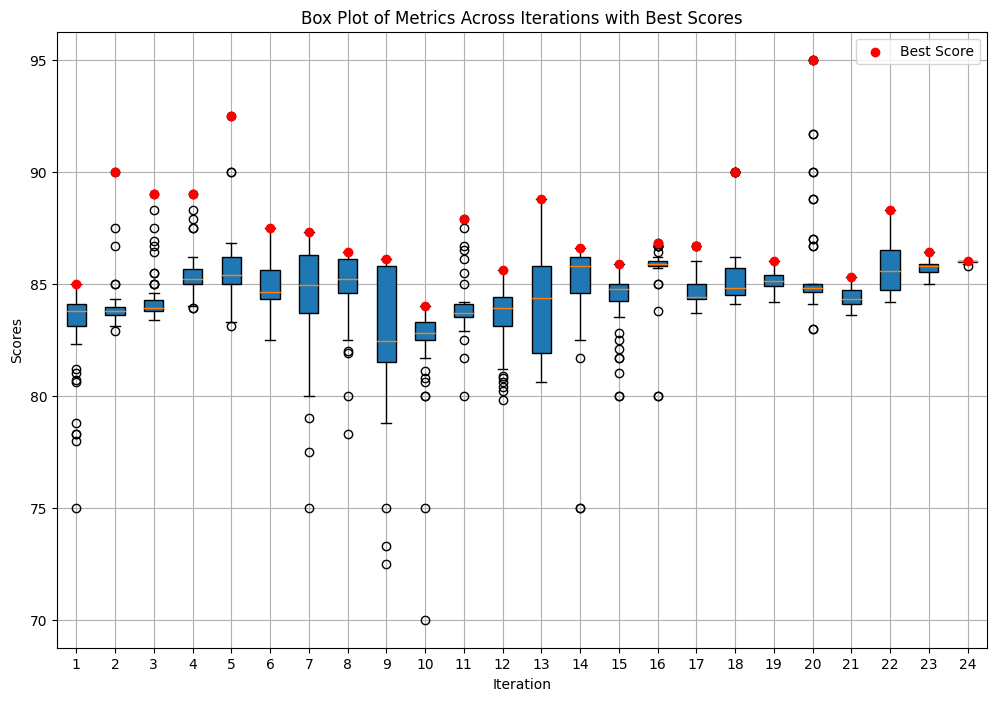

In [19]:
# Splitting the list into iterations, with each iteration having 50 numbers
iterations = [float_numbers[i:i + 50] for i in range(0, len(float_numbers), 50)]

# Calculate the best score for each iteration
best_scores = [max(iteration) for iteration in iterations]

# Create a box plot for all iterations
plt.figure(figsize=(12, 8))
plt.boxplot(iterations, patch_artist=True)

# Highlight the best scores for each iteration
plt.scatter(range(1, len(best_scores) + 1), best_scores, color='red', label='Best Score', zorder=3)

# Adding titles and labels
plt.title('Box Plot of Metrics Across Iterations with Best Scores')
plt.xlabel('Iteration')
plt.ylabel('Scores')
plt.legend()
plt.grid(True)

plt.show()


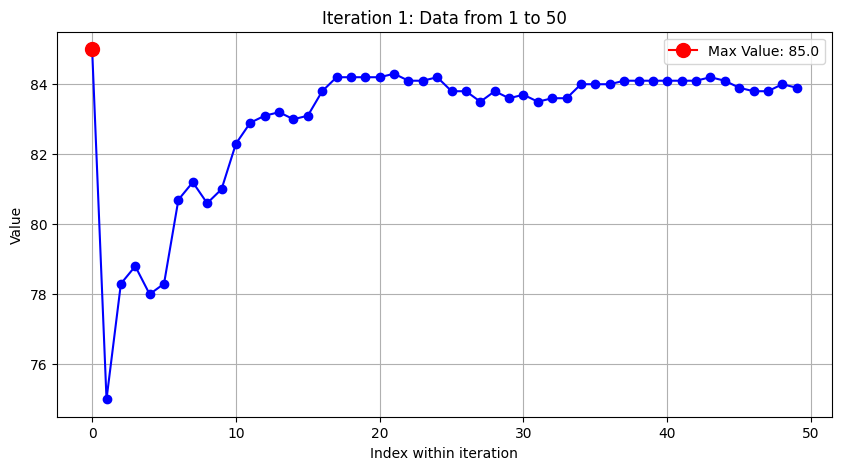

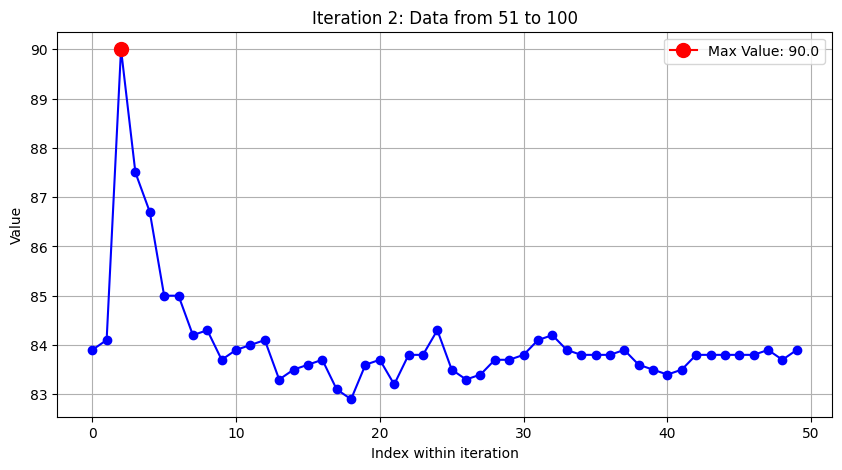

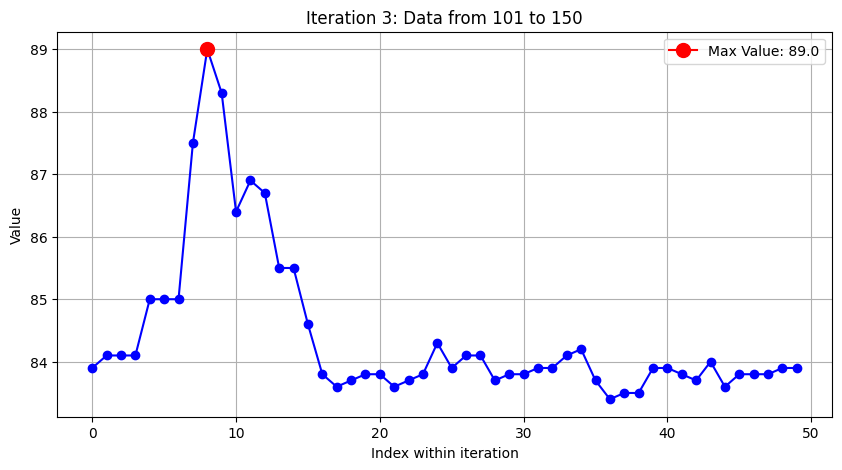

Average Metric: 0.0 / 9  (0.0):  18%|█▊        | 9/50 [1:29:17<6:46:46, 595.28s/it]


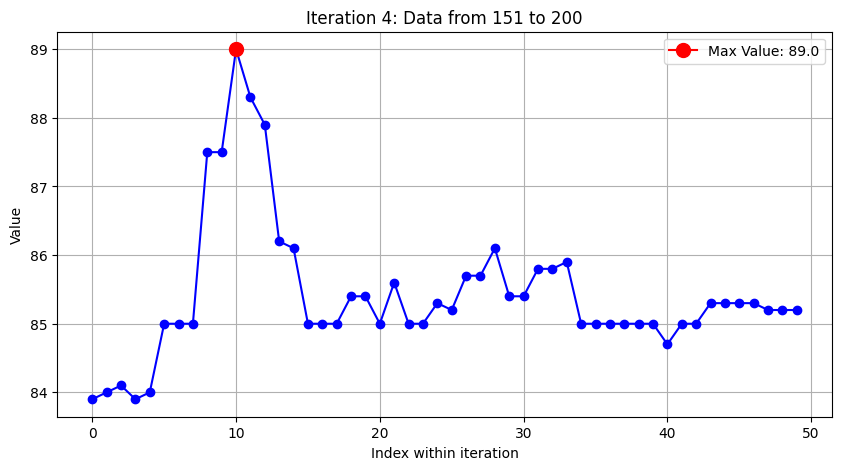

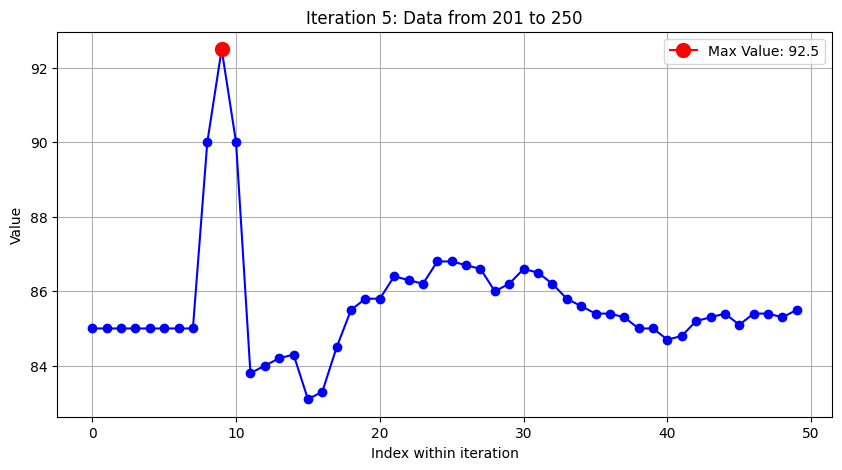

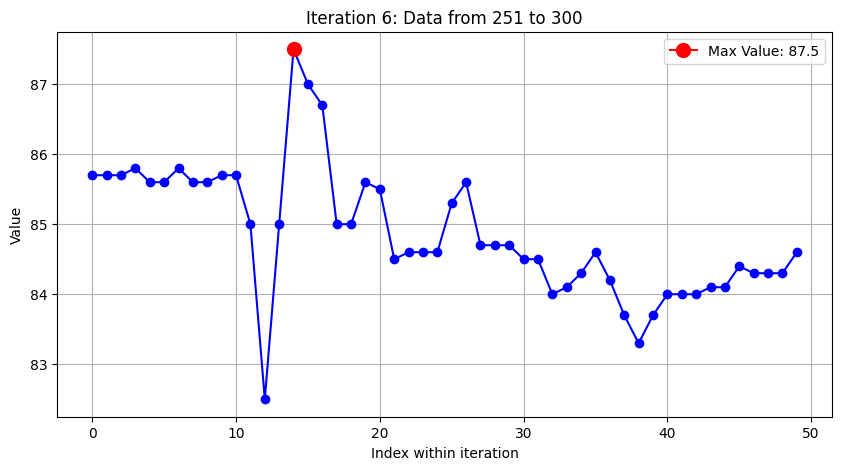

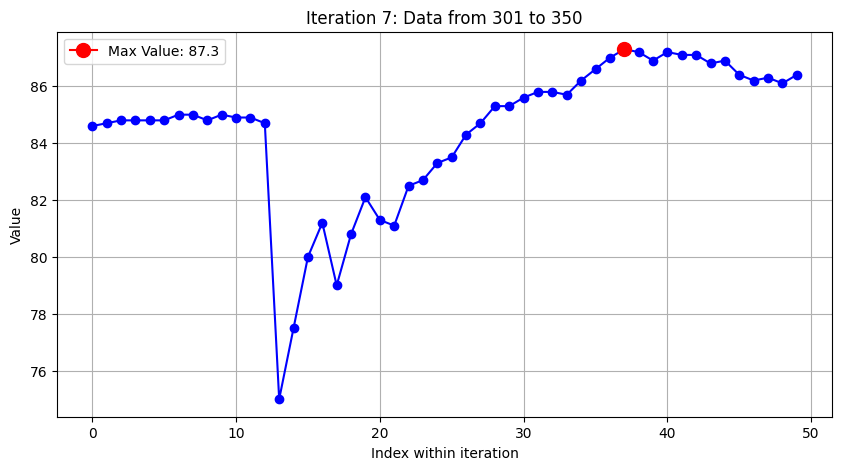

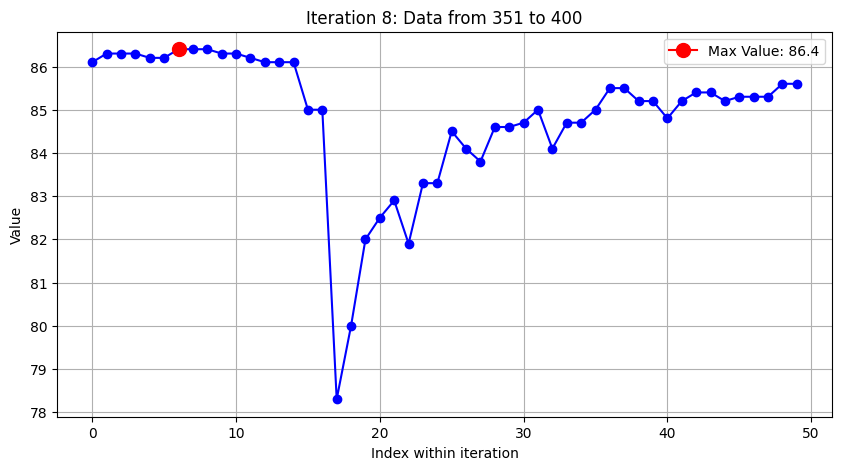

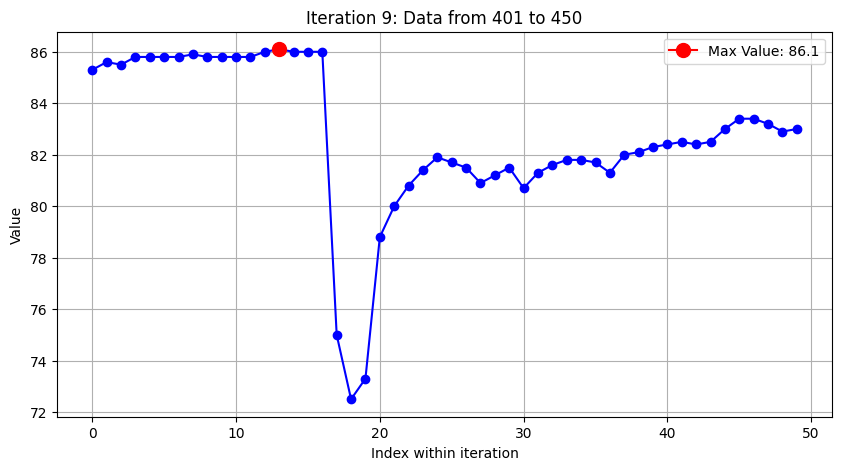

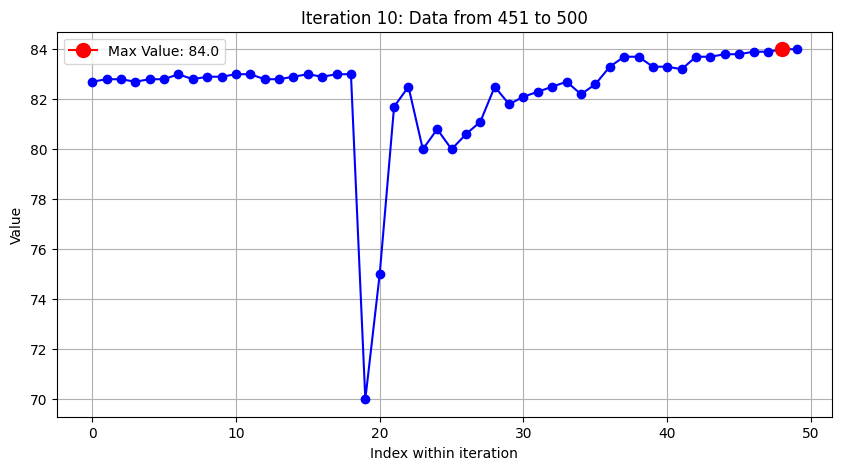

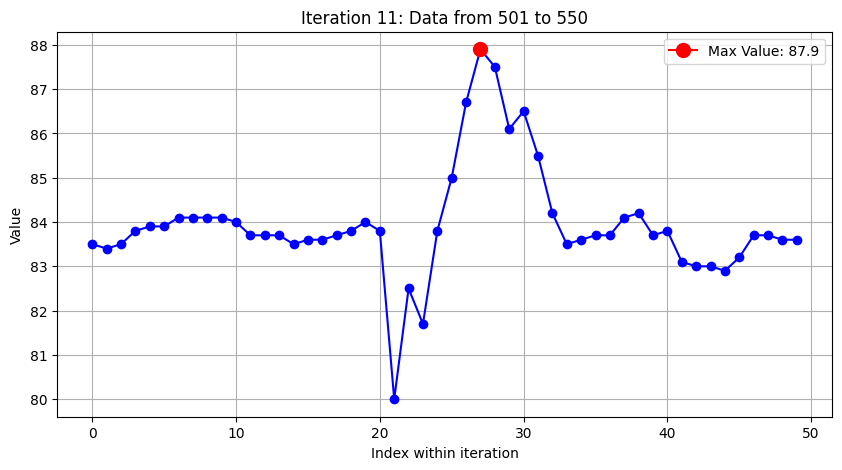

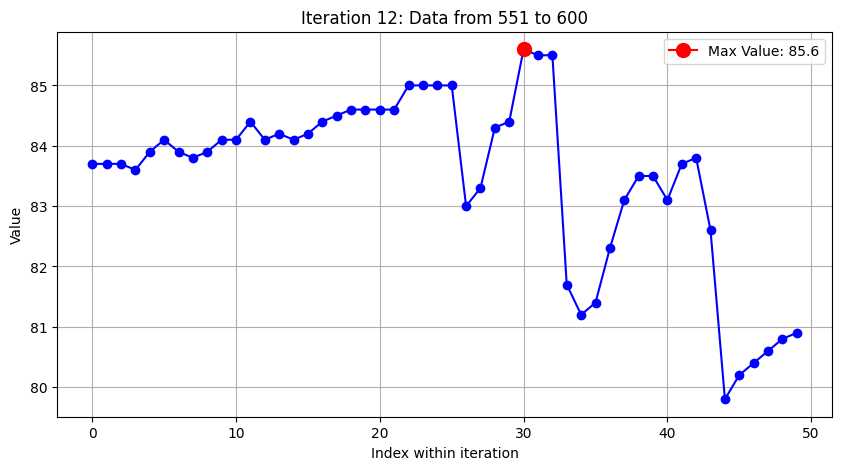

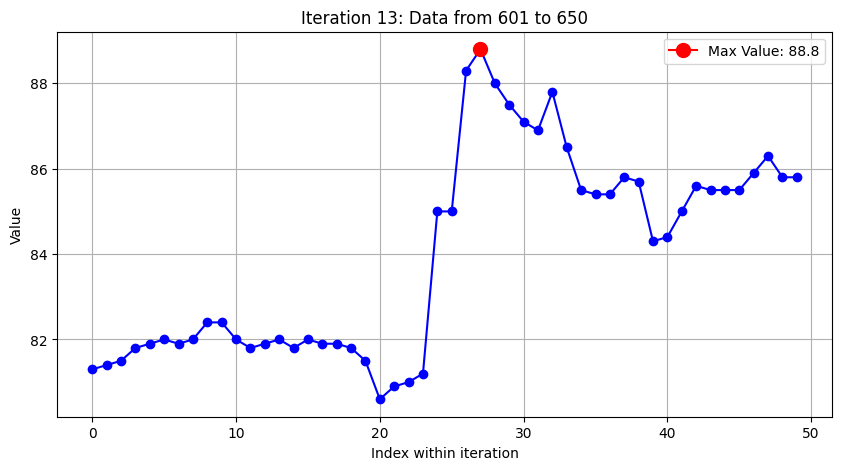

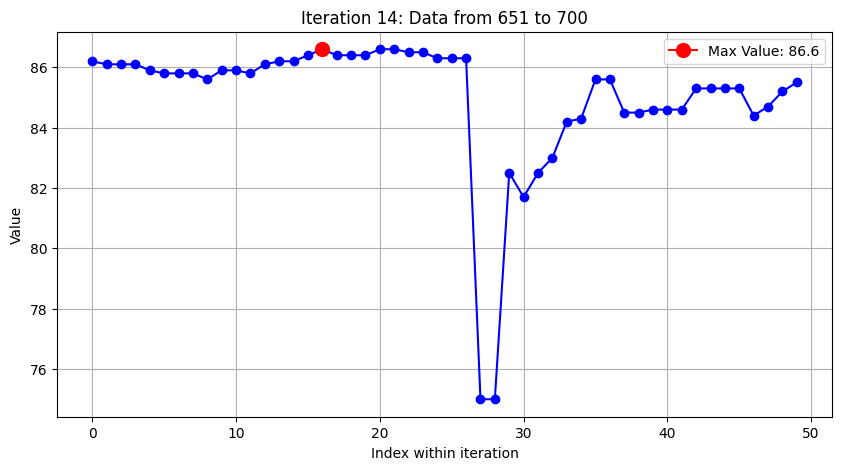

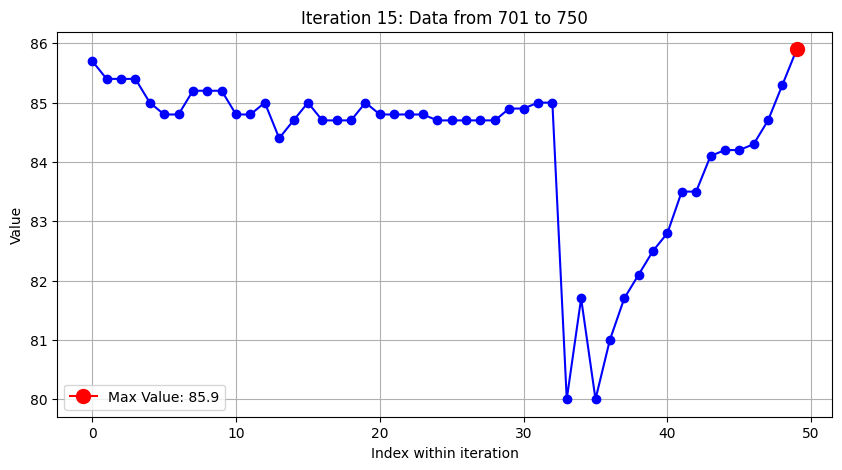

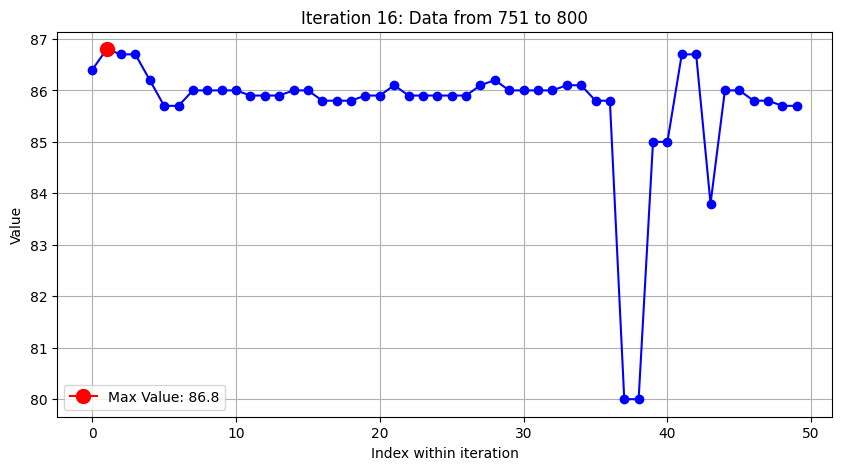

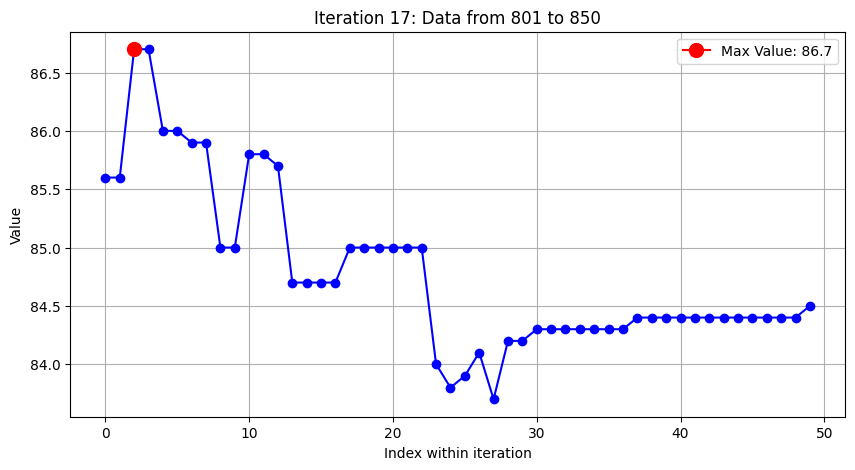

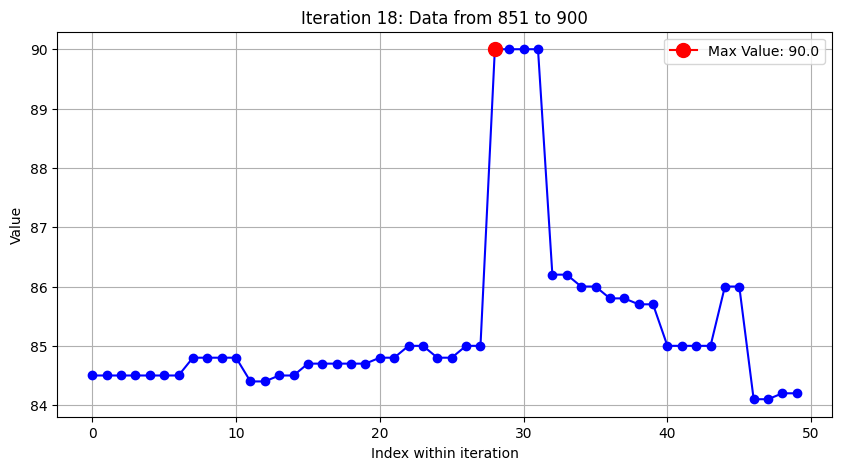

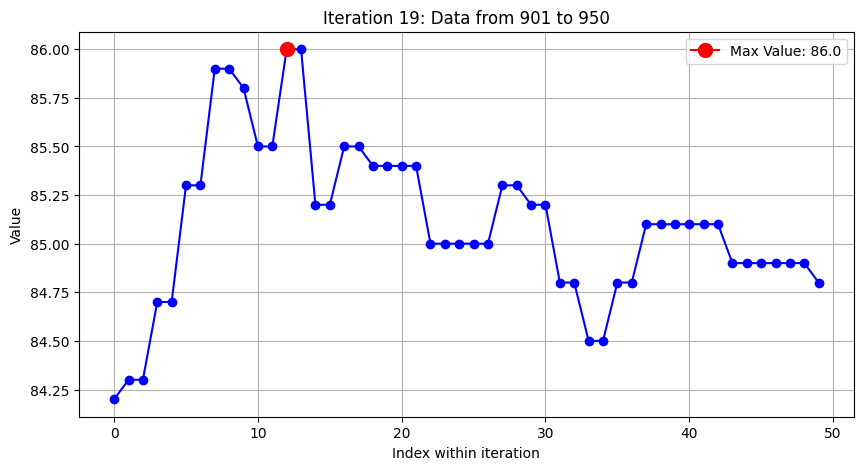

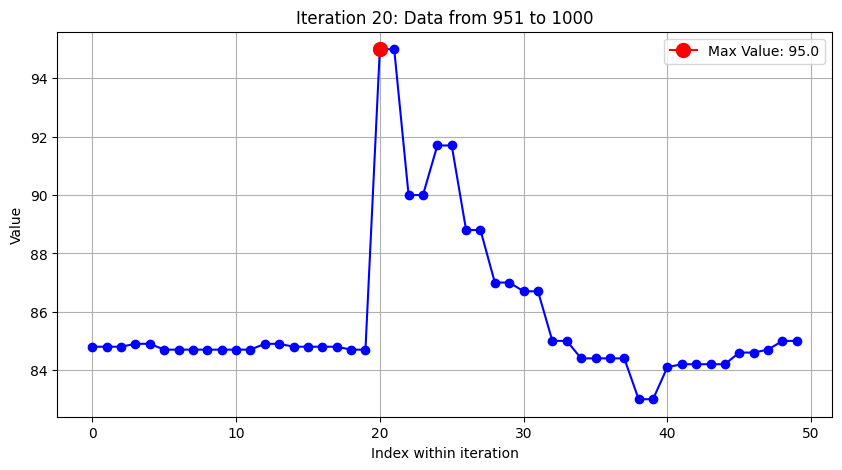

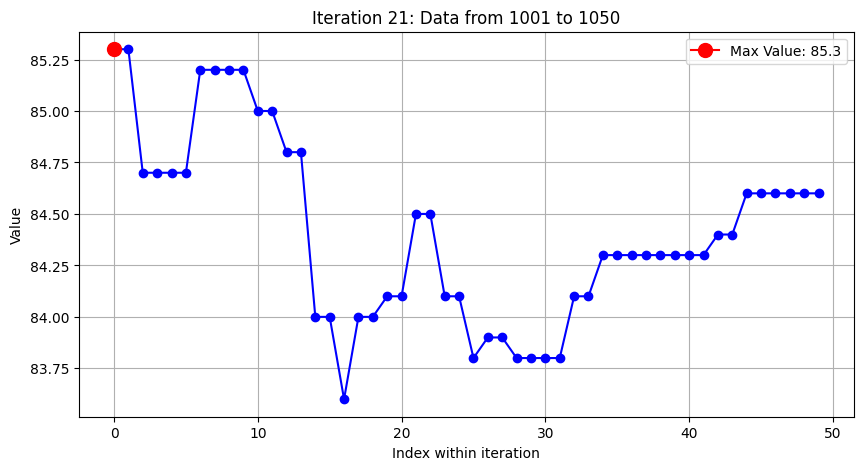

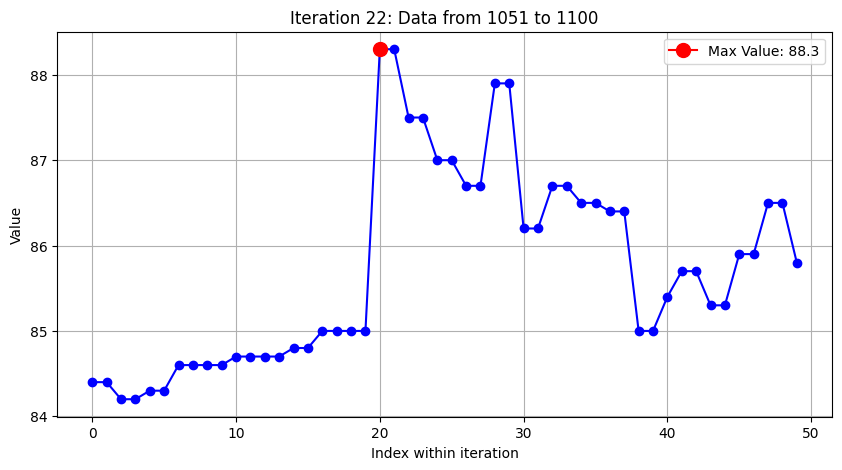

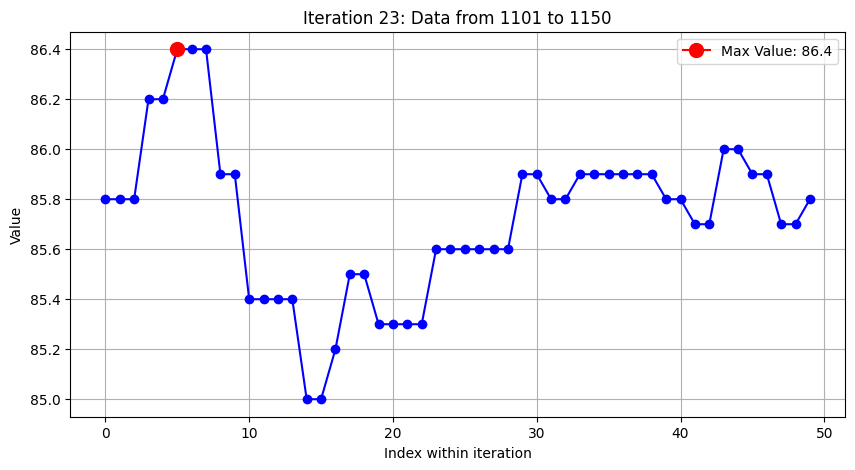

In [ ]:
n = 50
iterations = len(float_numbers) // n

for i in range(iterations):
    start_idx = i * n
    end_idx = start_idx + n
    subset = float_numbers[start_idx:end_idx]

    # Find the index of the max value in the subset
    max_idx = np.argmax(subset)

    # Plot the data
    plt.figure(figsize=(10, 5))
    plt.plot(subset, color='blue', marker='o')

    # Highlight the max value
    plt.plot(max_idx, subset[max_idx], color='red', marker='o', markersize=10, label=f'Max Value: {subset[max_idx]}')

    plt.title(f'Iteration {i + 1}: Data from {start_idx + 1} to {end_idx}')
    plt.xlabel('Index within iteration')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

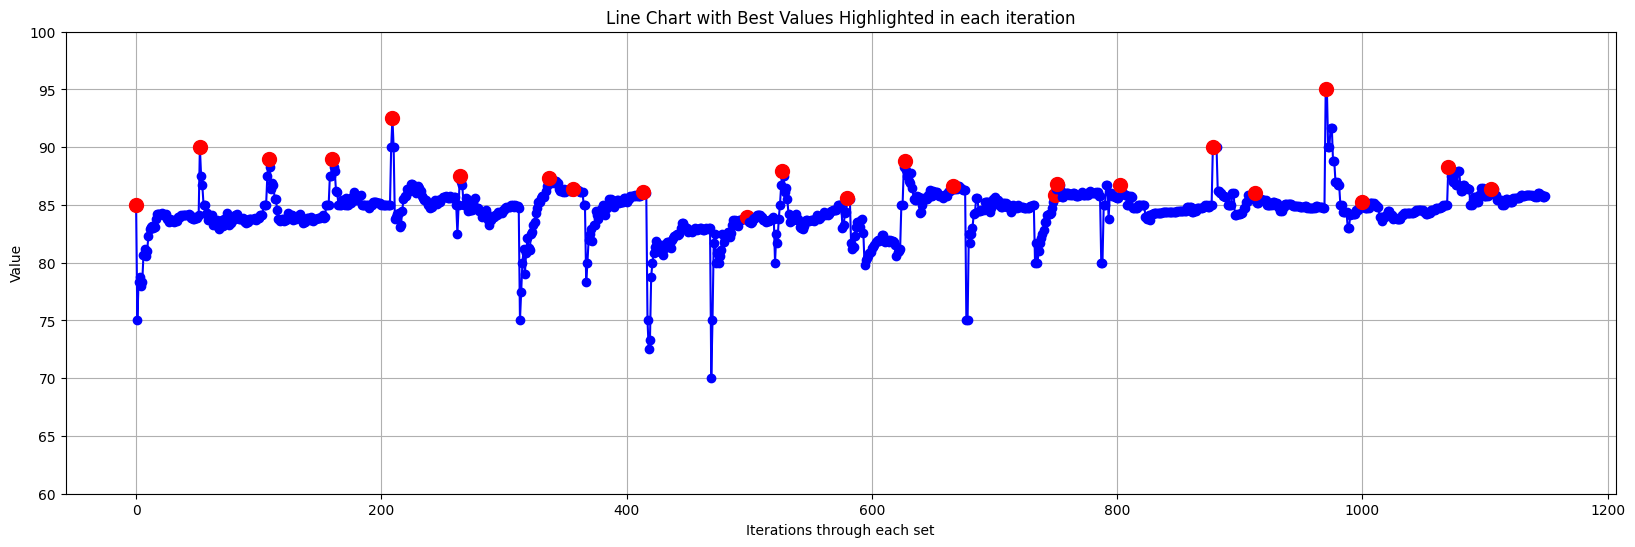

In [25]:
# Iterate over every 50 items
n = 50
iterations = len(float_numbers) // n

plt.figure(figsize=(20, 6))

for i in range(iterations):
    start_idx = i * n
    end_idx = start_idx + n
    subset = float_numbers[start_idx:end_idx]

    # Find the index of the max value in the subset
    max_idx = np.argmax(subset)

    # Plot the data for this subset
    plt.plot(range(start_idx, end_idx), subset, color='blue', marker='o')

    # Highlight the max value within the subset
    plt.plot(start_idx + max_idx, subset[max_idx], color='red', marker='o', markersize=10)

# Adding final touches to the plot
plt.ylim(60, 100)
plt.title('Line Chart with Best Values Highlighted in each iteration')
plt.xlabel('Iterations through each set')
plt.ylabel('Value')
plt.grid(True)
plt.show()

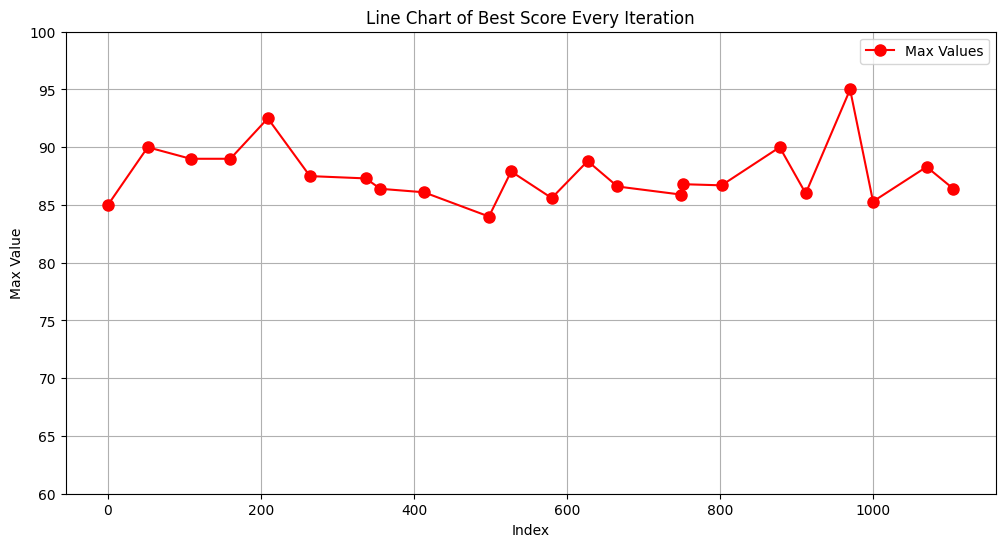

In [ ]:
# Iterate over every 50 items
n = 50
iterations = len(float_numbers) // n

max_values = []
max_indices = []

for i in range(iterations):
    start_idx = i * n
    end_idx = start_idx + n
    subset = float_numbers[start_idx:end_idx]

    # Find the index of the max value in the subset
    max_idx = np.argmax(subset)

    # Store the max value and its global index
    max_values.append(subset[max_idx])
    max_indices.append(start_idx + max_idx)

# Plot only the max values
plt.figure(figsize=(12, 6))
plt.plot(max_indices, max_values, color='red', marker='o', linestyle='-', markersize=8, label='Max Values')

# Set y-axis range from 0 to 100
plt.ylim(60, 100)

# Adding final touches to the plot
plt.title('Line Chart of Best Score Every Iteration')
plt.xlabel('Index')
plt.ylabel('Max Value')
plt.grid(True)
plt.legend()
plt.show()

#Example Data Process

In [ ]:
red_hook_lobster = pd.read_csv('red_hook_lobster_topics_accuracy_103.csv')[:104].drop(index=102)

In [ ]:
red_hook_lobster

,Name,Profile Location,Score,Date,Elite 24,Friends,Reviews,Photos,reserved,pictures,...,d2,a2,c3,d3,a3,c4,d4,a4,missing,c5
0,Alison G.,"Springfield, VA",5,"Jun 24, 2024",no,1131,222,1210,no,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Priscilla R.,"Flushing, New York, NY",4,"Jun 7, 2024",no,2,14,40,no,3 photos,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,Rebecca C.,"New York, NY",4,"Jun 1, 2024",no,606,267,603,no,4 photos,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Carlton R.,"Levittown, NY",4,"May 29, 2024",no,73,68,118,no,8 photos,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
4,Christina G.,"Brooklyn, NY",2,"May 26, 2024",no,1,149,1,no,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,Customer service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,Alexa A.,"Manhattan, New York, NY",4,"Jul 7, 2022",no,1,75,9,no,2 photos,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
99,Ting Z.,"Brooklyn, NY",4,"Jul 3, 2022",no,147,371,762,no,NaN,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN
100,Pett O.,"Manhattan, NY",4,"Jul 3, 2022",no,105,350,237,no,1 photo,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
101,Maximus L.,"San Francisco, CA",5,"Jul 2, 2022",no,0,80,5,no,NaN,...,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
rhl_reviews = red_hook_lobster[['Comment', 'topics', 'c1', 'd1', 'a1', 'c2', 'd2', 'a2', 'c3','d3', 'a3', 'c4', 'd4', 'a4', 'missing', 'c5']]

In [ ]:
# Adjust the function to pair categories and descriptions correctly, even if lengths do not match
def clean_extracted_data(topic_text):
    lines = topic_text.split('\n')
    categories = []
    descriptions = []
    attitudes = []
    for line in lines:
        if 'Category:' in line:
            categories.append(line.replace('- Category:', '').strip())
        elif 'Description:' in line:
            descriptions.append(line.replace('- Description:', '').strip())
        elif 'Attitude:' in line:
            attitudes.append(line.replace('- Attitude:', '').strip())
    # Pad the shorter list with empty strings to ensure equal length
    max_length = max(len(categories), len(descriptions), len(attitudes))
    categories += ['No Category'] * (max_length - len(categories))
    descriptions += ['No Description'] * (max_length - len(descriptions))
    attitudes += ['No Attitude'] * (max_length - len(attitudes))
    return categories, descriptions, attitudes

In [ ]:
# Apply the updated function to each row
rhl_reviews['Categories'], rhl_reviews['Descriptions'], rhl_reviews['Attitudes'] = zip(*rhl_reviews['topics'].copy().apply(clean_extracted_data))

<ipython-input-243-b75a004e3c8b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rhl_reviews['Categories'], rhl_reviews['Descriptions'], rhl_reviews['Attitudes'] = zip(*rhl_reviews['topics'].copy().apply(clean_extracted_data))
<ipython-input-243-b75a004e3c8b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rhl_reviews['Categories'], rhl_reviews['Descriptions'], rhl_reviews['Attitudes'] = zip(*rhl_reviews['topics'].copy().apply(clean_extracted_data))
<ipython-input-243-b75a004e3c8b>:2: SettingWithCopyWarni

In [ ]:
rhl_reviews['missing'][4] != 'nan'

True

In [ ]:
def calculate_accuracies_with_percentage(row):
    issue_flag = False

    # Calculate the accuracy for categories
    if not math.isnan(row['missing']):
      category_scores = row[['c1', 'c2', 'c3', 'c4','missing']].sum(skipna=True)
      category_length = len(row['Categories']) + 1
    else:
      category_scores = row[['c1', 'c2', 'c3', 'c4']].sum(skipna=True)
      category_length = len(row['Categories'])
    category_accuracy = category_scores / category_length

    # Calculate the accuracy for descriptions
    description_scores = row[['d1', 'd2', 'd3', 'd4']].sum(skipna=True)
    description_length = len(row['Descriptions'])
    description_accuracy = description_scores/description_length

    # Calculate the accuracy for attitudes
    attitude_scores = row[['a1', 'a2', 'a3', 'a4']].sum(skipna=True)
    attitude_length = len(row['Attitudes'])
    attitude_accuracy = attitude_scores/attitude_length

    # Final score as the average of the three accuracies
    final_score = (category_accuracy + description_accuracy + attitude_accuracy) / 3
    score = final_score*100

    return pd.Series({
        'Category Accuracy (%)': category_accuracy*100,
        'Description Accuracy (%)': description_accuracy*100,
        'Attitude Accuracy (%)': attitude_accuracy*100,
        'Final Score (%)': score,
        'Data Issue Flag': issue_flag
    })
    # return score

In [ ]:
accuracies_with_percentage = rhl_reviews.apply(calculate_accuracies_with_percentage, axis=1)

In [ ]:
# Apply the function to the dataset
accuracies_with_percentage = rhl_reviews.apply(calculate_accuracies_with_percentage, axis=1)

# Combine with the original data
result_with_percentage = pd.concat([rhl_reviews, accuracies_with_percentage], axis=1)
result_with_percentage

,Comment,topics,c1,d1,a1,c2,d2,a2,c3,d3,...,missing,c5,Categories,Descriptions,Attitudes,Category Accuracy (%),Description Accuracy (%),Attitude Accuracy (%),Final Score (%),Data Issue Flag
0,I LOVE Red Hook Lobster (RHL). I live in the D...,- Category: Food Quality\n - Description: The...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,"[Food Quality, Value for Money]",[The reviewer loves the Connecticut roll and t...,"[Satisfied, Not fully satisfied]",100.000000,100.000000,100.000000,100.000000,False
1,Came here for a quick dinner because it's the ...,- Category: Food Quality\n - Description: Lob...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,"[Food Quality, Ambiance, Cleanliness]","[Lobster rolls, oysters, and appetizers were d...","[Satisfied, Satisfied, Dissatisfied]",100.000000,100.000000,100.000000,100.000000,False
2,I was feeling seafood and was super satiated b...,- Category: Food Quality\n - Description: The...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,"[Food Quality, Menu Choice]",[The seafood meal was satisfying but not the b...,"[Enjoyable, Positive]",100.000000,100.000000,100.000000,100.000000,False
3,"Delicious! So, if you know me, I'm not a huge ...",- Category: Food Quality\n - Description: Lob...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,"[Food Quality, Customer Service, Ambiance]","[Lobster roll, particularly the ""main event"" o...","[Satisfied, Satisfied, Satisfied]",100.000000,100.000000,100.000000,100.000000,False
4,The drinks r good the staff is attentive. Howe...,- Category: Food Quality\n - Description: The...,1.0,0.5,1.0,NaN,NaN,NaN,NaN,NaN,...,-1.0,Customer service,[Food Quality],"[The crab dip had a ton of shells in it, and t...",[Dissatisfied],0.000000,50.000000,100.000000,50.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,I suggest committing to a proper lobster exper...,- Category: Food Quality\n - Description: The...,1.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,"[Food Quality, Customer Service, Food Quality]","[The lobster roll was not worth $33, with a so...","[Unsatisfied, Satisfied, Satisfied]",33.333333,16.666667,33.333333,27.777778,False
99,"If I had to summarize in one line, it'd be: de...",- Category: Food Quality\n - Description: Sma...,1.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,"[Food Quality, Value for Money, Order Accuracy...","[Small portion sizes for the price, tasty food...","[Mixed, Dissatisfied, Satisfied, Mixed]",75.000000,62.500000,75.000000,70.833333,False
100,Beautiful warehouse with a fishery feeling. Th...,- Category: Ambiance\n- Description: Beautiful...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,"[Ambiance, Food Quality, Value for Money, Cust...","[Beautiful warehouse with a fishery feeling, c...","[Positive, Positive, Neutral, Positive]",100.000000,100.000000,100.000000,100.000000,False
101,Lobsta roll was terrific. Fried pickles were a...,- Category: Food Quality\n - Description: Lob...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,NaN,NaN,"[Food Quality, Customer Service, Value for Money]",[Lobsta roll and fried pickles were mentioned ...,"[Satisfied, Satisfied, Satisfied]",66.666667,66.666667,66.666667,66.666667,False


In [ ]:
accuracies_with_percentage['Category Accuracy (%)'][:100].mean(), accuracies_with_percentage['Description Accuracy (%)'][:100].mean(), accuracies_with_percentage['Attitude Accuracy (%)'][:100].mean(), accuracies_with_percentage['Final Score (%)'][:100].mean()

(77.69999999999999, 83.54166666666666, 85.58333333333334, 82.275)

In [ ]:
result_with_percentage.to_csv('red_hook_lobster_topics_accuracy_100_with_percentage.csv', index=False)

In [ ]:
correct_labels = result_with_percentage[result_with_percentage['Final Score (%)'] == 100]

In [ ]:
correct_labels

,Comment,topics,c1,d1,a1,c2,d2,a2,c3,d3,...,missing,c5,Categories,Descriptions,Attitudes,Category Accuracy (%),Description Accuracy (%),Attitude Accuracy (%),Final Score (%),Data Issue Flag
0,I LOVE Red Hook Lobster (RHL). I live in the D...,- Category: Food Quality\n - Description: The...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,"[Food Quality, Value for Money]",[The reviewer loves the Connecticut roll and t...,"[Satisfied, Not fully satisfied]",100.0,100.0,100.0,100.0,False
1,Came here for a quick dinner because it's the ...,- Category: Food Quality\n - Description: Lob...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,"[Food Quality, Ambiance, Cleanliness]","[Lobster rolls, oysters, and appetizers were d...","[Satisfied, Satisfied, Dissatisfied]",100.0,100.0,100.0,100.0,False
2,I was feeling seafood and was super satiated b...,- Category: Food Quality\n - Description: The...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,"[Food Quality, Menu Choice]",[The seafood meal was satisfying but not the b...,"[Enjoyable, Positive]",100.0,100.0,100.0,100.0,False
3,"Delicious! So, if you know me, I'm not a huge ...",- Category: Food Quality\n - Description: Lob...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,"[Food Quality, Customer Service, Ambiance]","[Lobster roll, particularly the ""main event"" o...","[Satisfied, Satisfied, Satisfied]",100.0,100.0,100.0,100.0,False
5,Outstanding lobster rolls. Although it's price...,- Category: Food Quality\n - Description: Out...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,"[Food Quality, Value for Money, Customer Servi...","[Outstanding lobster rolls, good drink selecti...","[Satisfied, Satisfied, Satisfied, Satisfied]",100.0,100.0,100.0,100.0,False
7,Been here a handful of times and each time I l...,- Category: Food Quality\n - Description: Clo...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,"[Food Quality, Value for Money, Ambiance]",[Closest you will get to going to Maine with w...,"[Satisfied, Mixed, Satisfied]",100.0,100.0,100.0,100.0,False
8,Omg one of the best lobster spots in nyc! Took...,- Category: Food Quality\n - Description: The...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,"[Food Quality, Customer Service, Ambiance]",[The lobster dishes at this restaurant are top...,"[Satisfactory, Satisfactory, Satisfactory]",100.0,100.0,100.0,100.0,False
11,"Wow! The quality of lobster is fantastic, prob...",- Category: Food Quality\n - Description: Fre...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,"[Food Quality, Customer Service, Cleanliness, ...","[Fresh lobster, well-balanced and delicious di...","[Satisfied, Satisfied, Satisfied, Satisfied]",100.0,100.0,100.0,100.0,False
15,Attentive service good value ordered 100 for m...,- Category: Customer Service\n - Description:...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,"[Customer Service, Food Quality, Value for Money]","[Attentive service good value, The lobster was...","[Positive, Positive, Positive]",100.0,100.0,100.0,100.0,False
21,We've gone to RHLP for years and remain fond o...,- Category: Food Quality\n - Description: The...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,"[Food Quality, Customer Service, Ambiance, Val...",[The reviewer mentions being fond of the food ...,"[Positive, Positive, Positive, Positive]",100.0,100.0,100.0,100.0,False


In [ ]:
correct_labels.to_csv('correct_labels.csv', index=False)